In [2]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import spacy
import ast
import re
import itertools
from thefuzz import process
from itertools import *
import neuralcoref
import en_core_web_sm
from bs4 import BeautifulSoup
import requests
import gender_guesser.detector as gender

import sys
sys.path.insert(0, 'GenderGapTracker/NLP/main')

/usr/local/lib/python3.7/site-packages/thefuzz/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


## Set Up

In [113]:
import importlib.util
import sys

from GenderGapTracker.NLP.main.quote_extractor import extract_quotes
from GenderGapTracker.NLP.main.entity_gender_annotator import (
    merge_nes, remove_invalid_nes, quote_assign
)
from GenderGapTracker.NLP.main.utils import (
    remove_accents, preprocess_text
)

nlp = en_core_web_sm.load()
coref = neuralcoref.NeuralCoref(nlp.vocab, max_dist=200)
nlp.add_pipe(coref, name='neuralcoref')

# Select functions from GenderTracker file.
def collect_quotes(quotes):
    """Structure final quotes as a list of records for display in a table."""
    collection = []
    for q in quotes:
        # Checking for 'PERSON' before assigning a speaker - if the quote is of type 'Heuristic',
        # the conditions are relaxed and we accept the quote with a blank speaker name
        if q.get('named_entity_type') == 'PERSON' or q.get('quote_type') == 'Heuristic':
            speaker = q.get('named_entity', "")
            quote = preprocess_text(q.get('quote', ""))
            collection.append({'speaker': speaker, 'quote': quote})
    return collection

def extract_quotes_and_entities(sample_text):
    # """Convert raw text to a spaCy doc object and return its named entities and quotes"""
    text = preprocess_text(str(sample_text))
    doc = nlp(text)
    quotes = extract_quotes(doc_id="temp000", doc=doc, write_tree=False)
    unified_nes = merge_nes(doc)
    named_entities = remove_invalid_nes(unified_nes)
    # Get list of people and sources, along with a combined list of all quotes
    people = list(named_entities.keys())
    # Obtain gender of speakers from condensed coreference clusters
    _, _, all_quotes = quote_assign(named_entities, quotes, doc)
    quotes_and_sources = collect_quotes(all_quotes)
    # sort alphabetically based on speaker name
    quotes_and_sources = sorted(quotes_and_sources, key=lambda x: x['speaker'], reverse=True)
    # Get proper list of sources from the list of quotes and speakers
    sources = list(set([person['speaker'] for person in quotes_and_sources]))
    # Merge list of people and sources (in case there is a mismatch) to get full list of people
    people = list(set(people).union(set(sources)))

    return people, sources, quotes_and_sources

# LIST OF REPORTING VERBS (asserts,declares,says,etc.)
reporting_verbs = []
with open('GenderGapTracker/NLP/main/rules/quote_verb_list.txt', 'r') as f:
    line = f.readline()
    while line:
        reporting_verbs.append(line[:-1]) # up until newline character
        line = f.readline()
f.close()

In [5]:
# return dataframe softmatching >= thresh% to an organization in org_df
# and dataframe of instances which failed to softmatch.
def match_org_test(df, org_df, thresh):
    matches = pd.DataFrame()
    missed = pd.DataFrame()
    two = pd.DataFrame()
    for idx, match in df.iterrows():
        if idx % 100 == 0:
            print(idx)
        score = 0
        for t_org in ast.literal_eval(str(match['orgs'])):
            t_org = t_org.replace("\\","")
            # Skip organizations 1 or 2 chars long
            if len(t_org) <= 2:
                continue
            thisorg, thisscore = process.extract(t_org, org_df, limit=1)[0]
            if thisscore > score:
                org = thisorg
                score = thisscore
        if score >= thresh:
            toappend = [idx, match['idx'], match['quote'], match['people'], org]
            matches = matches.append([toappend])
        else:
            missed = missed.append(match)
    return (matches, missed)

In [6]:
def parse_gtracker(df,ents):
    qse = pd.DataFrame() # quote speaker entities
    missed_speaker = pd.DataFrame()
    for idx, row in df.iterrows():
        if idx % 1000 == 0:
            print(idx)
        sp1, sp2, sp3 = ast.literal_eval(str(ents.loc[idx,"val"]))
        quotes = [d['quote'] for d in sp3]
        sents = [sent.text for sent in nlp(row["text"]).sents]
        for quote in quotes:
            match_sent = [s for s in sents if quote[1:-1] in s]
            match_sent = str(match_sent)[1:-1]
            doc = nlp(match_sent)
            entities = {key: list(set(map(lambda x: str(x), g))) for key, g in groupby(sorted(doc.ents, key=lambda x: x.label_), lambda x: x.label_)}
            split_by_quote = str(match_sent).split(quote[1:-1])
            context = split_by_quote[0]
            doc = nlp(context)
            entities = {key: list(set(map(lambda x: str(x), g))) for key, g in groupby(sorted(doc.ents, key=lambda x: x.label_), lambda x: x.label_)}
            if 'PERSON' in entities.keys() and 'ORG' in entities.keys():
                toappend = [idx, match_sent, entities['PERSON'], entities['ORG'], row["source"]]
                qse = qse.append([toappend])
            elif 'PERSON' not in entities.keys() and 'ORG' not in entities.keys() and len(split_by_quote) > 1:
                context = split_by_quote[1]
                doc = nlp(context)
                entities = {key: list(set(map(lambda x: str(x), g))) for key, g in groupby(sorted(doc.ents, key=lambda x: x.label_), lambda x: x.label_)}
                if 'PERSON' in entities.keys() and 'ORG' in entities.keys():
                    toappend = [idx, match_sent, entities['PERSON'], entities['ORG'], row["source"]]
                    qse = qse.append([toappend])
                else:
                    toappend = [idx, quote]
                    missed_speaker = missed_speaker.append([toappend])
            else:
                toappend = [idx, quote]
                missed_speaker = missed_speaker.append([toappend])
    return qse, missed_speaker


In [7]:
# CODE TO PROCESS A DATAFRAME
def get_qse(df):
    print("Running GenderTracker Dependency Parse Method...")
    df_ents = pd.DataFrame([[i, extract_quotes_and_entities(df.loc[i,"text"])] for i in df.index.values])
    print("Done.")
    df_ents.columns = ['idx','val']
    df_ents.index = df_ents['idx']
    print("Finding quotes with persons and orgs attached...")
    df_qse, df_missed = parse_method1(df,df_ents)
    print("Done.")
    return (df_qse, df_missed)

In [123]:
# Load the data
def union_df(df1,df2,how):
    return pd.concat([df1,df2],ignore_index=True).drop_duplicates(subset=how)

def whole_df(dfs):
    return pd.concat(dfs,axis=0,ignore_index =True)

aylien = pd.read_csv("data/data.csv")

educs = ['nyt','cnn','fox','breit','nyp','huff']
b_nyt_qse = pd.read_csv("data/nyt_qse_m1.csv")
b_nyt_qse = b_nyt_qse.drop(columns = ['Unnamed: 0'])
b_nyt_gov = pd.read_csv("data/nyt_gov.csv")
b_nyt_thinkt = pd.read_csv("data/nyt_thinkt.csv")
b_nyt_educ = pd.read_csv("data/nyt_educ_m1.csv")
b_nyt_educ["idx"] = b_nyt_educ["idx.1"]
b_nyt_educ = b_nyt_educ.drop(columns=["idx.1","idx.1.1"])
b_nyt_gov = b_nyt_gov.drop(columns = ['Unnamed: 0'])
b_nyt_gov.columns = ['idx', 'idx.1','quote','people','orgs']
b_nyt_thinkt = b_nyt_thinkt.drop(columns = ['Unnamed: 0'])
b_nyt_thinkt.columns = ['idx', 'idx.1','quote','people','orgs']
y_nyt_gov = pd.read_csv("data/y_nyt_gov.csv").drop(columns=['Unnamed: 0'])
y_nyt_gov.columns = ['idx','idx.1','quote','people','org']
b_nyt_qse['outlet'] = 'NYT'
b_nyt_educ['outlet'] = 'NYT'
b_nyt_gov['outlet'] = 'NYT'
b_nyt_thinkt['outlet'] = 'NYT'
y_nyt_thinkt = pd.read_csv("data/y_nyt_thinkt.csv").drop(columns=['Unnamed: 0'])
y_nyt_thinkt.columns = ['idx','idx.1','quote','people','org']
y_nyt_qse = pd.read_csv("data/yiwen_data/refined_nyt_all.csv")
y_nyt_qse.columns = ['idx','people','orgs','quote']
y_nyt_qse['quote'] = y_nyt_qse['quote'].str.replace("[","").str.replace("]","")
y_nyt_educ = pd.read_csv("data/y_nyt_educ.csv").drop(columns=['Unnamed: 0', '0'])
y_nyt_educ.columns = ['idx','quote','people','educ_inst']
y_nyt_educ['quote'] = y_nyt_educ['quote'].str.replace("['","\"",regex=False).str.replace("']",'"')
y_nyt_educ.loc[~y_nyt_educ['people'].str.contains("\["),"people"] = "['" + y_nyt_educ.loc[~y_nyt_educ['people'].str.contains("\["),'people'].str.replace("'","") + "']"
y_nyt_qse.loc[~y_nyt_qse['people'].str.contains("\["),"people"] = "['" + y_nyt_qse.loc[~y_nyt_qse['people'].str.contains("\["),'people'].str.replace("'","") + "']"
y_nyt_thinkt.loc[~y_nyt_thinkt['people'].str.contains("\["),"people"] = "['" + y_nyt_thinkt.loc[~y_nyt_thinkt['people'].str.contains("\["),'people'].str.replace("'","") + "']"
y_nyt_gov.loc[~y_nyt_gov['people'].str.contains("\["),"people"] = "['" + y_nyt_gov.loc[~y_nyt_gov['people'].str.contains("\["),'people'].str.replace("'","") + "']"
y_nyt_qse['outlet'] = 'NYT'
y_nyt_educ['outlet'] = 'NYT'
y_nyt_gov['outlet'] = 'NYT'
y_nyt_thinkt['outlet'] = 'NYT'
y_nyt_qse['method'] = 'NER'
y_nyt_educ['method'] = 'NER'
y_nyt_gov['method'] = 'NER'
y_nyt_thinkt['method'] = 'NER'
b_nyt_qse['method'] = 'DEP'
b_nyt_educ['method'] = 'DEP'
b_nyt_gov['method'] = 'DEP'
b_nyt_thinkt['method'] = 'DEP'
nyt_qse = union_df(b_nyt_qse,y_nyt_qse,['quote'])
nyt_educ = union_df(b_nyt_educ,y_nyt_educ,['quote'])
nyt_thinkt = union_df(b_nyt_thinkt,y_nyt_thinkt,['quote'])
nyt_gov = union_df(b_nyt_gov,y_nyt_gov,['quote'])

b_cnn_qse = pd.read_csv("data/cnn_qse.csv")
b_cnn_qse = b_cnn_qse.drop(columns = ['Unnamed: 0'])
b_cnn_qse.columns = ['idx','quote','people','orgs','outlet']
b_cnn_educ = pd.read_csv("data/cnn_educ.csv")
b_cnn_gov = pd.read_csv("data/cnn_gov.csv")
b_cnn_thinkt = pd.read_csv("data/cnn_thinkt.csv")
b_cnn_educ = b_cnn_educ.drop(columns=['Unnamed: 0', '0'])
b_cnn_educ.columns = ['idx','quote','people','educ_inst']
b_cnn_gov = b_cnn_gov.drop(columns = ['Unnamed: 0'])
b_cnn_gov.columns = ['idx', 'idx.1','quote','people','orgs']
b_cnn_thinkt = b_cnn_thinkt.drop(columns = ['Unnamed: 0'])
b_cnn_thinkt.columns = ['idx', 'idx.1','quote','people','orgs']
b_cnn_qse['outlet'] = 'CNN'
b_cnn_educ['outlet'] = 'CNN'
b_cnn_gov['outlet'] = 'CNN'
b_cnn_thinkt['outlet'] = 'CNN'
y_cnn_thinkt = pd.read_csv("data/y_cnn_thinkt.csv").drop(columns=['Unnamed: 0'])
y_cnn_thinkt.columns = ['idx','idx.1','quote','people','org']
y_cnn_qse = pd.read_csv("data/yiwen_data/refined_cnn_all.csv")
y_cnn_qse.columns = ['idx','people','orgs','quote']
y_cnn_qse['quote'] = y_cnn_qse['quote'].str.replace("[","").str.replace("]","")
y_cnn_gov = pd.read_csv("data/y_cnn_gov.csv").drop(columns=['Unnamed: 0'])
y_cnn_gov.columns = ['idx','idx.1','quote','people','org']
y_cnn_educ = pd.read_csv("data/y_cnn_educ.csv").drop(columns=['Unnamed: 0', '0'])
y_cnn_educ.columns = ['idx','quote','people','educ_inst']
y_cnn_educ['quote'] = y_cnn_educ['quote'].str.replace("['","\"",regex=False).str.replace("']",'"')
y_cnn_educ.loc[~y_cnn_educ['people'].str.contains("\["),"people"] = "['" + y_cnn_educ.loc[~y_cnn_educ['people'].str.contains("\["),'people'].str.replace("'","") + "']"
y_cnn_qse.loc[~y_cnn_qse['people'].str.contains("\["),"people"] = "['" + y_cnn_qse.loc[~y_cnn_qse['people'].str.contains("\["),'people'].str.replace("'","") + "']"
y_cnn_thinkt.loc[~y_cnn_thinkt['people'].str.contains("\["),"people"] = "['" + y_cnn_thinkt.loc[~y_cnn_thinkt['people'].str.contains("\["),'people'].str.replace("'","") + "']"
y_cnn_gov.loc[~y_cnn_gov['people'].str.contains("\["),"people"] = "['" + y_cnn_gov.loc[~y_cnn_gov['people'].str.contains("\["),'people'].str.replace("'","") + "']"
y_cnn_qse['outlet'] = 'CNN'
y_cnn_educ['outlet'] = 'CNN'
y_cnn_gov['outlet'] = 'CNN'
y_cnn_thinkt['outlet'] = 'CNN'
y_cnn_qse['method'] = 'NER'
y_cnn_educ['method'] = 'NER'
y_cnn_gov['method'] = 'NER'
y_cnn_thinkt['method'] = 'NER'
b_cnn_qse['method'] = 'DEP'
b_cnn_educ['method'] = 'DEP'
b_cnn_gov['method'] = 'DEP'
b_cnn_thinkt['method'] = 'DEP'
cnn_qse = union_df(b_cnn_qse,y_cnn_qse,['quote'])
cnn_educ = union_df(b_cnn_educ,y_cnn_educ,['quote'])
cnn_thinkt = union_df(b_cnn_thinkt,y_cnn_thinkt,['quote'])
cnn_gov = union_df(b_cnn_gov,y_cnn_gov,['quote'])

b_fox_qse = pd.read_csv("data/fox_qse_m1.csv")
b_fox_qse = b_fox_qse.drop(columns = ['index.1'])
b_fox_qse.columns = ['idx','quote','people','orgs','outlet']
b_fox_educ = pd.read_csv("data/fox_educ.csv")
b_fox_gov = pd.read_csv("data/fox_gov.csv")
b_fox_thinkt = pd.read_csv("data/fox_thinkt.csv")
b_fox_educ = b_fox_educ.drop(columns=['Unnamed: 0', '0'])
b_fox_educ.columns = ['idx','quote','people','educ_inst']
b_fox_gov = b_fox_gov.drop(columns = ['Unnamed: 0'])
b_fox_gov.columns = ['idx', 'idx.1','quote','people','orgs']
b_fox_thinkt = b_fox_thinkt.drop(columns = ['Unnamed: 0'])
b_fox_thinkt.columns = ['idx', 'idx.1','quote','people','orgs']
b_fox_qse['outlet'] = 'FOX'
b_fox_educ['outlet'] = 'FOX'
b_fox_gov['outlet'] = 'FOX'
b_fox_thinkt['outlet'] = 'FOX'
y_fox_thinkt = pd.read_csv("data/y_fox_thinkt.csv").drop(columns=['Unnamed: 0'])
y_fox_thinkt.columns = ['idx','idx.1','quote','people','org']
y_fox_qse = pd.read_csv("data/yiwen_data/refined_fox_all.csv")
y_fox_qse.columns = ['idx','people','orgs','quote']
y_fox_qse['quote'] = y_fox_qse['quote'].str.replace("[","").str.replace("]","")
y_fox_educ = pd.read_csv("data/y_fox_educ.csv").drop(columns=['Unnamed: 0', '0'])
y_fox_educ.columns = ['idx','quote','people','educ_inst']
y_fox_gov = pd.read_csv("data/y_fox_gov.csv").drop(columns=['Unnamed: 0'])
y_fox_gov.columns = ['idx','idx.1','quote','people','org']
y_fox_educ['quote'] = y_fox_educ['quote'].str.replace("['","\"",regex=False).str.replace("']",'"')
y_fox_educ.loc[~y_fox_educ['people'].str.contains("\["),"people"] = "['" + y_fox_educ.loc[~y_fox_educ['people'].str.contains("\["),'people'].str.replace("'","") + "']"
y_fox_qse.loc[~y_fox_qse['people'].str.contains("\["),"people"] = "['" + y_fox_qse.loc[~y_fox_qse['people'].str.contains("\["),'people'].str.replace("'","") + "']"
y_fox_thinkt.loc[~y_fox_thinkt['people'].str.contains("\["),"people"] = "['" + y_fox_thinkt.loc[~y_fox_thinkt['people'].str.contains("\["),'people'].str.replace("'","") + "']"
y_fox_gov.loc[~y_fox_gov['people'].str.contains("\["),"people"] = "['" + y_fox_gov.loc[~y_fox_gov['people'].str.contains("\["),'people'].str.replace("'","") + "']"
y_fox_qse['outlet'] = 'FOX'
y_fox_educ['outlet'] = 'FOX'
y_fox_gov['outlet'] = 'FOX'
y_fox_thinkt['outlet'] = 'FOX'
y_fox_qse['method'] = 'NER'
y_fox_educ['method'] = 'NER'
y_fox_gov['method'] = 'NER'
y_fox_thinkt['method'] = 'NER'
b_fox_qse['method'] = 'DEP'
b_fox_educ['method'] = 'DEP'
b_fox_gov['method'] = 'DEP'
b_fox_thinkt['method'] = 'DEP'
fox_qse = union_df(b_fox_qse,y_fox_qse,['quote'])
fox_educ = union_df(b_fox_educ,y_fox_educ,['quote'])
fox_thinkt = union_df(b_fox_thinkt,y_fox_thinkt,['quote'])
fox_gov = union_df(b_fox_gov,y_fox_gov,['quote'])

b_nyp_qse = pd.read_csv("data/nyp_qse.csv")
b_nyp_qse = b_nyp_qse.drop(columns=['Unnamed: 0'])
b_nyp_qse.columns = ['idx','quote','people','orgs','outlet']
b_nyp_educ = pd.read_csv("data/nyp_educ.csv")
b_nyp_gov = pd.read_csv("data/nyp_gov.csv")
b_nyp_thinkt = pd.read_csv("data/nyp_thinkt.csv")
b_nyp_educ = b_nyp_educ.drop(columns=['Unnamed: 0', '0'])
b_nyp_educ.columns = ['idx','quote','people','educ_inst']
b_nyp_gov = b_nyp_gov.drop(columns = ['Unnamed: 0'])
b_nyp_gov.columns = ['idx', 'idx.1','quote','people','orgs']
b_nyp_thinkt = b_nyp_thinkt.drop(columns = ['Unnamed: 0'])
b_nyp_thinkt.columns = ['idx', 'idx.1','quote','people','orgs']
y_nyp_gov = pd.read_csv("data/y_nyp_gov.csv").drop(columns=['Unnamed: 0'])
y_nyp_gov.columns = ['idx','idx.1','quote','people','org']
b_nyp_qse['outlet'] = 'NYP'
b_nyp_educ['outlet'] = 'NYP'
b_nyp_gov['outlet'] = 'NYP'
b_nyp_thinkt['outlet'] = 'NYP'
y_nyp_thinkt = pd.read_csv("data/y_nyp_thinkt.csv").drop(columns=['Unnamed: 0'])
y_nyp_thinkt.columns = ['idx','idx.1','quote','people','org']
y_nyp_qse = pd.read_csv("data/yiwen_data/refined_nyp_all.csv")
y_nyp_qse.columns = ['idx','people','orgs','quote']
y_nyp_qse['quote'] = y_nyp_qse['quote'].str.replace("[","").str.replace("]","")
y_nyp_educ = pd.read_csv("data/y_nyp_educ.csv").drop(columns=['Unnamed: 0', '0'])
y_nyp_educ.columns = ['idx','quote','people','educ_inst']
y_nyp_educ['quote'] = y_nyp_educ['quote'].str.replace("['","\"",regex=False).str.replace("']",'"')
y_nyp_educ.loc[~y_nyp_educ['people'].str.contains("\["),"people"] = "['" + y_nyp_educ.loc[~y_nyp_educ['people'].str.contains("\["),'people'].str.replace("'","") + "']"
y_nyp_qse.loc[~y_nyp_qse['people'].str.contains("\["),"people"] = "['" + y_nyp_qse.loc[~y_nyp_qse['people'].str.contains("\["),'people'].str.replace("'","") + "']"
y_nyp_thinkt.loc[~y_nyp_thinkt['people'].str.contains("\["),"people"] = "['" + y_nyp_thinkt.loc[~y_nyp_thinkt['people'].str.contains("\["),'people'].str.replace("'","") + "']"
y_nyp_gov.loc[~y_nyp_gov['people'].str.contains("\["),"people"] = "['" + y_nyp_gov.loc[~y_nyp_gov['people'].str.contains("\["),'people'].str.replace("'","") + "']"
y_nyp_qse['outlet'] = 'HUFF'
y_nyp_educ['outlet'] = 'HUFF'
y_nyp_gov['outlet'] = 'HUFF'
y_nyp_thinkt['outlet'] = 'HUFF'
y_nyp_qse['method'] = 'NER'
y_nyp_educ['method'] = 'NER'
y_nyp_gov['method'] = 'NER'
y_nyp_thinkt['method'] = 'NER'
b_nyp_qse['method'] = 'DEP'
b_nyp_educ['method'] = 'DEP'
b_nyp_gov['method'] = 'DEP'
b_nyp_thinkt['method'] = 'DEP'
nyp_qse = union_df(b_nyp_qse,y_nyp_qse,['quote'])
nyp_educ = union_df(b_nyp_educ,y_nyp_educ,['quote'])
nyp_thinkt = union_df(b_nyp_thinkt,y_nyp_thinkt,['quote'])
nyp_gov = union_df(b_nyp_gov,y_nyp_gov,['quote'])

b_breit_qse = pd.read_csv("data/breit_qse.csv")
b_breit_qse = b_breit_qse.drop(columns=['Unnamed: 0'])
b_breit_qse.columns = ['idx','quote','people','orgs','outlet']
b_breit_educ = pd.read_csv("data/breit_educ.csv")
b_breit_gov = pd.read_csv("data/breit_gov.csv")
b_breit_thinkt = pd.read_csv("data/breit_thinkt.csv")
b_breit_educ = b_breit_educ.drop(columns=['Unnamed: 0', '0'])
b_breit_educ.columns = ['idx','quote','people','educ_inst']
b_breit_gov = b_breit_gov.drop(columns = ['Unnamed: 0'])
b_breit_gov.columns = ['idx', 'idx.1','quote','people','orgs']
b_breit_thinkt = b_breit_thinkt.drop(columns = ['Unnamed: 0'])
b_breit_thinkt.columns = ['idx', 'idx.1','quote','people','orgs']
b_breit_qse['outlet'] = 'BREIT'
b_breit_educ['outlet'] = 'BREIT'
b_breit_gov['outlet'] = 'BREIT'
b_breit_thinkt['outlet'] = 'BREIT'
y_breit_thinkt = pd.read_csv("data/y_breit_thinkt.csv").drop(columns=['Unnamed: 0'])
y_breit_thinkt.columns = ['idx','idx.1','quote','people','org']
y_breit_gov = pd.read_csv("data/y_breit_gov.csv").drop(columns=['Unnamed: 0'])
y_breit_gov.columns = ['idx','idx.1','quote','people','org']
y_breit_qse = pd.read_csv("data/yiwen_data/refined_bre_all.csv")
y_breit_qse.columns = ['idx','people','orgs','quote']
y_breit_qse['quote'] = y_breit_qse['quote'].str.replace("[","").str.replace("]","")
y_breit_educ = pd.read_csv("data/y_breit_educ.csv").drop(columns=['Unnamed: 0', '0'])
y_breit_educ.columns = ['idx','quote','people','educ_inst']
y_breit_educ['quote'] = y_breit_educ['quote'].str.replace("['","\"",regex=False).str.replace("']",'"')
y_breit_educ.loc[~y_breit_educ['people'].str.contains("\["),"people"] = "['" + y_breit_educ.loc[~y_breit_educ['people'].str.contains("\["),'people'].str.replace("'","") + "']"
y_breit_qse.loc[~y_breit_qse['people'].str.contains("\["),"people"] = "['" + y_breit_qse.loc[~y_breit_qse['people'].str.contains("\["),'people'].str.replace("'","") + "']"
y_breit_thinkt.loc[~y_breit_thinkt['people'].str.contains("\["),"people"] = "['" + y_breit_thinkt.loc[~y_breit_thinkt['people'].str.contains("\["),'people'].str.replace("'","") + "']"
y_breit_gov.loc[~y_breit_gov['people'].str.contains("\["),"people"] = "['" + y_breit_gov.loc[~y_breit_gov['people'].str.contains("\["),'people'].str.replace("'","") + "']"
y_breit_qse['outlet'] = 'BREIT'
y_breit_educ['outlet'] = 'BREIT'
y_breit_gov['outlet'] = 'BREIT'
y_breit_thinkt['outlet'] = 'BREIT'
y_breit_qse['method'] = 'NER'
y_breit_educ['method'] = 'NER'
y_breit_gov['method'] = 'NER'
y_breit_thinkt['method'] = 'NER'
b_breit_qse['method'] = 'DEP'
b_breit_educ['method'] = 'DEP'
b_breit_gov['method'] = 'DEP'
b_breit_thinkt['method'] = 'DEP'
breit_qse = union_df(b_breit_qse,y_breit_qse,['quote'])
breit_educ = union_df(b_breit_educ,y_breit_educ,['quote'])
breit_thinkt = union_df(b_breit_thinkt,y_breit_thinkt,['quote'])
breit_gov = union_df(b_breit_gov,y_breit_gov,['quote'])


b_huff_qse = pd.read_csv("data/huff_qse.csv")
b_huff_qse = b_huff_qse.drop(columns = ['Unnamed: 0'])
b_huff_qse.columns = ['idx','quote','people','orgs','outlet']
b_huff_educ = pd.read_csv("data/huff_educ.csv")
b_huff_gov = pd.read_csv("data/huff_gov.csv")
b_huff_thinkt = pd.read_csv("data/huff_thinkt.csv")
b_huff_educ = b_huff_educ.drop(columns=['Unnamed: 0', '0'])
b_huff_educ.columns = ['idx','quote','people','educ_inst']
b_huff_gov = b_huff_gov.drop(columns=['Unnamed: 0'])
b_huff_gov.columns = ['idx', 'idx.1', 'quote', 'people', 'orgs']
b_huff_thinkt = b_huff_thinkt.drop(columns = ['Unnamed: 0'])
b_huff_thinkt.columns = ['idx', 'idx.1','quote','people','orgs']
y_huff_gov = pd.read_csv("data/y_huff_gov.csv").drop(columns=['Unnamed: 0'])
y_huff_gov.columns = ['idx','idx.1','quote','people','org']
b_huff_qse['outlet'] = 'HUFF'
b_huff_educ['outlet'] = 'HUFF'
b_huff_gov['outlet'] = 'HUFF'
b_huff_thinkt['outlet'] = 'HUFF'
y_huff_thinkt = pd.read_csv("data/y_huff_thinkt.csv").drop(columns=['Unnamed: 0'])
y_huff_thinkt.columns = ['idx','idx.1','quote','people','org']
y_huff_qse = pd.read_csv("data/yiwen_data/refined_huff_all.csv")
y_huff_qse.columns = ['idx','people','orgs','quote']
y_huff_qse['quote'] = y_huff_qse['quote'].str.replace("[","").str.replace("]","")
y_huff_gov = pd.read_csv("data/y_huff_gov.csv").drop(columns=['Unnamed: 0'])
y_huff_gov.columns = ['idx','idx.1','quote','people','org']
y_huff_educ = pd.read_csv("data/y_huff_educ.csv").drop(columns=['Unnamed: 0', '0'])
y_huff_educ.columns = ['idx','quote','people','educ_inst']
y_huff_educ['quote'] = y_huff_educ['quote'].str.replace("['","\"",regex=False).str.replace("']",'"')
y_huff_educ.loc[~y_huff_educ['people'].str.contains("\["),"people"] = "['" + y_huff_educ.loc[~y_huff_educ['people'].str.contains("\["),'people'].str.replace("'","") + "']"
y_huff_qse.loc[~y_huff_qse['people'].str.contains("\["),"people"] = "['" + y_huff_qse.loc[~y_huff_qse['people'].str.contains("\["),'people'].str.replace("'","") + "']"
y_huff_thinkt.loc[~y_huff_thinkt['people'].str.contains("\["),"people"] = "['" + y_huff_thinkt.loc[~y_huff_thinkt['people'].str.contains("\["),'people'].str.replace("'","") + "']"
y_huff_gov.loc[~y_huff_gov['people'].str.contains("\["),"people"] = "['" + y_huff_gov.loc[~y_huff_gov['people'].str.contains("\["),'people'].str.replace("'","") + "']"
y_huff_qse['outlet'] = 'HUFF'
y_huff_educ['outlet'] = 'HUFF'
y_huff_gov['outlet'] = 'HUFF'
y_huff_thinkt['outlet'] = 'HUFF'
y_huff_qse['method'] = 'NER'
y_huff_educ['method'] = 'NER'
y_huff_gov['method'] = 'NER'
y_huff_thinkt['method'] = 'NER'
b_huff_qse['method'] = 'DEP'
b_huff_educ['method'] = 'DEP'
b_huff_gov['method'] = 'DEP'
b_huff_thinkt['method'] = 'DEP'
huff_qse = union_df(y_huff_qse,b_huff_qse,['quote'])
huff_educ = union_df(b_huff_educ,y_huff_educ,['quote'])
huff_thinkt = union_df(b_huff_thinkt,y_huff_thinkt,['quote'])
huff_gov = union_df(b_huff_gov,y_huff_gov,['quote'])

whole_qse = whole_df([nyt_qse,huff_qse,nyp_qse,fox_qse,cnn_qse,breit_qse])
whole_qse.index = np.arange(whole_qse.shape[0])
whole_educ = whole_df([nyt_educ,huff_educ,nyp_educ,fox_educ,cnn_educ,breit_educ])
whole_educ.index = np.arange(whole_educ.shape[0])
whole_thinkt = whole_df([nyt_thinkt,huff_thinkt,nyp_thinkt,fox_thinkt,cnn_thinkt,breit_thinkt])
whole_thinkt.index = np.arange(whole_thinkt.shape[0])
whole_gov = whole_df([nyt_gov,huff_gov,nyp_gov,fox_gov,cnn_gov,breit_gov])
whole_gov.index = np.arange(whole_gov.shape[0])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: The default value of regex will change from True to False in a future version.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:77: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:82: FutureWarning: The default value of regex will change from True to False in a future version.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:124: FutureWarning: The default value of regex will change from True to False in a futu

In [124]:
# read in andy_dict.csv and unknown_dict.csv
unknown = pd.read_csv("data/unknown_dict.csv")
unknown = unknown.loc[:,['Person','Gender']]
unknown['Person'] = unknown['Person'].str.replace('"','')
unknown['Gender'] = unknown['Gender'].str.replace('"','')
unknown_dict = dict([(p,g) for p,g in zip(unknown.Person,unknown.Gender)])

andy = pd.read_csv("data/andy_dict.csv")
andy = andy.loc[:,['Person','Gender']]
andy['Person'] = andy['Person'].str.replace('"','')
andy['Gender'] = andy['Gender'].str.replace('"','')
andy_dict = dict([(p,g) for p,g in zip(andy.Person,andy.Gender)])

In [114]:
# Functions for getting getting source genders (total and unique)
def get_genders(df):
    d = gender.Detector()
    for i, row in df.iterrows():
        row_gender = []
        for person in ast.literal_eval(row["people"]):
            p = person.split(" ")[0]
            if p in unknown_dict.keys():
                g = unknown_dict[p]
            elif p in andy_dict.keys():
                g = andy_dict[p]
            else:
                g = d.get_gender(p)
                if g == "mostly_male":
                    g = "male"
                elif g == "mostly_female":
                    g = "female"
            row_gender.append(g)
        df.loc[i,"gender"] = str(row_gender)
    return df

def get_genders_total(df, usedict = True):
    d = gender.Detector()
    male = 0; female = 0; unknown = 0; andy = 0
    gender_var = {"male" : male, "female": female, "unknown": unknown, "andy" : andy}
    df["gender_t"] = 0
    df["male_t"] = 0
    df["female_t"] = 0
    df["unknown_t"] = 0
    df["andy_t"] = 0
    for i, row in df.iterrows():
        row_gender = []
        male = 0; female = 0; unknown = 0; andy = 0
        for person in ast.literal_eval(row["people"]):
            p = person.split(" ")[0]
            if p in unknown_dict.keys() and usedict == True:
                g = unknown_dict[p]
            elif p in andy_dict.keys() and usedict == True:
                g = andy_dict[p]
            else:
                g = d.get_gender(p)
                if g == "mostly_male":
                    g = "male"
                elif g == "mostly_female":
                    g = "female"
            row_gender.append(g)
            gender_var[g] += 1
            df.loc[i,str(g)+"_t"] += 1
        df.loc[i,"gender_t"] = str(row_gender)
    return df

def get_genders_unique(df):
    d = gender.Detector()
    male = 0; female = 0; unknown = 0; andy = 0
    gender_var = {"male" : male, "female": female, "unknown": unknown, "andy" : andy}
    df["gender_u"] = 0
    df["male_u"] = 0
    df["female_u"] = 0
    df["unknown_u"] = 0
    df["andy_u"] = 0
    past = pd.DataFrame(columns=['Name', 'Count', 'Gender'])
    for i, row in df.iterrows():
        row_gender = []
        male = 0; female = 0; unknown = 0; andy = 0
        for person in ast.literal_eval(row["people"]):
            p = person.split(" ")[0]
            trip = process.extract(p,past['Name'],limit=1)
            if trip:
                person, score, num = trip[0]
                if score > 90:
                    past.loc[past[past["Name"] == person].index.values[0]]["Count"] = past.at[past[past["Name"] == person].index.values[0],"Count"] + 1
                    continue
                else:
                    if p in unknown_dict.keys():
                        g = unknown_dict[p]
                    elif p in andy_dict.keys():
                        g = andy_dict[p]
                    else:
                        g = d.get_gender(p)
                        if g == "mostly_male":
                            g = "male"
                        elif g == "mostly_female":
                            g = "female"
                    row_gender.append(g)
                    gender_var[g] += 1
                    df.loc[i,str(g)+"_u"] += 1
                    past = past.append(pd.DataFrame([[p,1,g]],columns=["Name","Count","Gender"]))
            else:
                if p in unknown_dict.keys():
                    g = unknown_dict[p]
                elif p in andy_dict.keys():
                    g = andy_dict[p]
                else:
                    g = d.get_gender(p)
                    if g == "mostly_male":
                        g = "male"
                    elif g == "mostly_female":
                        g = "female"
                row_gender.append(g)
                gender_var[g] += 1
                df.loc[i,str(g)+"_u"] += 1
                past = pd.DataFrame([[p,1,g]],columns=["Name","Count","Gender"])
            df.loc[i,"gender_u"] = str(row_gender)
    return (df, past)


# Functions for plotting by gender
# inludes unknown category, and each dataframe yields a single plot
def plot_total_bygender(df,label = 'Total by Gender'):
    df = get_genders_total(df)
    total = df["male_t"].sum() + df["female_t"].sum() + df["andy_t"].sum() + df["unknown_t"].sum()
    labels = ["Male","Female","Androgenous","Unknown"]
    sizes = [df["male_t"].sum()/total, df["female_t"].sum()/total, df["andy_t"].sum()/total, df["unknown_t"].sum()/total]
    fig, ax = plt.subplots()
    ax.pie(sizes,labels=labels,autopct='%1.1f%%')
    ax.axis('equal')
    ax.set_title(label)
    plt.show()
    return df

def plot_multi_bygender(df,label = 'Total by Gender'): # multi meaning multiple news orgs in 1 plot
    def plot_outlet(label, axis1, axis2, labels = ["Men", "Women", "Androgynous"]):
        df_slice = df[df.outlet == label]
        total = df_slice["male_t"].sum() + df_slice["female_t"].sum() + df_slice["andy_t"].sum()
        toplot = [df_slice["male_t"].sum()/total, df_slice["female_t"].sum()/total, df_slice["andy_t"].sum()/total]
        pd.DataFrame(toplot).plot(kind='pie',figsize=(5,5),labels=["M","W","A"],autopct='%1.1f%%',subplots=True,ax = axes[axis1,axis2],colors=['mediumseagreen','orange','violet'])
        axes[axis1,axis2].get_legend().remove()
        axes[axis1,axis2].set(ylabel='',aspect='equal')
        axes[axis1,axis2].set_title(label,y=.9)
    plt.rcParams.update({'font.size': 8})
    fig, axes = plt.subplots(2,3)
    plot_outlet('BREIT',0,0)
    plot_outlet('NYP',0,1)
    plot_outlet('FOX',0,2)
    plot_outlet('HUFF',1,0)
    plot_outlet('CNN',1,2)
    plot_outlet('NYT',1,1)
    fig.legend(["Men", "Women", "Androgynous"],loc = 8, ncol=5, fontsize = 12)
    fig.suptitle(label, y = .99, fontsize=14)
    plt.show()

# Same as plot_multi_bygender, but produces horizontal visualization
def plot_multi_bygender_h(df,label = 'Total by Gender'):
    def plot_outlet(label, axis1, labels = ["Men", "Women", "Androgynous"]):
        df_slice = df[df.outlet == label]
        total = df_slice["male_t"].sum() + df_slice["female_t"].sum() + df_slice["andy_t"].sum()
        toplot = [df_slice["male_t"].sum()/total, df_slice["female_t"].sum()/total, df_slice["andy_t"].sum()/total]
        pd.DataFrame(toplot).plot(kind='pie', figsize=(5,5),labels=["M","W","A"],autopct='%1.1f%%',subplots=True,ax = axes[axis1],colors=['mediumseagreen','orange','violet'])
        axes[axis1].get_legend().remove()
        axes[axis1].set(ylabel='')#,aspect='equal')
        axes[axis1].set_title(label,y=.9)
    plt.rcParams.update({'font.size': 8})
    fig, axes = plt.subplots(1,6,figsize=(13,2))
    plot_outlet('BREIT',0)
    plot_outlet('NYP',1)
    plot_outlet('FOX',2)
    plot_outlet('HUFF',5)
    plot_outlet('CNN',3)
    plot_outlet('NYT',4)
    fig.legend(["Men", "Women", "Andy"],loc = 7, fontsize = 12)
    fig.suptitle(label, y = 1, fontsize=14)
    plt.show()

# Creates four new columns in df that signal the number of people quoted
# with that gender
def gender_counts_total(df):
    df['male'] = 0; df['female'] = 0; df['unknown'] = 0; df['andy'] = 0
    gender_dict = {'male' : 0, 'mostly_male': 0, 'female': 1, 'mostly_female': 1, 'andy' : 2, 'unknown' : 3} #[0,1,2,3] = [male,female,andy,unknown]
    rev_gender_dict = {0:'male', 1:'female', 2:'andy', 3:'unknown'}
    past = pd.DataFrame(columns=['Names','Count','Gender'])
    for i, row in df.iterrows():
        genders = ast.literal_eval(row['gender'])
        people = ast.literal_eval(row['people'])
        for tup in zip(people,genders):
            p, g = tup
            p = re.sub(r'[(]', '', p)
            p = re.sub(r'[)]', '', p)
            trip = process.extract(p, past['Names'],limit=1)
            if g == 'unknown':
                trip = process.extract(p,past['Names'],limit=1)
                if trip:
                    closestperson, score, num = trip[0]
                    if score >= 90:
                        closestgender = past.loc[past["Names"] == closestperson]["Gender"]
                        df.loc[i,rev_gender_dict[closestgender.values[0]]] += 1
                    else:
                        df.loc[i,'unknown'] += 1
                else:
                    df.loc[i,'unknown'] += 1
            else:
                if g == 'mostly_male':
                    df.loc[i,'male'] += 1
                elif g == 'mostly_female':
                    df.loc[i,'female'] += 1
                else:
                    df.loc[i,g] += 1
                past = past.append(pd.DataFrame([[p, gender_dict[g]]],columns=['Names', 'Gender'],index=[i]))
    return df, past

def plot_unique_bygender(df,label = 'Unique by Gender',path = 'default'):
    df2, past = get_genders_unique(df)
    total = df["male_u"].sum() + df["female_u"].sum() + df["andy_u"].sum() + df["unknown_u"].sum()
    labels = ["Male","Female","Androgenous","Unknown"]
    sizes = [df["male_u"].sum()/total, df["female_u"].sum()/total, df["andy_u"].sum()/total, df["unknown_u"].sum()/total]
    fig, ax = plt.subplots()
    ax.pie(sizes,labels=labels,autopct='%1.1f%%')
    ax.axis('equal')
    ax.set_title(label)
    if path != 'default':
        plt.savefig(path)
    plt.show()
    return (df2, past)

In [125]:
# count mentions
# Cleaning up PSU
total = 0
whole_educ_clean = whole_educ
for i, x in whole_educ[whole_educ.educ_inst == 'Pennsylvania State University'].iterrows():
    if 'Pennsylvania' not in x.quote:
        whole_educ_clean.drop(index=i, inplace=True)

times15 = pd.read_csv('data/timesData-2015rankings.csv')
for i in np.arange(201,402):
    times15.loc[i-1,"world_rank"]= i
times15["c_total"] = 0; times15["c_breit"] = 0; times15["c_nyp"] = 0; times15["c_fox"] = 0;
times15["c_cnn"] = 0; times15["c_nyt"] = 0; times15["c_huff"] = 0# introduce column to count university mentions
for i, x in times15.iterrows():
    univ = x.university_name
    total = 0
    for l in ["BREIT","NYP","FOX","CNN","NYT","HUFF"]:
        df_slice = whole_educ_clean[whole_educ_clean.outlet == l]
        df_slice = df_slice[df_slice.educ_inst.str.contains(univ)]
        times15.loc[i,"c_"+l.lower()] = df_slice.shape[0]
        total += df_slice.shape[0]
    times15.loc[i,"c_total"] = total

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


In [126]:
# Get each quote's expert gender count
whole_qse = get_genders_total(whole_qse)
whole_educ = get_genders_total(whole_educ)
whole_gov = get_genders_total(whole_gov)
whole_thinkt = get_genders_total(whole_thinkt)

In [127]:
# Drop experts matched to multiple universities
laterdrop = pd.DataFrame()
people = whole_educ.groupby(['people'])
for x, y in zip(people,people.educ_inst.apply(list)):
    if len(y) > 1:
        first = y[0]
        for univ in y[1:]:
            if univ != first:
                laterdrop = laterdrop.append([whole_educ[whole_educ.people == x[0]]])
                #new_whole_educ = new_whole_educ[new_whole_educ.people != x[0]]
                #todrop = new_whole_qse[(new_whole_qse.people == x[0]) & (new_whole_qse.orgs.str.contains("University|university|College|college|School|school|Institute|institute"))].index.values
                #new_whole_qse = new_whole_qse.drop(todrop)
                #laterdrop = pd.concat(laterdrop,new_whole_educ[new_whole_educ.people == x[0]])
                #new_whole_qse = new_whole_qse[(new_whole_qse.people != x[0]) & (~new_whole_qse.org.str.contains("University|university|College|college"))
#pd.merge(whole_qse, laterdrop, on = ["idx","people","outlet"]) # quotes are changed a bit, so we don't match them
laterdrop = laterdrop.drop_duplicates()
laterdrop.quote = "'" + laterdrop.quote.str[1:-1] + "'"
laterdrop['idx_merge_educ'] = laterdrop.index.values
whole_qse['idx_merge_whole'] = whole_qse.index.values
laterdrop_qse = pd.merge(whole_qse, laterdrop, on = ["quote","people","idx","outlet"]) #left_index=True) # quotes are changed a bit, so we don't match them
whole_qse = whole_qse.drop(laterdrop_qse.idx_merge_whole.values)
whole_educ = whole_educ.drop(laterdrop_qse.idx_merge_educ.values)

# RESULTS

### GENDER BIAS

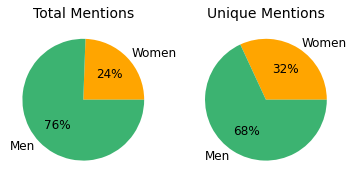

In [144]:
# Figure 2: percentage of men and women as experts

fig, ax = plt.subplots(1,2)
fig.patch.set_facecolor('white')

# total mentions
total = whole_qse['female_t'].sum() + whole_qse['male_t'].sum()
toplot = [whole_qse['female_t'].sum()/total, whole_qse['male_t'].sum()/total]
colors = ['orange','mediumseagreen']
sns.set_palette(sns.color_palette(colors))
ax[0].pie(toplot,labels=['Women','Men'],autopct='%.0f%%',textprops={'fontsize': 12})
ax[0].set_title('Total Mentions',fontsize=14)#,y=-.05)

# unique mentions
men = []
women = []
for i, x in whole_qse.iterrows():
    for person, gender in zip(ast.literal_eval(x.people),ast.literal_eval(x.gender_t)):
        if gender == 'male':
            men.append(person)
        elif gender == 'female':
            women.append(person)
men = list(set(men))
women = list(set(women))
total = len(men) + len(women)
toplot2 = [len(women)/total, len(men)/total]
ax[1].pie(toplot2,labels=['Women','Men'],autopct='%.0f%%', textprops={'fontsize': 12})
ax[1].set_title('Unique Mentions',fontsize=14) 
ax[1].title.set_position([0.5,-.8])

Difference in average sentence length
Average number of characters for sentences featuring men:  238.8378426984254
Average number of characters for sentences featuring women:  235.71453771289538
t-test:  Ttest_indResult(statistic=3.0461606415319764, pvalue=0.002319636323542075)
Presence of another expert
Percentage of sentences with expert women also featuring at least one expert man:  0.04641119221411192
Percentage of sentences with expert men also featuring at least on expert woman:  0.013288306290464392


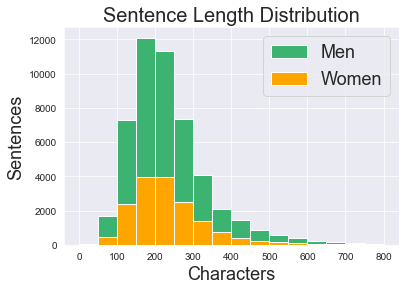

In [163]:
# Plotting the difference in sentence length

whole_qse["quote_length"] = whole_qse.quote.str.len()
any_men = whole_qse[whole_qse.male_t > 0]
any_women = whole_qse[whole_qse.female_t > 0]
more_men = whole_qse

plt.hist(any_men.quote_length.values,bins=[x for x in np.arange(0,850,50)],color="mediumseagreen",label="Men")
plt.hist(any_women.quote_length.values,bins=[x for x in np.arange(0,850,50)],color="orange",label="Women")
plt.title("Sentence Length Distribution",fontsize=20)
plt.xlabel("Characters",fontsize=18,)
plt.ylabel("Sentences",fontsize=18)
plt.legend(fontsize=18)

print("Difference in average sentence length")
print("Average number of characters for sentences featuring men: ",whole_qse[whole_qse.male_t > 0].quote.str.len().mean())
print("Average number of characters for sentences featuring women: ",whole_qse[whole_qse.female_t > 0].quote.str.len().mean())
print("t-test: ",scipy.stats.ttest_ind(a=any_men.quote_length, b=any_women.quote_length, equal_var = False))

print("Presence of another expert")
print("Percentage of sentences with expert women also featuring at least one expert man: ", whole_qse[whole_qse.female_t > 0].male_t.sum() / whole_qse[whole_qse.female_t > 0].shape[0])
print("Percentage of sentences with expert men also featuring at least on expert woman: ", whole_qse[whole_qse.male_t > 0].female_t.sum() / whole_qse[whole_qse.male_t > 0].shape[0])

In [ ]:
from random import sample, choices
import scipy

#
# BOOTSTRAPPING DATASET
#

n_resamples = 1000
whole_qse_bs = pd.DataFrame()
stat = pd.DataFrame()
stat_m = pd.DataFrame()
stat_w = pd.DataFrame()
stat_au = pd.DataFrame()
for outlet in ['HUFF','CNN','NYT','FOX','NYP','BREIT']:
    print(outlet)
    idxs = whole_qse[whole_qse.outlet == outlet].index.values
    sample_size = len(idxs)
    # manual bootstrap computation
    tempdf_total = pd.DataFrame()
    for i in np.arange(n_resamples):
        tempdf = whole_qse.loc[choices(list(idxs),k=sample_size)] # samples with replacement
        tempdf_total = tempdf_total.append([tempdf])
        tempprop = tempdf.female_t.sum() / tempdf.male_t.sum()
        stat = stat.append([[tempprop, outlet]])
    whole_qse_bs = whole_qse_bs.append([tempdf_total])
stat.index = np.arange(stat.shape[0])
stat.columns = ['avg','outlet']

# Statistics for percentage of quotees that are men
stat_ratio = pd.DataFrame()
for label in ['HUFF','CNN','NYT','FOX','NYP','BREIT']:
    stat_ratio = stat_ratio.append([[stat[stat.outlet == label].mean(axis=0).values[0], np.std(stat[stat.outlet == label].avg,axis=0), label]])
stat_ratio.index = np.arange(stat_ratio.shape[0])
stat_ratio.columns = ['mean','stddev','outlet']

In [167]:
whole_qse_bs = pd.read_csv("data/whole_qse_bs.csv")
stat_ratio = pd.read_csv("data/stat_ratio.csv")

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [168]:
## bootstrapping for organization type
n_resamples = 1000
sample_size = 1000
qse_bs = pd.DataFrame()

whole_qse_bs = pd.DataFrame()
stat_m = pd.DataFrame()
stat_w = pd.DataFrame()
stat_au = pd.DataFrame()
sample_size = whole_qse.shape[0]
for i in np.arange(n_resamples):
    tempdf = whole_qse.loc[choices(list(whole_qse.index.values),k=sample_size)]
    stat_m = stat_m.append([tempdf.male_t.sum()])
    stat_w = stat_w.append([tempdf.female_t.sum()])
    stat_au = stat_au.append([tempdf.andy_t.sum() + tempdf.unknown_t.sum()])
qse_bs = qse_bs.append([['whole', (stat_m/sample_size).mean().values[0], np.std(stat_m / sample_size).values[0],(stat_w/sample_size).mean().values[0], np.std(stat_w / sample_size).values[0],(stat_au/sample_size).mean().values[0], np.std(stat_au / sample_size).values[0]]])

whole_educ_bs = pd.DataFrame()
stat_m = pd.DataFrame()
stat_w = pd.DataFrame()
stat_au = pd.DataFrame()
sample_size = whole_educ.shape[0]
for i in np.arange(n_resamples):
    #tempdf = whole_educ.loc[sample(list(whole_educ.index.values),sample_size)]
    tempdf = whole_educ.loc[choices(list(whole_educ.index.values),k=sample_size)]
    stat_m = stat_m.append([tempdf.male_t.sum()])
    stat_w = stat_w.append([tempdf.female_t.sum()])
    stat_au = stat_au.append([tempdf.andy_t.sum() + tempdf.unknown_t.sum()])
qse_bs = qse_bs.append([['educ', (stat_m/sample_size).mean().values[0], np.std(stat_m / sample_size).values[0],(stat_w/sample_size).mean().values[0], np.std(stat_w / sample_size).values[0],(stat_au/sample_size).mean().values[0], np.std(stat_au / sample_size).values[0]]])

whole_gov_bs = pd.DataFrame()
stat_m = pd.DataFrame()
stat_w = pd.DataFrame()
stat_au = pd.DataFrame()
sample_size = whole_gov.shape[0]
for i in np.arange(n_resamples):
    #tempdf = whole_gov.loc[sample(list(whole_gov.index.values),sample_size)]
    tempdf = whole_gov.loc[choices(list(whole_gov.index.values),k=sample_size)]
    stat_m = stat_m.append([tempdf.male_t.sum()])
    stat_w = stat_w.append([tempdf.female_t.sum()])
    stat_au = stat_au.append([tempdf.andy_t.sum() + tempdf.unknown_t.sum()])
qse_bs = qse_bs.append([['gov', (stat_m/sample_size).mean().values[0], np.std(stat_m / sample_size).values[0],(stat_w/sample_size).mean().values[0], np.std(stat_w / sample_size).values[0],(stat_au/sample_size).mean().values[0], np.std(stat_au / sample_size).values[0]]])

whole_thinkt_bs = pd.DataFrame()
stat_m = pd.DataFrame()
stat_w = pd.DataFrame()
stat_au = pd.DataFrame()
sample_size = whole_thinkt.shape[0]
for i in np.arange(n_resamples):
    #tempdf = whole_thinkt.loc[sample(list(whole_thinkt.index.values),sample_size)]
    tempdf = whole_thinkt.loc[choices(list(whole_thinkt.index.values),k=sample_size)]
    stat_m = stat_m.append([tempdf.male_t.sum()])
    stat_w = stat_w.append([tempdf.female_t.sum()])
    stat_au = stat_au.append([tempdf.andy_t.sum() + tempdf.unknown_t.sum()])
qse_bs = qse_bs.append([['thinkt', (stat_m/sample_size).mean().values[0], np.std(stat_m / sample_size).values[0],(stat_w/sample_size).mean().values[0], np.std(stat_w / sample_size).values[0],(stat_au/sample_size).mean().values[0], np.std(stat_au / sample_size).values[0]]])

qse_bs.index = np.arange(4)
qse_bs.columns = ['type','mu_m','std_m','mu_w','std_w','mu_au','std_au']
qse_bs

,type,mu_m,std_m,mu_w,std_w,mu_au,std_au
0,whole,0.575650,0.001806,0.186128,0.001333,0.284451,0.001549
1,educ,0.585593,0.007144,0.246872,0.005844,0.207220,0.005533
2,gov,0.654966,0.004093,0.171459,0.003136,0.221527,0.003404
3,thinkt,0.527086,0.008226,0.208381,0.006328,0.303195,0.007399


Text(0.5, 1.0, 'Gender Composition by Organization Type')

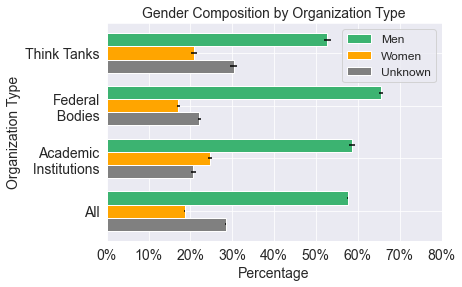

In [169]:
sns.set_style('darkgrid')
plt.barh(np.arange(4) + .25, qse_bs.mu_m,.25,label='Men',xerr = qse_bs.std_m, color = 'mediumseagreen')
plt.barh(np.arange(4), qse_bs.mu_w,.25,label='Women',xerr = qse_bs.std_w, color='orange')
plt.barh(np.arange(4) - .25, qse_bs.mu_au,.25,label='Unknown',xerr = qse_bs.std_au, color='gray')
plt.yticks(np.arange(4),['All','Academic\n Institutions','Federal\n Bodies','Think Tanks'],fontsize=14)
plt.xticks(np.arange(0,.9,.1),[str(i)+"%" for i in np.arange(0,90,10)],fontsize=14)
plt.ylabel("Organization Type",fontsize=14)
plt.xlabel("Percentage",fontsize=14)
plt.legend(fontsize=12)
plt.title("Gender Composition by Organization Type",fontsize=14)

Text(0.5, 1.0, 'Organization Affiliation by News Outlet')

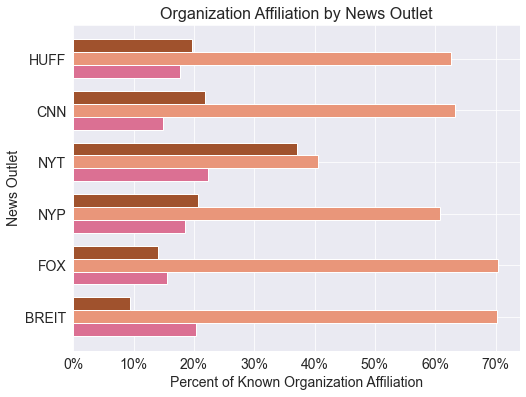

In [170]:
x = ["BREIT","FOX","NYP","NYT","CNN","HUFF"]
toplot = pd.DataFrame()
for l in x:
    educ_slice = whole_educ[whole_educ.outlet == l]
    gov_slice = whole_gov[whole_gov.outlet == l]
    thinkt_slice = whole_thinkt[whole_thinkt.outlet == l]
    total = educ_slice.shape[0] + gov_slice.shape[0] + thinkt_slice.shape[0]
    toplot = toplot.append(pd.DataFrame([[l,educ_slice.shape[0]/total,gov_slice.shape[0]/total,thinkt_slice.shape[0]/total]]))
toplot.columns = ['outlet','educ','gov','thinkt']
plt.figure(figsize=(8,6))
plt.barh(np.arange(6) - .25, toplot.thinkt,.25,label='Think \nTanks',color='palevioletred')
plt.barh(np.arange(6),toplot.gov,.25,label='Federal',color='darksalmon')
plt.barh(np.arange(6) + .25,toplot.educ,.25,label='Academic',color='sienna')
plt.yticks(np.arange(6),x,fontsize=14)
plt.xticks(np.arange(0,0.71,0.1),[str(i)+"%" for i in np.arange(0,80,10)],fontsize=14)
#plt.legend(fontsize=18,facecolor='white',framealpha=1)
plt.xlabel("Percent of Known Organization Affiliation",fontsize=14)
plt.ylabel("News Outlet",fontsize=14)
plt.title("Organization Affiliation by News Outlet",fontsize=16)

## IDEOLOGICAL BIAS

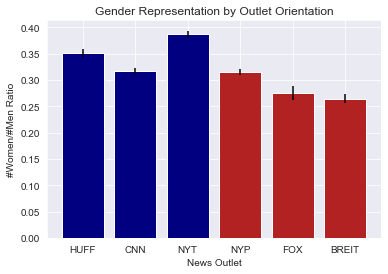

In [173]:
# Figure 5

def bar_plot(df, label = "Gender"):
    x = ["HUFF", "CNN", "NYT", "NYP", "FOX", "BREIT"]
    toplot = pd.DataFrame()
    toplot2 = pd.DataFrame()
    for l in x:
        df_slice = df[df.outlet == l]
        total = df_slice["male_t"].sum() + df_slice["female_t"].sum() + df_slice["andy_t"].sum()
        toplot = toplot.append(pd.DataFrame([[df_slice["male_t"].sum()/total, df_slice["female_t"].sum()/total, df_slice["andy_t"].sum()/total]],columns=["M","W","A"],index=[l]))
        toplot2 = toplot2.append(pd.DataFrame([[df_slice["female_t"].sum()/df_slice["male_t"].sum()]],index = [l],columns=['ratio']))
    plt.bar(x,toplot2.ratio,color=['navy','navy','navy','firebrick','firebrick','firebrick'],yerr=stat_ratio.stddev)
    #plt.legend()
    plt.xlabel("News Outlet")
    plt.ylabel("#Women/#Men Ratio")
    plt.title("Gender Representation by Outlet Orientation")
    return toplot2

outlet_ratios = bar_plot(whole_qse)

#print("Kruska-Wallis Test:")
#scipy.stats.kruskal(outlet_ratios.ratio.values,outlet_ratios.lean.values) 

## PRESTIGE BIAS

In [174]:
# Define gini coefficient
# https://www.statology.org/gini-coefficient-python/
# works on list of ranking 
import itertools

def gini(x):
    total = 0
    for i, xi in enumerate(x):
        total += np.sum(np.abs(xi - x[i:]))
    return total / (len(x)**2 * np.mean(x))

# gini coefficient from list of rankings
# i.e. if rank 1 has 2 citations and rank 2 has 3 citations,
# we take gini coeffieent of the list [1, 1, 2, 2, 2]
gini(np.array(list(itertools.chain.from_iterable([[i]*x.c_total for i, x in times15.iterrows()]))))

0.572648324077025

WITH ZERO COUNTS
Spearman corr:  SpearmanrResult(correlation=-0.33783331020120494, pvalue=3.669658748258977e-12)
Gini:  0.5683412384257613
Pearson corr:  (-0.33340025731434475, 7.255545535972892e-12)
WITHOUT ZERO COUNTS
Spearman corr:  SpearmanrResult(correlation=-0.3785622753485839, pvalue=1.885405592101747e-07)
Gini:  0.5683412384257613
Pearson corr: (-0.34190808347937807, 2.996866560557945e-06)


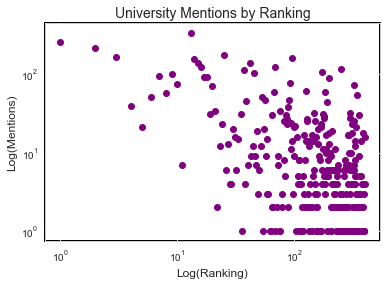

In [175]:
from scipy.stats import pearsonr

N = 401
fig, ax = plt.subplots()
nozeroes = times15.loc[times15.c_total > 0]
ax.scatter(nozeroes.index,nozeroes.c_total,color='purple')
ax.set_facecolor('white')
ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth('2')  

plt.xlabel("Log(Ranking)",fontsize=12)
plt.ylabel("Log(Mentions)",fontsize=12)
plt.title("University Mentions by Ranking",fontsize=14)
ax.set_yscale('log')
ax.set_xscale('log')

print("WITH ZERO COUNTS")
rank_cit = pd.DataFrame([times15.index.values,times15.c_huff.values]).T
rank_cit.columns = ['rank_', 'citations']
print("Spearman corr: ",scipy.stats.spearmanr(rank_cit.rank_.values,rank_cit.citations.values))
print("Gini: ",gini(np.array(list(itertools.chain.from_iterable([[i]*x.citations for i, x in rank_cit.iterrows()])))))
print("Pearson corr: ",scipy.stats.pearsonr(rank_cit.rank_.values,rank_cit.citations.values))

rank_cit = rank_cit[rank_cit.citations > 0]
print("WITHOUT ZERO COUNTS")
print("Spearman corr: ",scipy.stats.spearmanr(rank_cit.rank_.values,rank_cit.citations.values))
rank_cit
print("Gini: ",gini(np.array(list(itertools.chain.from_iterable([[i]*x.citations for i, x in rank_cit.iterrows()])))))
print("Pearson corr:",pearsonr(rank_cit.rank_.values,rank_cit.citations))

LEFT-LEANING
Gini:  0.5733573852149372
WITH ZERO COUNTS
Spearman corr:  SpearmanrResult(correlation=-0.43867058465249653, pvalue=2.7343489110422166e-20)
Pearson corr:  (-0.3768467431848862, 5.598299175763653e-15)
WITHOUT ZERO COUNTS
Spearman corr:  SpearmanrResult(correlation=-0.43867058465249653, pvalue=2.7343489110422166e-20)
Pearson corr: (-0.3768467431848862, 5.598299175763653e-15)

RIGHT-LEANING
Gini:  0.5616452371823026
WITH ZERO COUNTS
Spearman corr:  SpearmanrResult(correlation=-0.3168174925608485, pvalue=8.444760134134967e-11)
Pearson corr:  (-0.3228167147568172, 3.535446830337589e-11)
WITHOUT ZERO COUNTS
Spearman corr:  SpearmanrResult(correlation=-0.3168174925608485, pvalue=8.444760134134967e-11)
Pearson corr: (-0.3228167147568172, 3.535446830337589e-11)


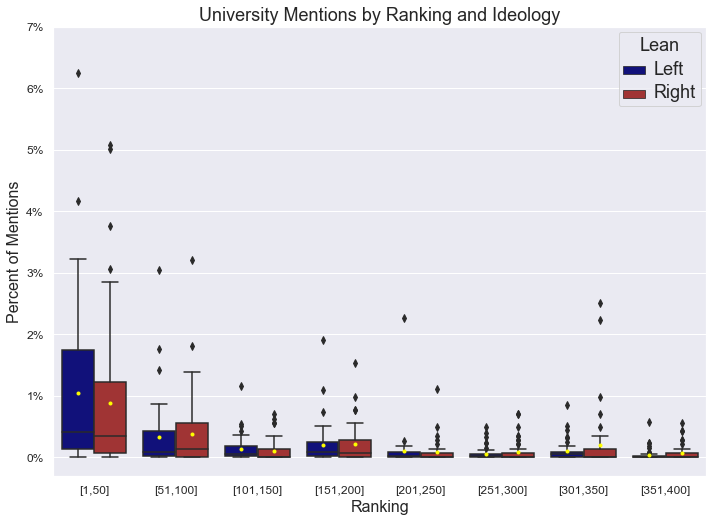

In [176]:
#N = 401
#fig, ax = plt.subplots()
#for i, x in times15.iterrows():
    #if i in [1,13,68,3,25,95,172,249,347,323]:
    #    plt.text(x=i+1, y=x.c_breit + x.c_nyp + x.c_fox, s=x.university_name)
    #plt.text(x=i+1, y=x.c_breit + x.c_nyp + x.c_fox, s=i)

print("LEFT-LEANING")
left_cit = pd.DataFrame([times15.index.values,times15.c_huff.values + times15.c_cnn.values + times15.c_nyt.values]).T
left_cit.columns = ['rank_', 'citations']
left_cit['citations_norm'] = left_cit.citations / left_cit.citations.sum()
print("Gini: ",gini(np.array(list(itertools.chain.from_iterable([[i]*int(x.citations) for i, x in left_cit.iterrows()])))))
print("WITH ZERO COUNTS")
print("Spearman corr: ",scipy.stats.spearmanr(left_cit.rank_.values,left_cit.citations.values))
print("Pearson corr: ",scipy.stats.pearsonr(left_cit.rank_.values,left_cit.citations.values))
#left_cit = left_cit[left_cit.citations > 0]
print("WITHOUT ZERO COUNTS")
print("Spearman corr: ",scipy.stats.spearmanr(left_cit.rank_.values,left_cit.citations.values))
print("Pearson corr:",pearsonr(left_cit.rank_.values,left_cit.citations))

print("\nRIGHT-LEANING")
right_cit = pd.DataFrame([times15.index.values,times15.c_breit.values + times15.c_fox.values + times15.c_nyp.values]).T
right_cit.columns = ['rank_', 'citations']
right_cit['citations_norm'] = right_cit.citations / right_cit.citations.sum()
print("Gini: ",gini(np.array(list(itertools.chain.from_iterable([[int(i)]*int(x.citations) for i, x in right_cit.iterrows()])))))
print("WITH ZERO COUNTS")
print("Spearman corr: ",scipy.stats.spearmanr(right_cit.rank_.values,right_cit.citations.values))
print("Pearson corr: ",scipy.stats.pearsonr(right_cit.rank_.values,right_cit.citations.values))
#right_cit = right_cit[right_cit.citations > 0]
print("WITHOUT ZERO COUNTS")
print("Spearman corr: ",scipy.stats.spearmanr(right_cit.rank_.values,right_cit.citations.values))
print("Pearson corr:",pearsonr(right_cit.rank_.values,right_cit.citations))

left_cit2 = left_cit.copy()
left_cit2.columns = ['rank_', 'citations', 'norm']
left_cit2["Lean"] = "Left"
right_cit2 = right_cit.copy()
right_cit2.columns = ['rank_', 'citations', 'norm']
right_cit2["Lean"] = "Right"
lean_cit2 = pd.concat([left_cit2,right_cit2])
colors = ['darkblue','firebrick']
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_palette(sns.color_palette(colors))

left_cit2["bin"] = 0
right_cit2["bin"] = 0
for i in np.arange(0,8):
    if i == 0:
        lean_cit2.loc[np.arange(i*50,50+i*50),"bin"] = i
        left_cit2.loc[np.arange(i*50,50+i*50),"bin"] = i
        right_cit2.loc[np.arange(i*50,50+i*50),"bin"] = i
    else:
        lean_cit2.loc[np.arange(1+i*50,50+i*50),"bin"] = i
        left_cit2.loc[np.arange(1+i*50,50+i*50),"bin"] = i
        right_cit2.loc[np.arange(1+i*50,50+i*50),"bin"] = i


bins_names = ["[1,50]","[51,100]","[101,150]","[151,200]","[201,250]","[251,300]","[301,350]","[351,400]"]
p = sns.boxplot(y='norm',x='bin',data=lean_cit2,hue='Lean',showmeans=True,meanprops={"marker":".","markerfacecolor":"yellow", "markeredgecolor":"yellow"})#,split=False)
p.set_xlabel("Ranking",fontsize=16)
p.set_ylabel("Percent of Mentions",fontsize=16)
plt.xticks(np.arange(8),bins_names,fontsize=12)
#plt.yticks(np.arange(0,0.07,0.01),["0%","1%","2%","3%","4%","5%","6%","7%"],fontsize=12)
plt.title("University Mentions by Ranking and Ideology", fontsize=18)
plt.setp(p.get_legend().get_title(), fontsize=18)
plt.setp(p.get_legend().get_texts(), fontsize=18)
plt.yticks(np.arange(0,0.07,0.01),["0%","1%","2%","3%","4%","5%","6%","7%"],fontsize=12)

means_left = left_cit2.groupby(['bin']).mean().norm
means_right = right_cit2.groupby(['bin']).mean().norm


In [177]:
# Ranking of mentions of women
# Re-calculate according to gender

times15["c_total_f"] = 0; times15["c_breit_f"] = 0; times15["c_nyp_f"] = 0; times15["c_fox_f"] = 0;
times15["c_cnn_f"] = 0; times15["c_nyt_f"] = 0; times15["c_huff_f"] = 0# introduce column to count university mentions
for i, x in times15.iterrows():
    univ = x.university_name
    total = 0
    for l in ["BREIT","NYP","FOX","CNN","NYT","HUFF"]:
        df_slice = whole_educ_clean[whole_educ_clean.outlet == l]
        df_slice = df_slice[df_slice.educ_inst.str.contains(univ)]
        df_slice = df_slice[df_slice["female_t"] > 0]
        times15.loc[i,"c_"+l.lower()+"_f"] = df_slice.shape[0]
        total += df_slice.shape[0]
    times15.loc[i,"c_total_f"] = total
times15["c_total_m"] = 0; times15["c_breit_m"] = 0; times15["c_nyp_m"] = 0; times15["c_fox_m"] = 0;
times15["c_cnn_m"] = 0; times15["c_nyt_m"] = 0; times15["c_huff_m"] = 0# introduce column to count university mentions
for i, x in times15.iterrows():
    univ = x.university_name
    total = 0
    for l in ["BREIT","NYP","FOX","CNN","NYT","HUFF"]:
        df_slice = whole_educ_clean[whole_educ_clean.outlet == l]
        df_slice = df_slice[df_slice.educ_inst.str.contains(univ)]
        df_slice = df_slice[df_slice["male_t"] > 0]
        times15.loc[i,"c_"+l.lower()+"_m"] = df_slice.shape[0]
        total += df_slice.shape[0]
    times15.loc[i,"c_total_m"] = total

print("WOMEN")
women_cit = pd.DataFrame([times15.index.values,times15.c_total_f.values]).T
women_cit.columns = ['rank_', 'citations']
women_cit["citations_norm"] = women_cit.citations / women_cit.citations.sum()
print("Gini: ",gini(np.array(list(itertools.chain.from_iterable([[int(i)]*int(x.citations) for i, x in women_cit.iterrows()])))))
print("WITH ZERO COUNTS")
print("Spearman corr: ",scipy.stats.spearmanr(women_cit.rank_.values,women_cit.citations.values))
print("Pearson corr: ",scipy.stats.pearsonr(women_cit.rank_.values,women_cit.citations.values))
#women_cit = women_cit[women_cit.citations > 0]
print("WITHOUT ZERO COUNTS")
print("Spearman corr: ",scipy.stats.spearmanr(women_cit.rank_.values,women_cit.citations.values))
print("Pearson corr:",pearsonr(women_cit.rank_.values,women_cit.citations))

print("\nMEN")
men_cit = pd.DataFrame([times15.index.values,times15.c_total_m.values]).T
men_cit.columns = ['rank_', 'citations']
men_cit["citations_norm"] = men_cit.citations / men_cit.citations.sum()
print("Gini: ",gini(np.array(list(itertools.chain.from_iterable([[int(i)]*int(x.citations) for i, x in men_cit.iterrows()])))))
print("WITH ZERO COUNTS")
print("Spearman corr: ",scipy.stats.spearmanr(men_cit.rank_.values,men_cit.citations.values))
print("Pearson corr: ",scipy.stats.pearsonr(men_cit.rank_.values,men_cit.citations.values))
#men_cit = men_cit[men_cit.citations > 0]
print("WITHOUT ZERO COUNTS")
print("Spearman corr: ",scipy.stats.spearmanr(men_cit.rank_.values,men_cit.citations.values))
print("Pearson corr:",pearsonr(men_cit.rank_.values,men_cit.citations))


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


WOMEN
Gini:  0.559512867961588
WITH ZERO COUNTS
Spearman corr:  SpearmanrResult(correlation=-0.40904374687477585, pvalue=1.3179556044131033e-17)
Pearson corr:  (-0.35306501485517633, 3.2418895452492115e-13)
WITHOUT ZERO COUNTS
Spearman corr:  SpearmanrResult(correlation=-0.40904374687477585, pvalue=1.3179556044131033e-17)
Pearson corr: (-0.35306501485517633, 3.2418895452492115e-13)

MEN
Gini:  0.5718515078519029
WITH ZERO COUNTS
Spearman corr:  SpearmanrResult(correlation=-0.3972353880389898, pvalue=1.3100534823701557e-16)
Pearson corr:  (-0.364123142767776, 5.120593947515351e-14)
WITHOUT ZERO COUNTS
Spearman corr:  SpearmanrResult(correlation=-0.3972353880389898, pvalue=1.3100534823701557e-16)
Pearson corr: (-0.364123142767776, 5.120593947515351e-14)


Text(0.5, 1.0, '100 Highest Ranked Universities as Percent of Total Mentions')

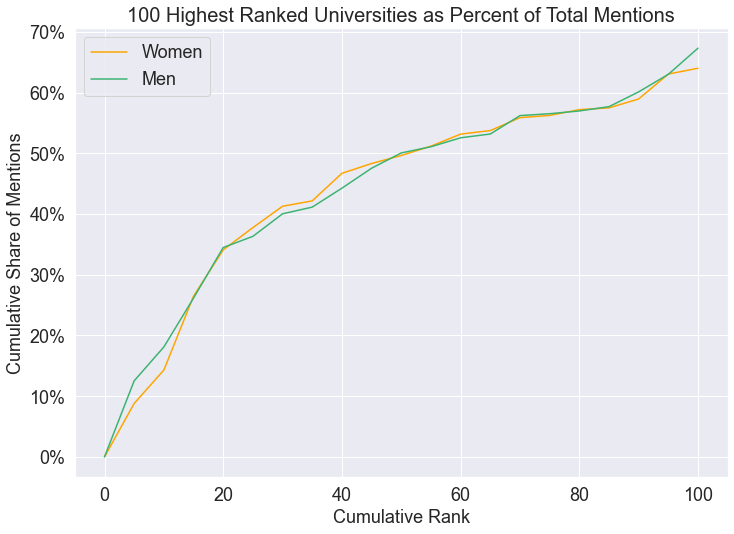

In [178]:
cumulative_pct = pd.DataFrame()
for n in np.arange(0,105,5):
    cumulative_pct = cumulative_pct.append([[n,women_cit[:n].citations_norm.sum(),men_cit[:n].citations_norm.sum(),women_cit[:n].citations.sum(), men_cit[:n].citations.sum()]])
cumulative_pct.index = np.arange(cumulative_pct.shape[0])
cumulative_pct.columns = ['n','pct_w','pct_m','sum_w','sum_m']
#cumulative_pct = cumulative_pct[1:]

plt.plot(cumulative_pct.n,cumulative_pct.pct_w, color='orange', label = 'Women')
plt.plot(cumulative_pct.n,cumulative_pct.pct_m, color='mediumseagreen', label = 'Men')
plt.legend(fontsize=18)
plt.xlabel("Cumulative Rank",fontsize=18)
plt.ylabel("Cumulative Share of Mentions",fontsize=18)
plt.yticks(np.arange(0.0,.75,0.1),[str(k)+"%" for k in np.arange(0,75,10)],fontsize=18)
plt.xticks(fontsize=18)
plt.title("100 Highest Ranked Universities as Percent of Total Mentions",fontsize=20)

[None, None, None, None]

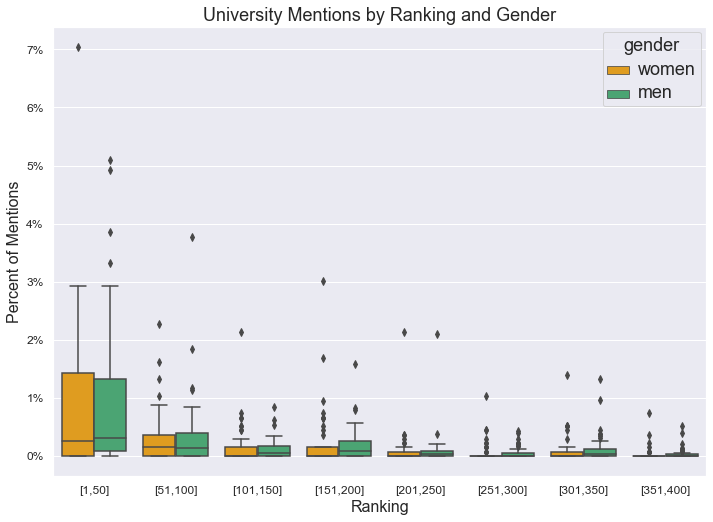

In [179]:
women_cit2 = women_cit.copy()
women_cit2.columns = ['rank_', 'citations', 'norm']
women_cit2["gender"] = 'women'
men_cit2 = men_cit.copy()
men_cit2.columns = ['rank_', 'citations', 'norm']
men_cit2["gender"] = 'men'
gender_cit2 = pd.concat([women_cit2,men_cit2])
colors = ['orange','mediumseagreen','violet']
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_palette(sns.color_palette(colors))

gender_cit2["bin"] = 0
for i in np.arange(0,8):
    if i == 0:
        gender_cit2.loc[np.arange(i*50,50+i*50),"bin"] = i
    else:
        gender_cit2.loc[np.arange(1+i*50,50+i*50),"bin"] = i


bins_names = ["[1,50]","[51,100]","[101,150]","[151,200]","[201,250]","[251,300]","[301,350]","[351,400]"]
p = sns.boxplot(y='norm',x='bin',data=gender_cit2,hue='gender')
p.set_xlabel("Ranking",fontsize=16)
p.set_ylabel("Percent of Mentions",fontsize=16)
plt.xticks(np.arange(8),bins_names,fontsize=12)
plt.yticks(np.arange(0,0.07,0.01),["0%","1%","2%","3%","4%","5%","6%","7%"],fontsize=12)
plt.title("University Mentions by Ranking and Gender", fontsize=18)
plt.setp(p.get_legend().get_title(), fontsize=18)
plt.setp(p.get_legend().get_texts(), fontsize=18)


# END

In [18]:
# get statistics 
stat_ratio2 = pd.DataFrame()
for label in ['HUFF','CNN','NYT','FOX','NYP','BREIT']:
    df_slice = whole_qse_bs[whole_qse_bs.outlet == label].copy()
    df_slice.index = np.arange(10000)
    for i in np.arange(10):
        sliceofslice = df_slice[i*1000:((i+1)*1000)]
        toappend = [label, i, sliceofslice.female_t.sum() / sliceofslice.male_t.sum()]
        stat_ratio2 = stat_ratio2.append([toappend])
stat_ratio2.index = np.arange(stat_ratio2.shape[0])
stat_ratio2.columns = ['outlet','iter','ratio']
left_std = np.std(stat_ratio2.ratio[:31])
right_std = np.std(stat_ratio2.ratio[31:])

stat_ratio2['group'] = 'right'
stat_ratio2.loc[stat_ratio2.outlet.isin(['HUFF','NYT','CNN']),'group'] = 'left'

scipy.stats.ttest_ind(a=stat_ratio2[stat_ratio2.group == 'left'].ratio, b = stat_ratio2[stat_ratio2.group == 'right'].ratio)

AttributeError: 'DataFrame' object has no attribute 'outlet'

Text(0.5, 1.0, 'Gender Composition by Organization Type')

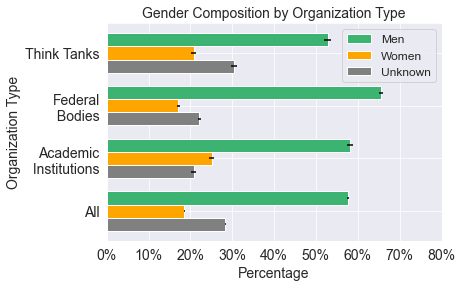

In [218]:
sns.set_style('darkgrid')
plt.barh(np.arange(4) + .25, qse_bs.mu_m,.25,label='Men',xerr = qse_bs.std_m, color = 'mediumseagreen')
plt.barh(np.arange(4), qse_bs.mu_w,.25,label='Women',xerr = qse_bs.std_w, color='orange')
plt.barh(np.arange(4) - .25, qse_bs.mu_au,.25,label='Unknown',xerr = qse_bs.std_au, color='gray')
plt.yticks(np.arange(4),['All','Academic\n Institutions','Federal\n Bodies','Think Tanks'],fontsize=14)
plt.xticks(np.arange(0,.9,.1),[str(i)+"%" for i in np.arange(0,90,10)],fontsize=14)
plt.ylabel("Organization Type",fontsize=14)
plt.xlabel("Percentage",fontsize=14)
plt.legend(fontsize=12)
plt.title("Gender Composition by Organization Type",fontsize=14)

In [846]:
scipy.stats.kruskal(pd.DataFrame([qse_bs.mu_w / qse_bs.mu_m]).values[0],[0,1,2,3]) # finding is a moderate effect

KruskalResult(statistic=1.3333333333333321, pvalue=0.2482130789899204)

In [118]:
verb_count_m = pd.DataFrame([reporting_verbs, [0] * len(reporting_verbs)]).T
verb_count_m.columns = ['verb','counts']
verb_count_f = pd.DataFrame([reporting_verbs, [0] * len(reporting_verbs)]).T
verb_count_f.columns = ['verb','counts']

for i, x in verb_count_m.iterrows():
    verb_count_f.loc[i,'counts'] += whole_qse.loc[whole_qse.quote.str.contains(x.verb)].female_t.sum()
    verb_count_m.loc[i,'counts'] += whole_qse.loc[whole_qse.quote.str.contains(x.verb)].male_t.sum()


Women


,verb,counts
221,said,13020
230,state,1970
222,say,1886
241,told,1203
228,spoke,1004
205,report,860
224,says,831
10,add,724
246,think,614
223,saying,541


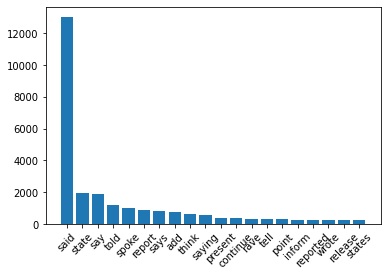

In [921]:
n = 20
sort_counts = verb_count_f.sort_values(by='counts', ascending=False)[:n]
plt.bar(sort_counts.verb, sort_counts.counts)
plt.xticks(rotation=45)
print("Women")
sort_counts

Men


,verb,counts
221,said,39658
222,say,6595
230,state,6322
241,told,3738
205,report,2740
10,add,2590
223,saying,2450
224,says,2447
228,spoke,1963
246,think,1830


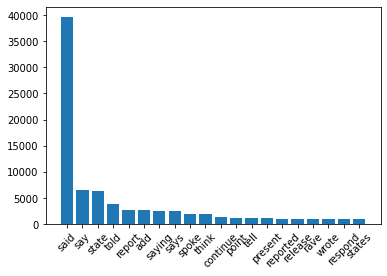

In [922]:
n = 20
sort_counts = verb_count_m.sort_values(by='counts', ascending=False)[:n]
plt.bar(sort_counts.verb, sort_counts.counts)
plt.xticks(rotation=45)
print("Men")
sort_counts

In [ ]:
x = ["BREIT","FOX","NYP","NYT","CNN","HUFF"]
toplot = pd.DataFrame()
for label in x:
    df_slice = whole_qse_bs[whole_qse_bs.outlet == label]
    toplot = toplot.append(pd.DataFrame([[df_slice["male_t"].sum(), df_slice["female_t"].sum(), df_slice["andy_t"].sum() + df_slice["unknown_t"].sum()]]))
toplot.columns = ['Men', 'Women', 'Unknown']
plt.barh(np.arange(6) - .25,toplot.Men,.25,color='mediumseagreen',label='Men')
plt.barh(np.arange(6),toplot.Women,.25,color='orange',label='Women')
plt.barh(np.arange(6) + .25, toplot.Unknown,.25, color='gray',label='Unknown')
plt.yticks(np.arange(6),x)
plt.xticks(np.arange(0,700,100),[str(i)+"%" for i in np.arange(0,70,10)])
plt.legend()
plt.title("Gender Composition by Organization Type")
stat_whole

In [216]:
whole_qse[whole_qse.male_t > 0].female_t.sum() / whole_qse[whole_qse.male_t > 0].shape[0]

0.013288306290464392

In [225]:
# compute sample and population proportions
pop_prop = whole_qse[whole_qse.male_t > 0].shape[0] / whole_qse.shape[0]
sample_prop =  whole_qse_bs[ whole_qse_bs.male_t > 0].shape[0] /  whole_qse_bs.shape[0]
print("Population proportion: ",pop_prop)
print("Sample proportion :",sample_prop)

# compute statistic per-row
whole_qse_bs['stat'] = whole_qse_bs.loc[:,['male_t']].sum(axis=1) / whole_qse_bs.loc[:,['male_t','female_t','andy_t']].sum(axis=1)
whole_qse_bs['stat'] = whole_qse_bs['stat'].fillna(0)

# 95% confidence interval
median = np.percentile(whole_qse_bs['stat'], 50)
print("Median proportion of men represented ",median)
alpha = .05
lower_ci = np.percentile(whole_qse_bs['stat'], alpha/2)
upper_ci = np.percentile(whole_qse_bs['stat'], 100 - alpha/2)
print("Interval of ["+str(lower_ci)+"," +str(upper_ci)+"]")

Population proportion:  0.5626268709986839
Sample proportion : 0.5665555555555556
Median proportion of men represented  1.0
Interval of [0.0,1.0]


In [327]:
# compute sample and population proportions
pop_prop = whole_qse[whole_qse.male_t > 0].shape[0] / whole_qse.shape[0]
sample_prop =  whole_qse_bs[ whole_qse_bs.male_t > 0].shape[0] /  whole_qse_bs.shape[0]
print(pop_prop, sample_prop)

0.5626268709986839 0.579


## Data Analysis

In [1559]:
whole_qse = get_genders_total(whole_qse)
whole_educ = get_genders_total(whole_educ)
whole_gov = get_genders_total(whole_gov)
whole_thinkt = get_genders_total(whole_thinkt)

In [98]:
# Get all universities, not just ranked
times15 = pd.read_csv('data/timesData-2015rankings.csv')
alluniversities = 'University|Institute|Laboratory|College|Università|Universidad|Institut|university|institute|laboratory|college|università|universidad|institut'
whole_educ_all = whole_qse[whole_qse.orgs.str.contains(alluniversities)].drop(columns=['source','gender'])
# get instances matching to a university, and those not matching to a university
whole_educ_all, missed = match_org_test(whole_educ_all, times15.university_name.unique(), 90)
unranked_orgs = missed["orgs"].str.replace("[","").str.replace("]","").str.replace("'","").apply(pd.Series).stack().unique() 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  import sys


2336

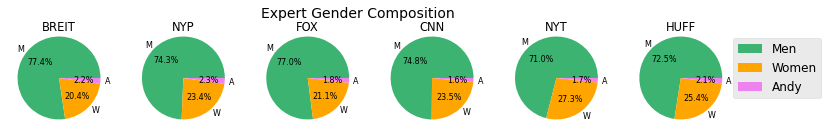

/usr/local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1616: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  results = ax.pie(y, labels=blabels, **kwds)


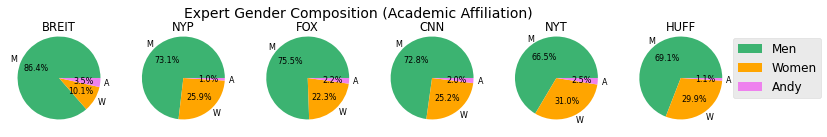

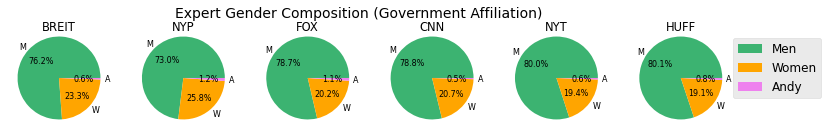

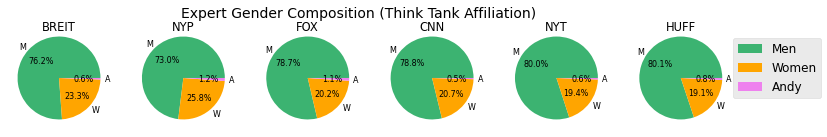

In [554]:
plot_multi_bygender_h(whole_qse,label="Expert Gender Composition")
plot_multi_bygender_h(whole_educ,label="Expert Gender Composition (Academic Affiliation)")
plot_multi_bygender_h(whole_gov,label="Expert Gender Composition (Government Affiliation)")
plot_multi_bygender_h(whole_gov,label="Expert Gender Composition (Think Tank Affiliation)")

Text(0.5, 0.98, 'Gender Composition by Organization Type')

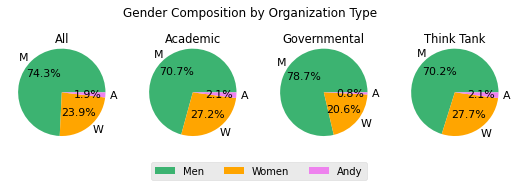

In [558]:
fig, axes = plt.subplots(1,4,figsize=(9,2.5))
label = "dictionary"
title_dict = {0: "All", 1: "Academic", 2:"Governmental", 3:"Think Tank"}
for i, df in enumerate([whole_qse,whole_educ,whole_gov,whole_thinkt]):
    total = df["male_t"].sum() + df["female_t"].sum() + df["andy_t"].sum()
    toplot = [df["male_t"].sum()/total, df["female_t"].sum()/total, df["andy_t"].sum()/total]
    pd.DataFrame(toplot).plot(kind='pie',fontsize=11,labels=["M","W","A"],autopct='%1.1f%%',subplots=True,ax = axes[i],colors=['mediumseagreen','orange','violet'])
    axes[i].get_legend().remove()
    axes[i].set(ylabel='')
    axes[i].set_title(title_dict[i],y=.9)
fig.legend(["Men","Women","Andy"],ncol=3,loc=8,fontsize=10)
fig.suptitle("Gender Composition by Organization Type",fontsize = 12)

In [217]:
freq_unknown = pd.DataFrame()
temp_qse = get_genders_total(whole_qse)# usedict = True)
for outlet in ['HUFF','NYT','CNN','NYP','FOX','BREIT']:
    slice_df = whole_qse.loc[(whole_qse.outlet.str.contains(outlet)) & (whole_qse.andy_t > 0)]
    freq_unknown = freq_unknown.append([slice_df.value_counts('people')[:25]])
freq_unknown.index = np.arange(6)
freq_unknown = freq_unknown.T
freq_unknown.columns = ['HUFF','NYT','CNN','NYP','FOX','BREIT']
freq_unknown['total'] = freq_unknown.fillna(0).sum(axis=1) 
freq_unknown.sort_values(by='total',ascending=False)#[15:]

KeyboardInterrupt: 

Text(0.5, 0.98, 'Gender Composition by Organization Type')

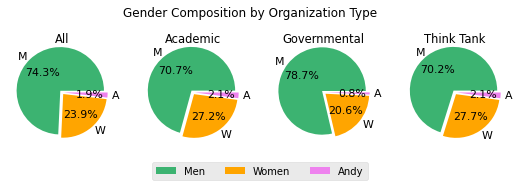

In [559]:
fig, axes = plt.subplots(1,4,figsize=(9,2.5))
label = "dictionary"
title_dict = {0: "All", 1: "Academic", 2:"Governmental", 3:"Think Tank"}
for i, df in enumerate([whole_qse,whole_educ,whole_gov,whole_thinkt]):
    total = df["male_t"].sum() + df["female_t"].sum() + df["andy_t"].sum()
    toplot = [df["male_t"].sum()/total, df["female_t"].sum()/total, df["andy_t"].sum()/total]
    pd.DataFrame(toplot).plot(kind='pie',fontsize=11,labels=["M","W","A"],autopct='%1.1f%%',subplots=True,ax = axes[i],colors=['mediumseagreen','orange','violet'],explode=(0.05, 0.05, 0.05))
    axes[i].get_legend().remove()
    axes[i].set(ylabel='')
    axes[i].set_title(title_dict[i],y=.9)
fig.legend(["Men","Women","Andy"],ncol=3,loc=8,fontsize=10)
fig.suptitle("Gender Composition by Organization Type",fontsize = 12)

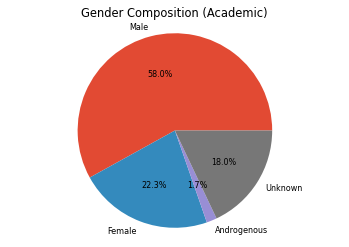

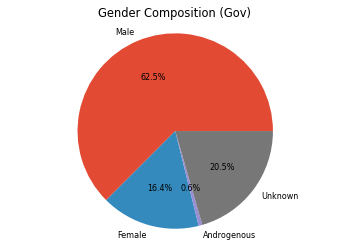

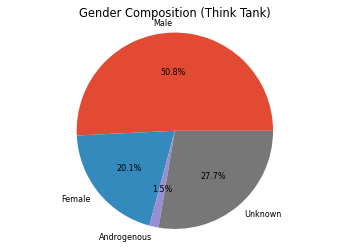

,idx,idx.1,quote,people,orgs,outlet,method,org,gender_t,male_t,female_t,unknown_t,andy_t
0,12,16.0,"""There’s no playbook for how you cover sports when sports are not being played,""",['Randal Archibold'],Sports Think Tank,NYT,DEP,NaN,['male'],1,0,0,0
1,13,16.0,"""wouldn’t have been newsworthy before suddenly became interesting,""",['Mather' 'Danielle Allentuck'],Sports Think Tank,NYT,DEP,NaN,['unknown'],0,0,1,0
2,32,42.0,"""International students are generally the group most concerned about the motherland among overseas Chinese,""",['Gao Cheng'],Chinese Academy of Sciences,NYT,DEP,NaN,['andy'],0,0,0,1
3,34,56.0,"""Road Map to Reopening,""",['Scott Gottlieb'],American Enterprise Institute,NYT,DEP,NaN,['male'],1,0,0,0
4,35,56.0,"""sustained reduction in cases for at least 14 days,""",['Scott Gottlieb'],American Enterprise Institute,NYT,DEP,NaN,['male'],1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4340,5296,5296.0,"['Bowman said his district is demanding change” and even took a parting shot at Amazon’s Jeff Bezos on Tuesday evening, saying Bezos and other billionaires who have only seen their wealth increase during the coronavirus pandemic represent everything that is wrong with country’s economic system.']",['Bezos'],NaN,BREIT,NER,Amazon Environmental Research Institute,['unknown'],0,0,1,0
4341,5330,5330.0,"['Disney cut funding to Carlson because they want to protect their pipeline of cheap workers, not because of Carlson’s future statements on the future Black Lives debate, said John Miano, a lawyer with the Immigration Law Reform Institute.']",['John Miano'],NaN,BREIT,NER,Reform,['male'],1,0,0,0
4342,5377,5377.0,"['Johann Wadephul, the deputy leader of Angela Merkel’s CDU/CSU parliamentary group in the Bundestag, said that the decision by President Trump will serve to weaken the Western alliance, despite the President’s stated goal of strengthening the military power of NATO.']",['Trump'],NaN,BREIT,NER,Women's Coordinator,['male'],1,0,0,0
4343,5434,5434.0,"['Berenson told Breitbart News that his book,\xa0Unreported Truths About COVID-19 And Lockdowns Part 1: Introductions and Death Counts and Estimates,\xa0was merely “an introduction and a discussion of death coding, death counts, and who is really dying from COVID, as well as a worst-case estimate of deaths with no mitigation efforts.”\n\n“I briefly considered censorship but assumed I wouldn’t have a problem both because of my background, because anyone who reads the booklet will realize it is impeccably sourced, nary a conspiracy theory to be found, and frankly because Amazon shouldn’t be censoring anything that doesn’t explicitly help people commit criminal behavior.”\n\nAmazon spokeswoman Sarah Elison now says the book was removed in error, according to the\xa0Washington Post.']",['Sarah Elison'],NaN,BREIT,NER,Amazon Environmental Research Institute,['female'],0,1,0,0


In [560]:
plot_total_bygender(whole_educ,"Gender Composition (Academic)")
plot_total_bygender(whole_gov,"Gender Composition (Gov)")
plot_total_bygender(whole_thinkt,"Gender Composition (Think Tank)")

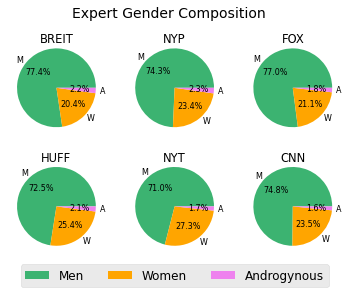

/usr/local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1616: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  results = ax.pie(y, labels=blabels, **kwds)


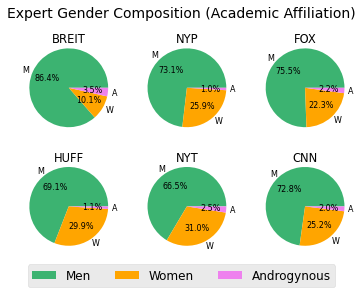

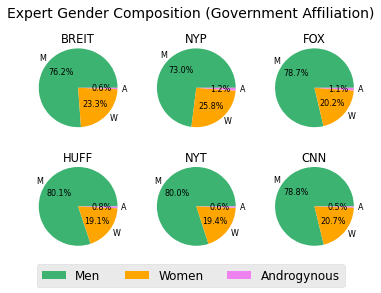

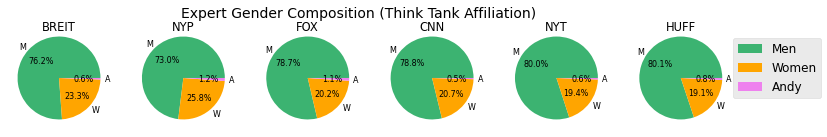

In [561]:
plot_multi_bygender(whole_qse,label="Expert Gender Composition")
plot_multi_bygender(whole_educ,label="Expert Gender Composition (Academic Affiliation)")
plot_multi_bygender(whole_gov,label="Expert Gender Composition (Government Affiliation)")
plot_multi_bygender2(whole_gov,label="Expert Gender Composition (Think Tank Affiliation)")

0.23968614077424388

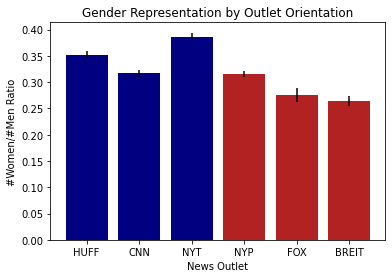

In [74]:
def bar_plot(df, label = "Gender"):
    x = ["HUFF", "CNN", "NYT", "NYP", "FOX", "BREIT"]
    toplot = pd.DataFrame()
    toplot2 = pd.DataFrame()
    for l in x:
        df_slice = df[df.outlet == l]
        total = df_slice["male_t"].sum() + df_slice["female_t"].sum() + df_slice["andy_t"].sum()
        toplot = toplot.append(pd.DataFrame([[df_slice["male_t"].sum()/total, df_slice["female_t"].sum()/total, df_slice["andy_t"].sum()/total]],columns=["M","W","A"],index=[l]))
        toplot2 = toplot2.append(pd.DataFrame([[df_slice["female_t"].sum()/df_slice["male_t"].sum()]],index = [l],columns=['ratio']))
    plt.bar(x,toplot2.ratio,color=['navy','navy','navy','firebrick','firebrick','firebrick'],yerr=stat_ratio.stddev)
    #plt.legend()
    plt.xlabel("News Outlet")
    plt.ylabel("#Women/#Men Ratio")
    #plt.yticks(np.arange(0,1.1,.1))
    
    #for i, v in enumerate(toplot2.ratio):
    #    plt.text(i-.2, v + .02, str(v)[:4], color='black', fontweight='bold')

    plt.title("Gender Representation by Outlet Orientation")
    return toplot2

outlet_ratios = bar_plot(whole_qse)

whole_qse['female_t'].sum() / (whole_qse['female_t'].sum() + whole_qse['male_t'].sum() + whole_qse['andy_t'].sum())

In [56]:
whole_qse[whole_qse.outlet == 'BREIT'].to_csv("breit_all.csv")
whole_qse[whole_qse.outlet == 'BREIT'].people.value_counts().to_csv("breit_all_valuecounts.csv")
whole_educ[whole_educ.outlet == 'BREIT'].to_csv("breit_educ.csv")
whole_educ[whole_educ.outlet == 'BREIT'].people.value_counts().to_csv("breit_educ_valuecounts.csv")
whole_gov[whole_gov.outlet == 'BREIT'].to_csv("breit_gov.csv")
whole_gov[whole_gov.outlet == 'BREIT'].people.value_counts().to_csv("breit_gov_valuecounts.csv")
whole_thinkt[whole_thinkt.outlet == 'BREIT'].to_csv("breit_thinkt.csv")
whole_thinkt[whole_thinkt.outlet == 'BREIT'].people.value_counts().to_csv("breit_thinkt_valuecounts.csv")

In [58]:
whole_qse[whole_qse.method == 'NER'].shape

(65680, 13)

In [77]:

scipy.stats.kruskal(outlet_ratios.ratio.values,outlet_ratios.lean.values) # moderate effect

KruskalResult(statistic=8.546762589928065, pvalue=0.0034613727400697163)

In [78]:
outlet_ratios

,ratio,lean
HUFF,0.351530,2
CNN,0.316753,2
NYT,0.386827,2
NYP,0.315611,1
FOX,0.275445,1
BREIT,0.264229,1


0.30523594001552995 0.30584819660845874


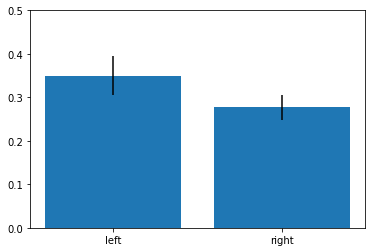

In [684]:
left = whole_qse.loc[whole_qse.outlet.isin(['NYT','HUFF','CNN'])]
right = whole_qse.loc[whole_qse.outlet.isin(['NYP','BREIT','FOX'])]
toplot = [left.female_t.sum()/left.male_t.sum(), right.female_t.sum()/right.male_t.sum()]
plt.bar(['left','right'],toplot,yerr=[left_std,right_std])
plt.ylim(0,.5)

print(toplot[0]-left_std, toplot[1]+right_std)

In [707]:
from statsmodels.stats.proportion import proportions_ztest
num_trials = whole_qse.shape[0]
num_success = whole_qse[whole_qse.male_t < whole_qse.female_t].shape[0]
h0_val = 0.5
proportions_ztest(count=num_success, nobs=num_trials, value=0.5, alternative='smaller')

(-252.809449635348, 0.0)

In [692]:
num_success

15909

In [76]:
import patsy
import statsmodels.api as sm

outlet_ratios['lean'] = 1 # right
outlet_ratios.loc[outlet_ratios.index.isin(['HUFF','CNN','NYT']),"lean"] = 2 # left
model = sm.GLM(outlet_ratios.lean.values, outlet_ratios.ratio.values,family=sm.families.Poisson())
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                    6
Model:                            GLM   Df Residuals:                        5
Model Family:                 Poisson   Df Model:                            0
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -7.3130
Date:                Fri, 24 Jun 2022   Deviance:                      0.78479
Time:                        11:35:21   Pearson chi2:                    0.749
No. Iterations:                     3   Pseudo R-squ. (CS):            0.03835
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.3524      1.016      1.331      0.183      -0.640       3.345
==============================================================================
"""

In [511]:
# t test for ratio of women over men
ratio_df = whole_qse.copy()
ratio_df.loc[ratio_df.outlet.isin(['NYT','HUFF','CNN']),'lean'] = 'left'
ratio_df.loc[ratio_df.outlet.isin(['NYP','BREIT','FOX']),'lean'] = 'right'
ratio_df['outlet_rat'] = 0
for x in ['BREIT','NYP','FOX','NYT','CNN','HUFF']:
    df_slice = ratio_df.loc[ratio_df['outlet'] == x]
    ratio_df.loc[ratio_df['outlet'] == x,'outlet_rat'] = df_slice['female_t'].sum() / df_slice['male_t'].sum()
scipy.stats.ttest_ind(ratio_df.loc[ratio_df.lean == 'left','outlet_rat'],ratio_df.loc[ratio_df.lean == 'right','outlet_rat'])

Ttest_indResult(statistic=450.62877347335905, pvalue=0.0)

Text(0.5, 1.0, 'Expert Gender by News Outlet')

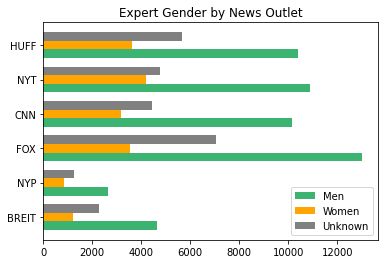

In [516]:
x = ["BREIT","NYP","FOX","CNN","NYT","HUFF"]
toplot = pd.DataFrame()
for l in x:
    df_slice = whole_qse[whole_qse.outlet == l]
    toplot = toplot.append(pd.DataFrame([[df_slice["male_t"].sum(), df_slice["female_t"].sum(), df_slice["andy_t"].sum() + df_slice["unknown_t"].sum()]]))
toplot.columns = ['Men','Women','Unknown']
plt.barh(np.arange(6) - .25,toplot.Men,.25,color='mediumseagreen',label='Men')
plt.barh(np.arange(6),toplot.Women,.25,color='orange',label='Women')
plt.barh(np.arange(6) + .25, toplot.Unknown,.25, color='gray',label='Unknown')
plt.yticks(np.arange(6),x)
plt.legend()
plt.title("Expert Gender by News Outlet")

Text(0.5, 1.0, 'Organization Affiliation by News Outlet')

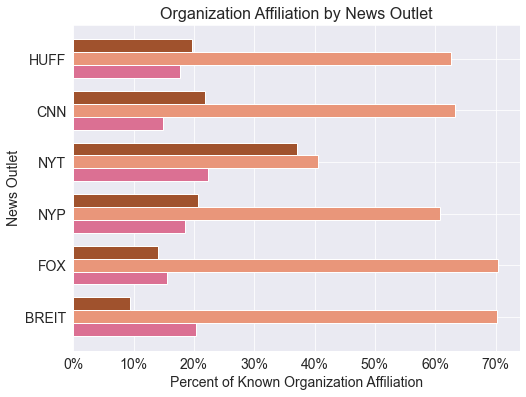

In [226]:
x = ["BREIT","FOX","NYP","NYT","CNN","HUFF"]
toplot = pd.DataFrame()
for l in x:
    educ_slice = whole_educ[whole_educ.outlet == l]
    gov_slice = whole_gov[whole_gov.outlet == l]
    thinkt_slice = whole_thinkt[whole_thinkt.outlet == l]
    total = educ_slice.shape[0] + gov_slice.shape[0] + thinkt_slice.shape[0]
    toplot = toplot.append(pd.DataFrame([[l,educ_slice.shape[0]/total,gov_slice.shape[0]/total,thinkt_slice.shape[0]/total]]))
toplot.columns = ['outlet','educ','gov','thinkt']
plt.figure(figsize=(8,6))
plt.barh(np.arange(6) - .25, toplot.thinkt,.25,label='Think \nTanks',color='palevioletred')
plt.barh(np.arange(6),toplot.gov,.25,label='Federal',color='darksalmon')
plt.barh(np.arange(6) + .25,toplot.educ,.25,label='Academic',color='sienna')
plt.yticks(np.arange(6),x,fontsize=14)
plt.xticks(np.arange(0,0.71,0.1),[str(i)+"%" for i in np.arange(0,80,10)],fontsize=14)
#plt.legend(fontsize=18,facecolor='white',framealpha=1)
plt.xlabel("Percent of Known Organization Affiliation",fontsize=14)
plt.ylabel("News Outlet",fontsize=14)
plt.title("Organization Affiliation by News Outlet",fontsize=16)

In [227]:
toplot

,outlet,educ,gov,thinkt
0,BREIT,0.094380,0.702274,0.203346
0,FOX,0.139581,0.704885,0.155533
0,NYP,0.206827,0.608434,0.184739
0,NYT,0.370433,0.405659,0.223909
0,CNN,0.219072,0.632430,0.148498
0,HUFF,0.196492,0.626227,0.177281


In [467]:
print("Average sentence length: ",whole_thinkt['quote'].str.len().mean())
print("Average sentence length with women: ", whole_thinkt[whole_thinkt["female_t"] > 0]["quote"].str.len().mean())
print("Average sentence length with women: ", whole_thinkt[whole_thinkt["male_t"] > 0]["quote"].str.len().mean())

Average sentence length:  234.08607594936709
Average sentence length with women:  226.47674418604652
Average sentence length with women:  228.40836012861737


In [760]:
whole_qse[whole_qse.method == 'DEP']

,idx,quote,people,orgs,source,gender,outlet,method,gender_t,male_t,female_t,unknown_t,andy_t
0,4,'I’d say there’s always a dance between any go...,"['Trump', 'Mark Sanford']",['Congress'],The New York Times,0.0,NYT,DEP,"['male', 'male']",2,0,0,0
1,7,"'You know, it took me some time to get my pare...",['Maurice Mitchell'],['Working Families'],The New York Times,0.0,NYT,DEP,['male'],1,0,0,0
2,7,"'It’s an immediate effect on how we can plan, ...","['Amanda Litman', 'Trump’s']",['Run for Something'],The New York Times,0.0,NYT,DEP,"['female', 'unknown']",0,1,1,0
3,7,"'The more impersonal the mode, the less effect...",['Alex Morgan'],['’s'],The New York Times,0.0,NYT,DEP,['male'],1,0,0,0
4,11,"'Dr. Trevor Bedford, the Fred Hutchinson Cance...",['Trevor Bedford'],['the Fred Hutchinson Cancer Research Center'],The New York Times,0.0,NYT,DEP,['male'],1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
84212,58659,"'During an interview with CNN on Thursday, Ope...",['Moncef Slaoui'],['CNN'],NaN,NaN,BREIT,DEP,['male'],1,0,0,0
84213,58659,"'During an interview with CNN on Thursday, Ope...",['Moncef Slaoui'],['CNN'],NaN,NaN,BREIT,DEP,['male'],1,0,0,0
84214,58661,'Sen. Dianne Feinstein (D-CA) praised\xa0China...,['Dianne Feinstein'],['D-CA'],NaN,NaN,BREIT,DEP,['female'],0,1,0,0
84215,58661,'Sen. Dianne Feinstein (D-CA) praised\xa0China...,['Dianne Feinstein'],['D-CA'],NaN,NaN,BREIT,DEP,['female'],0,1,0,0


In [482]:
# 
cols = ['female_t','male_t','andy_t']
df_slice = whole_qse[whole_qse['female_t'] > 0]
print(df_slice.shape[0])
df_slice = df_slice[df_slice['male_t'] > 0]
print(df_slice.shape[0])

16478
605


In [483]:
cols = ['female_t','male_t','andy_t']
df_slice = whole_qse[whole_qse['male_t'] > 0]
print(df_slice.shape[0])
df_slice = df_slice[df_slice['female_t'] > 0]
print(df_slice.shape[0])
#whole_qse[whole_qse['male_t'] > 0]['male_t'].sum()/whole_qse[whole_qse['ale_t'] > 0][cols].sum().sum()

50444
605


In [563]:
# count mentions

times15 = pd.read_csv('data/timesData-2015rankings.csv')
for i in np.arange(201,402):
    times15.loc[i-1,"world_rank"]= i
times15["c_total"] = 0; times15["c_breit"] = 0; times15["c_nyp"] = 0; times15["c_fox"] = 0;
times15["c_cnn"] = 0; times15["c_nyt"] = 0; times15["c_huff"] = 0# introduce column to count university mentions
for i, x in times15.iterrows():
    univ = x.university_name
    total = 0
    for l in ["BREIT","NYP","FOX","CNN","NYT","HUFF"]:
        df_slice = whole_educ[whole_educ.outlet == l]
        df_slice = df_slice[df_slice.educ_inst.str.contains(univ)]
        times15.loc[i,"c_"+l.lower()] = df_slice.shape[0]
        total += df_slice.shape[0]
    times15.loc[i,"c_total"] = total


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  del sys.path[0]


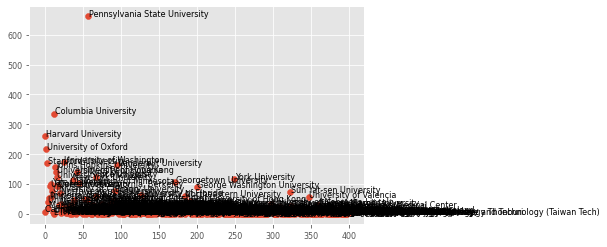

In [199]:
N = 401
fig, ax = plt.subplots()
ax.scatter(times15.index,times15.c_total)
for i, x in times15.iterrows():
    plt.text(x=i+1, y=x.c_total, s=x.university_name)

In [392]:
# Cleaning up PSU
total = 0
whole_educ_clean = whole_educ
for i, x in whole_educ[whole_educ.educ_inst == 'Pennsylvania State University'].iterrows():
    if 'Pennsylvania' not in x.quote:
        whole_educ_clean.drop(index=i, inplace=True)

times15 = pd.read_csv('data/timesData-2015rankings.csv')
for i in np.arange(201,402):
    times15.loc[i-1,"world_rank"]= i
times15["c_total"] = 0; times15["c_breit"] = 0; times15["c_nyp"] = 0; times15["c_fox"] = 0;
times15["c_cnn"] = 0; times15["c_nyt"] = 0; times15["c_huff"] = 0# introduce column to count university mentions
for i, x in times15.iterrows():
    univ = x.university_name
    total = 0
    for l in ["BREIT","NYP","FOX","CNN","NYT","HUFF"]:
        df_slice = whole_educ_clean[whole_educ_clean.outlet == l]
        df_slice = df_slice[df_slice.educ_inst.str.contains(univ)]
        times15.loc[i,"c_"+l.lower()] = df_slice.shape[0]
        total += df_slice.shape[0]
    times15.loc[i,"c_total"] = total


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


In [1262]:
total = whole_educ.shape[0] + whole_gov.shape[0] + whole_thinkt.shape[0]
print("educ ", whole_educ.shape[0]/total)
print("gov ",whole_gov.shape[0]/total)
print("think tank ",whole_thinkt.shape[0]/total)
print(total/whole_qse.shape[0])

educ  0.2324313408723748
gov  0.5920840064620355
think tank  0.17548465266558966
0.2761605210912579


In [1291]:
pd.set_option('display.max_colwidth', None)
whole_qse.sample(n=10).quote

84068    'During a speech on the Senate floor on Monday, Senate Minority Leader Chuck Schumer (D-NY) criticized President Trump for planning campaign rallies and having attendees sign waivers that they won’t sue if they contract coronavirus, stating that the president “doesn’t care” whether or not people get coronavirus from attending one of his rallies because he is superficial and stated that President Trump moved parts of the Republican National Convention from North Carolina so he could “avoid having to respect the most basic precautions against the spread of coronavirus.', 'President Trump has also moved major parts of the Republican Convention out of North Carolina in order to avoid having to respect the most basic precautions against the spread of coronavirus.'
11528                                                                                                                                                                                                                        

In [72]:
# Define gini coefficient
# https://www.statology.org/gini-coefficient-python/
# works on list of ranking 
import itertools

def gini(x):
    total = 0
    for i, xi in enumerate(x):
        total += np.sum(np.abs(xi - x[i:]))
    return total / (len(x)**2 * np.mean(x))

# gini coefficient from list of rankings
# i.e. if rank 1 has 2 citations and rank 2 has 3 citations,
# we take gini coeffieent of the list [1, 1, 2, 2, 2]
gini(np.array(list(itertools.chain.from_iterable([[i]*x.c_total for i, x in times15.iterrows()]))))

0.572648324077025

WITH ZERO COUNTS
Spearman corr:  SpearmanrResult(correlation=-0.33783331020120494, pvalue=3.669658748258977e-12)
Gini:  0.5683412384257613
Pearson corr:  (-0.33340025731434475, 7.255545535972892e-12)
WITHOUT ZERO COUNTS
Spearman corr:  SpearmanrResult(correlation=-0.3785622753485839, pvalue=1.885405592101747e-07)
Gini:  0.5683412384257613
Pearson corr: (-0.34190808347937807, 2.996866560557945e-06)


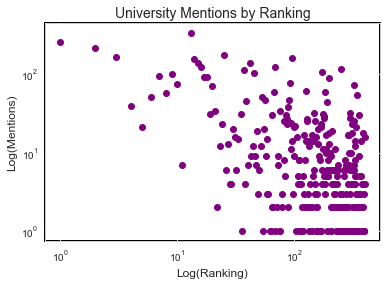

In [246]:
from scipy.stats import pearsonr

N = 401
fig, ax = plt.subplots()
nozeroes = times15.loc[times15.c_total > 0]
ax.scatter(nozeroes.index,nozeroes.c_total,color='purple')
ax.set_facecolor('white')
ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth('2')  

plt.xlabel("Log(Ranking)",fontsize=12)
plt.ylabel("Log(Mentions)",fontsize=12)
plt.title("University Mentions by Ranking",fontsize=14)
ax.set_yscale('log')
ax.set_xscale('log')

print("WITH ZERO COUNTS")
rank_cit = pd.DataFrame([times15.index.values,times15.c_huff.values]).T
rank_cit.columns = ['rank_', 'citations']
print("Spearman corr: ",scipy.stats.spearmanr(rank_cit.rank_.values,rank_cit.citations.values))
print("Gini: ",gini(np.array(list(itertools.chain.from_iterable([[i]*x.citations for i, x in rank_cit.iterrows()])))))
print("Pearson corr: ",scipy.stats.pearsonr(rank_cit.rank_.values,rank_cit.citations.values))

rank_cit = rank_cit[rank_cit.citations > 0]
print("WITHOUT ZERO COUNTS")
print("Spearman corr: ",scipy.stats.spearmanr(rank_cit.rank_.values,rank_cit.citations.values))
rank_cit
print("Gini: ",gini(np.array(list(itertools.chain.from_iterable([[i]*x.citations for i, x in rank_cit.iterrows()])))))
print("Pearson corr:",pearsonr(rank_cit.rank_.values,rank_cit.citations))

([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

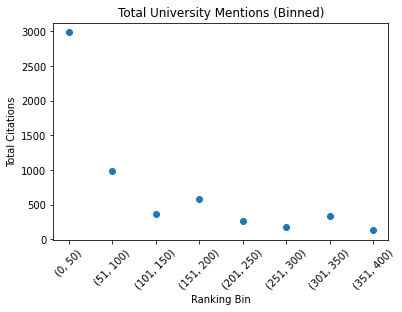

In [469]:
N = 401
bins = pd.DataFrame([np.arange(8)]).T
bins["range"] = 0
for i in np.arange(0,8):
    if i == 0:
        df_slice = times15.loc[np.arange(i*50,50+i*50)]
        bins.loc[i,"range"] = str((i*50,50+i*50))
    else:
        df_slice = times15.loc[np.arange(1+i*50,50+i*50)]
        bins.loc[i,"range"] = str((1+i*50,50+i*50))
    bins.loc[i,"total"] = df_slice['c_total'].sum()
    bins.loc[i,"average"] = df_slice['c_total'].sum() / 50
    bins.loc[i,"med"] = np.median(df_slice['c_total'])
bins = bins.drop(columns=[0])

N = 8
fig, ax = plt.subplots()
ax.scatter(bins.range,bins.total)
plt.xlabel("Ranking Bin")
plt.ylabel("Total Citations")
plt.title("Total University Mentions (Binned)")
plt.xticks(rotation=45)

Text(0.5, 0.98, '')

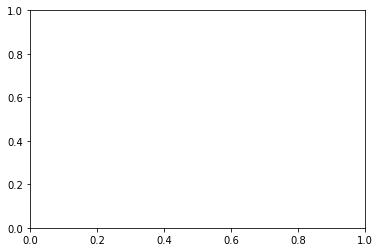

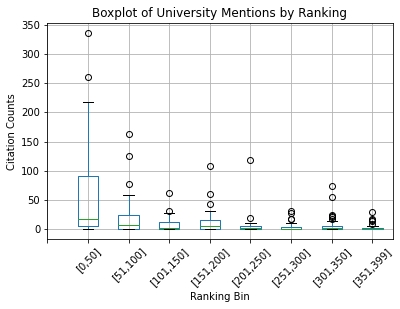

In [733]:
N = 401
times15["range"] = 0
times15["bin"] = 0
for i in np.arange(0,8):
    if i == 0:
        times15.loc[np.arange(i*50,50+i*50),"range"] = str((i*50,50+i*50))
        times15.loc[np.arange(i*50,50+i*50),"bin"] = i
    else:
        #
        times15.loc[np.arange(1+i*50,50+i*50),"range"] = str((1+i*50,50+i*50))
        times15.loc[np.arange(1+i*50,50+i*50),"bin"] = i

fig, ax = plt.subplots()
times15["c_total"] = pd.to_numeric(times15["c_total"])
times15.loc[:,["bin","c_total"]].boxplot(by=['bin'])
new_labels = ["","[0,50]", "[51,100]","[101,150]","[151,200]","[201,250]","[251,300]","[301,350]","[351,399]"]
plt.xticks(np.arange(0,9),new_labels,rotation=45)
plt.xlabel("Ranking Bin")
plt.ylabel("Citation Counts")
plt.title("Boxplot of University Mentions by Ranking")
plt.suptitle("")

In [735]:
times15.loc[:,["bin","c_total"]].c_total.mean()

14.830423940149625

In [432]:
whole_thinkt.shape

(4345, 13)

Text(0.5, 0.98, '')

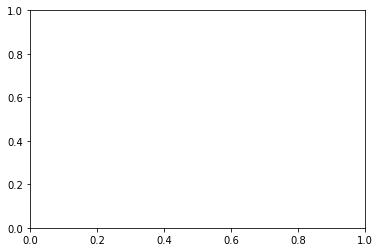

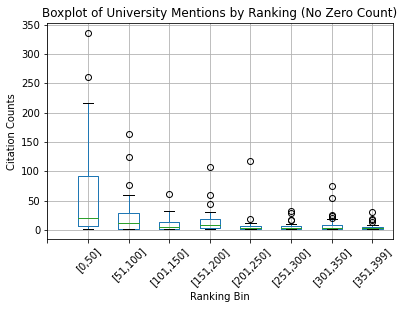

In [748]:
N = 401
bins = pd.DataFrame([np.arange(8)]).T
bins["range"] = 0
times15["bin"] = 0
for i in np.arange(0,8):
    if i == 0:
        df_slice = times15.loc[np.arange(i*50,50+i*50)]
        df_slice = df_slice.loc[df_slice['c_total'] > 0]
        bins.loc[i,"range"] = str((i*50,50+i*50))
        times15.loc[np.arange(i*50,50+i*50),"range"] = str((i*50,50+i*50))
        times15.loc[np.arange(i*50,50+i*50),"bin"] = i
    else:
        df_slice = times15.loc[np.arange(1+i*50,50+i*50)]
        df_slice = df_slice.loc[df_slice['c_total'] > 0]
        bins.loc[i,"range"] = str((1+i*50,50+i*50))
        times15.loc[np.arange(1+i*50,50+i*50),"range"] = str((1+i*50,50+i*50))
        times15.loc[np.arange(1+i*50,50+i*50),"bin"] = i
    bins.loc[i,"total"] = df_slice['c_total'].sum()
    bins.loc[i,"average"] = df_slice['c_total'].sum() / df_slice.shape[0]
    bins.loc[i,"med"] = np.median(df_slice['c_total'])
bins = bins.drop(columns=[0])
bins

fig, ax = plt.subplots()
times15.c_total = pd.to_numeric(times15.c_total)
times15.loc[times15.c_total > 0,["bin","c_total"]].boxplot(by=['bin'])
new_labels = ["","[0,50]", "[51,100]","[101,150]","[151,200]","[201,250]","[251,300]","[301,350]","[351,399]"]
plt.xticks(np.arange(0,9),new_labels,rotation=45)
plt.xlabel("Ranking Bin")
plt.ylabel("Citation Counts")
plt.title("Boxplot of University Mentions by Ranking (No Zero Count)")
plt.suptitle("")


In [747]:
print("Bin 0 median without zeroes: ",times15.loc[(times15.c_total > 0) & (times15.bin == 0)].c_total.median())
print("Bin 0 median with zeroes: ",times15.loc[(times15.bin == 0)].c_total.median())
print("Bin 0 avg without zeroes: ",times15.loc[(times15.c_total > 0) & (times15.bin == 0)].c_total.mean())
print("Bin 0 avg with zeroes: ",times15.loc[(times15.bin == 0)].c_total.mean())

print("Bin 1 median without zeroes: ",times15.loc[(times15.c_total > 0) & (times15.bin == 1)].c_total.median())
print("Bin 1 median with zeroes: ",times15.loc[(times15.bin == 1)].c_total.median())
print("Bin 1 avg without zeroes: ",times15.loc[(times15.c_total > 0) & (times15.bin == 1)].c_total.mean())
print("Bin 1 avg with zeroes: ",times15.loc[(times15.bin == 1)].c_total.mean())

Bin 0 median without zeroes:  20.0
Bin 0 median with zeroes:  17.5
Bin 0 avg without zeroes:  56.41818181818182
Bin 0 avg with zeroes:  53.5
Bin 1 median without zeroes:  11.5
Bin 1 median with zeroes:  8.0
Bin 1 avg without zeroes:  23.404761904761905
Bin 1 avg with zeroes:  20.06122448979592


In [753]:
times15.loc[times15.c_total > 0].c_total.mean()

20.023569023569024

([<matplotlib.patches.Wedge at 0x15a036190>,
 [Text(1.0777103718037426, 0.22031875659289438, 'University'),
  Text(0.669033460612343, 0.8731518931898806, 'Government'),
  Text(-0.013335839316096757, 1.099919158570181, 'Think Tank'),
  Text(-0.7113385381445857, -0.8390455793044405, 'Unknown')],
 [Text(0.5878420209838595, 0.12017386723248782, '6.4%'),
  Text(0.3649273421521871, 0.4762646690126621, '16.4%'),
  Text(-0.007274094172416411, 0.5999559046746442, '4.8%'),
  Text(-0.3880028389879558, -0.4576612250751493, '72.4%')])

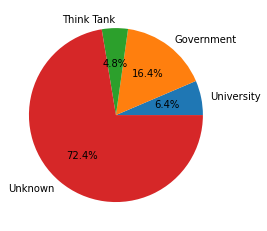

In [129]:
total = whole_educ.shape[0] + whole_gov.shape[0] + whole_thinkt.shape[0]
total2 = whole_qse.shape[0]
rest = total2 - total
toplot = [whole_educ.shape[0]/total2, whole_gov.shape[0]/total2, whole_thinkt.shape[0]/total2, rest/total2]
plt.pie(toplot,labels=['University','Government','Think Tank','Unknown'],autopct='%1.1f%%')

Text(0.5, 1.0, 'Overall Gender Composition')

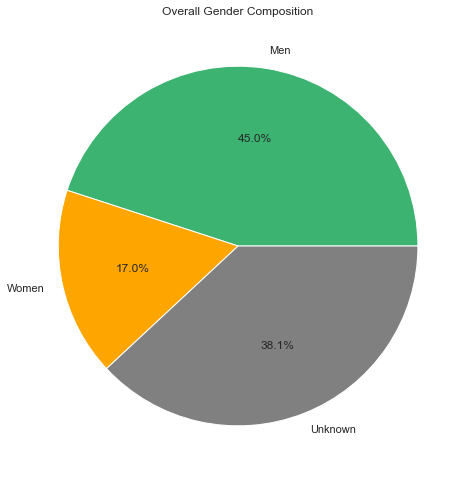

In [1115]:
total = whole_qse['female_t'].sum() + whole_qse['male_t'].sum() + whole_qse['andy_t'].sum() #+ whole_qse['unknown_t'].sum()
toplot = [whole_qse['male_t'].sum()/total, whole_qse['female_t'].sum()/total, (whole_qse['andy_t'].sum() + whole_qse['unknown_t'].sum())/total]
plt.pie(toplot, colors=['mediumseagreen','orange','gray'],labels=['Men','Women','Unknown'],autopct='%1.1f%%')
plt.title('Overall Gender Composition')


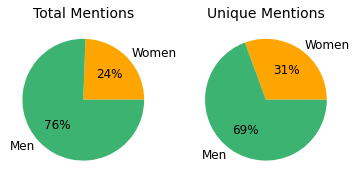

In [68]:
fig, ax = plt.subplots(1,2)

total = whole_qse['female_t'].sum() + whole_qse['male_t'].sum()  #+ whole_qse['unknown_t'].sum()
toplot = [whole_qse['female_t'].sum()/total, whole_qse['male_t'].sum()/total] # (whole_qse['andy_t'].sum() + whole_qse['unknown_t'].sum())/total]
colors = ['orange','mediumseagreen']
sns.set_palette(sns.color_palette(colors))
ax[0].pie(toplot,labels=['Women','Men'],autopct='%.0f%%',textprops={'fontsize': 12})
ax[0].set_title('Total Mentions',fontsize=14)#,y=-.05)
#ax[0].title.set_position([0.5,-.85])

total = men + women
toplot2 = [women/total, men/total]
ax[1].pie(toplot2,labels=['Women','Men'],autopct='%.0f%%', textprops={'fontsize': 12})
ax[1].set_title('Unique Mentions',fontsize=14)#,y=-.05)
ax[1].title.set_position([0.5,-.8])

#plt.suptitle("Overall Gender Composition",fontsize=20, y=.76)

In [1109]:
whole_qse

,idx,quote,people,orgs,source,gender,outlet,method,gender_t,male_t,female_t,unknown_t,andy_t,gender_u,male_u,female_u,unknown_u,andy_u,date
0,4,'I’d say there’s always a dance between any go...,"['Trump', 'Mark Sanford']",['Congress'],The New York Times,0.0,NYT,DEP,"['unknown', 'male']",1,0,1,0,"['male', 'male']",2,0,0,0,0
1,7,"'You know, it took me some time to get my pare...",['Maurice Mitchell'],['Working Families'],The New York Times,0.0,NYT,DEP,['male'],1,0,0,0,['male'],1,0,0,0,0
2,7,"'It’s an immediate effect on how we can plan, ...","['Amanda Litman', 'Trump’s']",['Run for Something'],The New York Times,0.0,NYT,DEP,"['female', 'unknown']",0,1,1,0,['female'],0,1,0,0,0
3,7,"'The more impersonal the mode, the less effect...",['Alex Morgan'],['’s'],The New York Times,0.0,NYT,DEP,['male'],1,0,0,0,['male'],1,0,0,0,0
4,11,"'Dr. Trevor Bedford, the Fred Hutchinson Cance...",['Trevor Bedford'],['the Fred Hutchinson Cancer Research Center'],The New York Times,0.0,NYT,DEP,['male'],1,0,0,0,['male'],1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89653,3275,'And if state officials are putting up with th...,['Romney'],"['Rep', 'D-GA']",NaN,NaN,BREIT,NER,['male'],1,0,0,0,0,0,0,0,0,0
89654,3277,"'During a town hall on CNN on Thursday, White ...",['Fauci'],"['CNN', 'White House Coronavirus Task Force']",NaN,NaN,BREIT,NER,['unknown'],0,0,1,0,0,0,0,0,0,0
89655,3279,"'During an interview with CNN on Thursday, Ope...",['Slaoui'],['CNN'],NaN,NaN,BREIT,NER,['unknown'],0,0,1,0,0,0,0,0,0,0
89656,3281,'Sen. Dianne Feinstein (D-CA) praised\xa0China...,['Feinstein'],"['D-CA', 'Senate Judiciary Committee', 'COVID-...",NaN,NaN,BREIT,NER,['unknown'],0,0,1,0,0,0,0,0,0,0


([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

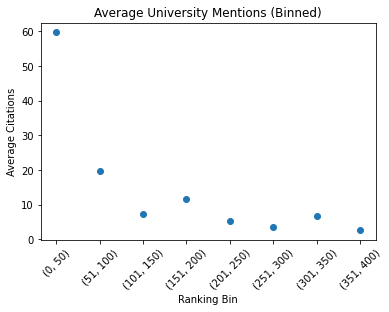

In [86]:
N = 8
fig, ax = plt.subplots()
ax.scatter(bins.range,bins.average)
plt.xlabel("Ranking Bin")
plt.ylabel("Average Citations")
plt.title("Average University Mentions (Binned)")
plt.xticks(rotation=45)

In [1149]:
whole_qse#[whole_qse.

 != 0].shape

,idx,quote,people,orgs,source,gender,outlet,method,gender_t,male_t,female_t,unknown_t,andy_t,gender_u,male_u,female_u,unknown_u,andy_u,date
0,4,'I’d say there’s always a dance between any go...,"['Trump', 'Mark Sanford']",['Congress'],The New York Times,0.0,NYT,DEP,"['unknown', 'male']",1,0,1,0,"['male', 'male']",2,0,0,0,0
1,7,"'You know, it took me some time to get my pare...",['Maurice Mitchell'],['Working Families'],The New York Times,0.0,NYT,DEP,['male'],1,0,0,0,['male'],1,0,0,0,2020-04-05 21:42:29+00:00
2,7,"'It’s an immediate effect on how we can plan, ...","['Amanda Litman', 'Trump’s']",['Run for Something'],The New York Times,0.0,NYT,DEP,"['female', 'unknown']",0,1,1,0,['female'],0,1,0,0,2020-04-05 21:42:29+00:00
3,7,"'The more impersonal the mode, the less effect...",['Alex Morgan'],['’s'],The New York Times,0.0,NYT,DEP,['male'],1,0,0,0,['male'],1,0,0,0,2020-04-05 21:42:29+00:00
4,11,"'Dr. Trevor Bedford, the Fred Hutchinson Cance...",['Trevor Bedford'],['the Fred Hutchinson Cancer Research Center'],The New York Times,0.0,NYT,DEP,['male'],1,0,0,0,['male'],1,0,0,0,2020-04-05 19:03:55+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89653,3275,'And if state officials are putting up with th...,['Romney'],"['Rep', 'D-GA']",NaN,NaN,BREIT,NER,['male'],1,0,0,0,0,0,0,0,0,0
89654,3277,"'During a town hall on CNN on Thursday, White ...",['Fauci'],"['CNN', 'White House Coronavirus Task Force']",NaN,NaN,BREIT,NER,['unknown'],0,0,1,0,0,0,0,0,0,0
89655,3279,"'During an interview with CNN on Thursday, Ope...",['Slaoui'],['CNN'],NaN,NaN,BREIT,NER,['unknown'],0,0,1,0,0,0,0,0,0,2020-07-31 01:07:06+00:00
89656,3281,'Sen. Dianne Feinstein (D-CA) praised\xa0China...,['Feinstein'],"['D-CA', 'Senate Judiciary Committee', 'COVID-...",NaN,NaN,BREIT,NER,['unknown'],0,0,1,0,0,0,0,0,0,0


In [1175]:
whole_qse["date"] = 0
for i, x in whole_qse.iterrows():
    df_slice = aylien.loc[aylien.text.str.contains(x.quote[1:-1])]
    if df_slice.shape[0] >= 1:
        whole_qse.loc[i,"date"] = df_slice.date.unique()[0]
    else:
        print(x.quote)
whole_qse

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until


'Doctors Are Writing Their Wills,” by Bari Weiss (Sunday Review, March 29), raises the important point that personal wills are so essential.'
'Re “Prostate Surgery, or ‘Active Surveillance’?,” by Jane E. Brody (Personal Health, March 3):\nSome cancers are caught early enough that active surveillance is an appropriate treatment path.'
'What the Pandemic Means for Climate Change,” by Meehan Crist (Sunday Review, March 29):\nIn Los Angeles, New York, Manila and Milan, the skies clear as air pollution drops.'
'I worry a lot,” he added, “that if community health centers go away, we won’t as a society hear the struggles of these people.”\nCommunity health centers are expecting a boost from the $2 trillion stimulus package recently passed by Congress and signed by President Trump; they will share $1.3 billion.'
'The S.B.A. contract with RER Solutions, which is for “data analysis and loan recommendation services for Covid-19,” appears to be related to a $10-million-per-year contract that RER s

KeyboardInterrupt: 

In [1184]:
whole_qse['male_u'].sum()

1800

In [1174]:
whole_qse_dates = pd.read_csv("whole_qse_partial_dates.csv")
whole_qse_dates.loc[whole_qse_dates.date != "0"].shape
whole_qse.shape

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (5,14) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(89658, 19)

In [1181]:
whole_qse_dates.method.value_counts()

NER    65680
DEP    23978
Name: method, dtype: int64

In [1180]:
whole_qse_dates.loc[whole_qse_dates.date != "0"].method.value_counts()

NER    38126
DEP    10611
Name: method, dtype: int64

([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

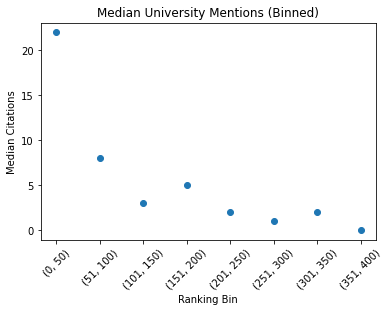

In [91]:
N = 8
fig, ax = plt.subplots()
ax.scatter(bins.range,bins.med)
plt.xlabel("Ranking Bin")
plt.ylabel("Median Citations")
plt.title("Median University Mentions (Binned)")
plt.xticks(rotation=45)

LEFT-LEANING
Gini:  0.5733573852149372
WITH ZERO COUNTS
Spearman corr:  SpearmanrResult(correlation=-0.43867058465249653, pvalue=2.7343489110422166e-20)
Pearson corr:  (-0.3768467431848862, 5.598299175763653e-15)
WITHOUT ZERO COUNTS
Spearman corr:  SpearmanrResult(correlation=-0.43867058465249653, pvalue=2.7343489110422166e-20)


NameError: name 'pearsonr' is not defined

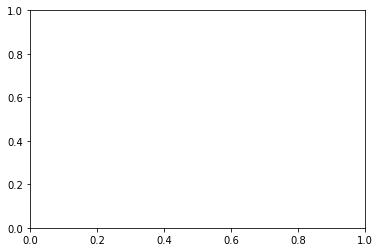

In [73]:
N = 401
fig, ax = plt.subplots()
#for i, x in times15.iterrows():
    #if i in [1,13,68,3,25,95,172,249,347,323]:
    #    plt.text(x=i+1, y=x.c_breit + x.c_nyp + x.c_fox, s=x.university_name)
    #plt.text(x=i+1, y=x.c_breit + x.c_nyp + x.c_fox, s=i)

print("LEFT-LEANING")
left_cit = pd.DataFrame([times15.index.values,times15.c_huff.values + times15.c_cnn.values + times15.c_nyt.values]).T
left_cit.columns = ['rank_', 'citations']
left_cit['citations_norm'] = left_cit.citations / left_cit.citations.sum()
print("Gini: ",gini(np.array(list(itertools.chain.from_iterable([[i]*int(x.citations) for i, x in left_cit.iterrows()])))))
print("WITH ZERO COUNTS")
print("Spearman corr: ",scipy.stats.spearmanr(left_cit.rank_.values,left_cit.citations.values))
print("Pearson corr: ",scipy.stats.pearsonr(left_cit.rank_.values,left_cit.citations.values))
#left_cit = left_cit[left_cit.citations > 0]
print("WITHOUT ZERO COUNTS")
print("Spearman corr: ",scipy.stats.spearmanr(left_cit.rank_.values,left_cit.citations.values))
print("Pearson corr:",pearsonr(left_cit.rank_.values,left_cit.citations))

print("\nRIGHT-LEANING")
right_cit = pd.DataFrame([times15.index.values,times15.c_breit.values + times15.c_fox.values + times15.c_nyp.values]).T
right_cit.columns = ['rank_', 'citations']
right_cit['citations_norm'] = right_cit.citations / right_cit.citations.sum()
print("Gini: ",gini(np.array(list(itertools.chain.from_iterable([[int(i)]*int(x.citations) for i, x in right_cit.iterrows()])))))
print("WITH ZERO COUNTS")
print("Spearman corr: ",scipy.stats.spearmanr(right_cit.rank_.values,right_cit.citations.values))
print("Pearson corr: ",scipy.stats.pearsonr(right_cit.rank_.values,right_cit.citations.values))
#right_cit = right_cit[right_cit.citations > 0]
print("WITHOUT ZERO COUNTS")
print("Spearman corr: ",scipy.stats.spearmanr(right_cit.rank_.values,right_cit.citations.values))
print("Pearson corr:",pearsonr(right_cit.rank_.values,right_cit.citations))

ax.scatter(left_cit.rank_,left_cit.citations_norm,color='darkblue',label='Left-Leaning')
ax.scatter(right_cit.rank_,right_cit.citations_norm,color='firebrick',label='Right-Leaning')
plt.xlabel("Ranking")
plt.ylabel("Percent Mentions")
ax.set_yscale('log')
ax.set_xscale('log')
plt.legend()
plt.title("University Mentions by Ranking (Political Affiliation)")

In [249]:
means = left_cit2.groupby(['bin']).mean()#.norm
#mean_right = right_cit2.groupby(['bin']).mean().norm
means_left = left_cit2.groupby(['bin']).mean().norm
means_right = right_cit2.groupby(['bin']).mean().norm
print(means_right)

NameError: name 'left_cit2' is not defined

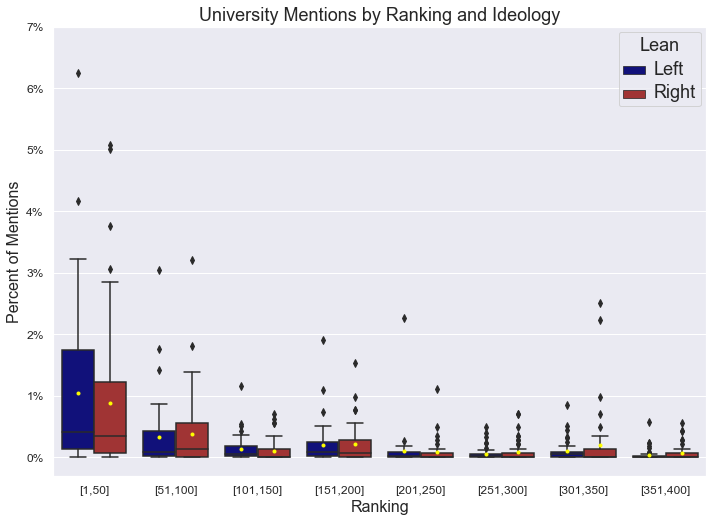

In [250]:
left_cit2 = left_cit.copy()
left_cit2.columns = ['rank_', 'citations', 'norm']
left_cit2["Lean"] = "Left"
right_cit2 = right_cit.copy()
right_cit2.columns = ['rank_', 'citations', 'norm']
right_cit2["Lean"] = "Right"
lean_cit2 = pd.concat([left_cit2,right_cit2])
colors = ['darkblue','firebrick']
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_palette(sns.color_palette(colors))

left_cit2["bin"] = 0
right_cit2["bin"] = 0
for i in np.arange(0,8):
    if i == 0:
        lean_cit2.loc[np.arange(i*50,50+i*50),"bin"] = i
        left_cit2.loc[np.arange(i*50,50+i*50),"bin"] = i
        right_cit2.loc[np.arange(i*50,50+i*50),"bin"] = i
    else:
        lean_cit2.loc[np.arange(1+i*50,50+i*50),"bin"] = i
        left_cit2.loc[np.arange(1+i*50,50+i*50),"bin"] = i
        right_cit2.loc[np.arange(1+i*50,50+i*50),"bin"] = i


bins_names = ["[1,50]","[51,100]","[101,150]","[151,200]","[201,250]","[251,300]","[301,350]","[351,400]"]
p = sns.boxplot(y='norm',x='bin',data=lean_cit2,hue='Lean',showmeans=True,meanprops={"marker":".","markerfacecolor":"yellow", "markeredgecolor":"yellow"})#,split=False)
p.set_xlabel("Ranking",fontsize=16)
p.set_ylabel("Percent of Mentions",fontsize=16)
plt.xticks(np.arange(8),bins_names,fontsize=12)
#plt.yticks(np.arange(0,0.07,0.01),["0%","1%","2%","3%","4%","5%","6%","7%"],fontsize=12)
plt.title("University Mentions by Ranking and Ideology", fontsize=18)
plt.setp(p.get_legend().get_title(), fontsize=18)
plt.setp(p.get_legend().get_texts(), fontsize=18)
plt.yticks(np.arange(0,0.07,0.01),["0%","1%","2%","3%","4%","5%","6%","7%"],fontsize=12)

means_left = left_cit2.groupby(['bin']).mean().norm
means_right = right_cit2.groupby(['bin']).mean().norm


In [1303]:
lean_cit2.groupby(['bin']).mean().norm

bin
0    0.008605
1    0.003506
2    0.001202
3    0.002033
4    0.000840
5    0.000705
6    0.001418
7    0.000519
Name: norm, dtype: float64

In [1295]:
lean_cit2

,rank_,citations,norm,Lean,bin
0,0,4,0.000887,Left,0
1,1,188,0.041685,Left,0
2,2,145,0.032151,Left,0
3,3,128,0.028381,Left,0
4,4,27,0.005987,Left,0
...,...,...,...,...,...
396,396,0,0.000000,Right,7
397,397,1,0.000696,Right,7
398,398,0,0.000000,Right,7
399,399,6,0.004175,Right,7


In [1066]:
lean_cit2[(lean_cit2.bin == 0) & (lean_cit2.Lean == 'Left')]['norm'].median()
lean_cit2[(lean_cit2.bin == 0) & (lean_cit2.Lean == 'Right')]['norm'].median()

0.0027835768963117608

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


WOMEN
Gini:  0.559512867961588
WITH ZERO COUNTS
Spearman corr:  SpearmanrResult(correlation=-0.40904374687477585, pvalue=1.3179556044131033e-17)
Pearson corr:  (-0.35306501485517633, 3.2418895452492115e-13)
WITHOUT ZERO COUNTS
Spearman corr:  SpearmanrResult(correlation=-0.40904374687477585, pvalue=1.3179556044131033e-17)
Pearson corr: (-0.35306501485517633, 3.2418895452492115e-13)

MEN
Gini:  0.5718515078519029
WITH ZERO COUNTS
Spearman corr:  SpearmanrResult(correlation=-0.3972353880389898, pvalue=1.3100534823701557e-16)
Pearson corr:  (-0.364123142767776, 5.120593947515351e-14)
WITHOUT ZERO COUNTS
Spearman corr:  SpearmanrResult(correlation=-0.3972353880389898, pvalue=1.3100534823701557e-16)
Pearson corr: (-0.364123142767776, 5.120593947515351e-14)


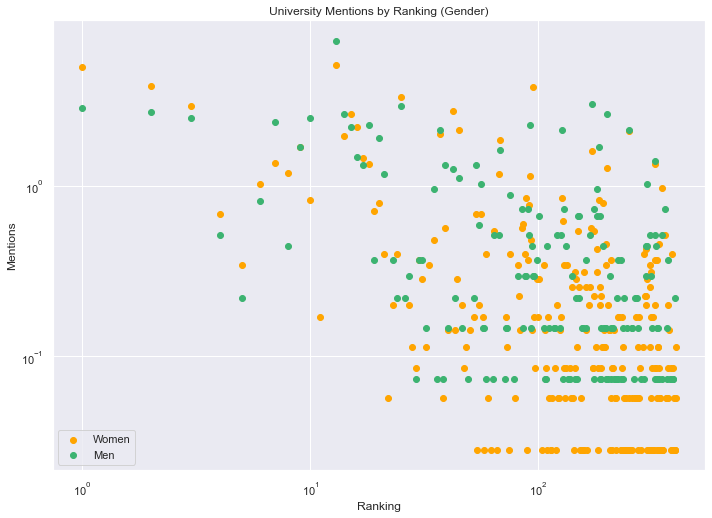

In [252]:
# Ranking of mentions of women
# Re-calculate according to gender

#times15 = pd.read_csv('data/timesData-2015rankings.csv')
#for i in np.arange(201,402):
#    times15.loc[i-1,"world_rank"]= i
times15["c_total_f"] = 0; times15["c_breit_f"] = 0; times15["c_nyp_f"] = 0; times15["c_fox_f"] = 0;
times15["c_cnn_f"] = 0; times15["c_nyt_f"] = 0; times15["c_huff_f"] = 0# introduce column to count university mentions
for i, x in times15.iterrows():
    univ = x.university_name
    total = 0
    for l in ["BREIT","NYP","FOX","CNN","NYT","HUFF"]:
        df_slice = whole_educ_clean[whole_educ_clean.outlet == l]
        df_slice = df_slice[df_slice.educ_inst.str.contains(univ)]
        df_slice = df_slice[df_slice["female_t"] > 0]
        times15.loc[i,"c_"+l.lower()+"_f"] = df_slice.shape[0]
        total += df_slice.shape[0]
    times15.loc[i,"c_total_f"] = total
times15["c_total_m"] = 0; times15["c_breit_m"] = 0; times15["c_nyp_m"] = 0; times15["c_fox_m"] = 0;
times15["c_cnn_m"] = 0; times15["c_nyt_m"] = 0; times15["c_huff_m"] = 0# introduce column to count university mentions
for i, x in times15.iterrows():
    univ = x.university_name
    total = 0
    for l in ["BREIT","NYP","FOX","CNN","NYT","HUFF"]:
        df_slice = whole_educ_clean[whole_educ_clean.outlet == l]
        df_slice = df_slice[df_slice.educ_inst.str.contains(univ)]
        df_slice = df_slice[df_slice["male_t"] > 0]
        times15.loc[i,"c_"+l.lower()+"_m"] = df_slice.shape[0]
        total += df_slice.shape[0]
    times15.loc[i,"c_total_m"] = total

print("WOMEN")
women_cit = pd.DataFrame([times15.index.values,times15.c_total_f.values]).T
women_cit.columns = ['rank_', 'citations']
women_cit["citations_norm"] = women_cit.citations / women_cit.citations.sum()
print("Gini: ",gini(np.array(list(itertools.chain.from_iterable([[int(i)]*int(x.citations) for i, x in women_cit.iterrows()])))))
print("WITH ZERO COUNTS")
print("Spearman corr: ",scipy.stats.spearmanr(women_cit.rank_.values,women_cit.citations.values))
print("Pearson corr: ",scipy.stats.pearsonr(women_cit.rank_.values,women_cit.citations.values))
#women_cit = women_cit[women_cit.citations > 0]
print("WITHOUT ZERO COUNTS")
print("Spearman corr: ",scipy.stats.spearmanr(women_cit.rank_.values,women_cit.citations.values))
print("Pearson corr:",pearsonr(women_cit.rank_.values,women_cit.citations))

print("\nMEN")
men_cit = pd.DataFrame([times15.index.values,times15.c_total_m.values]).T
men_cit.columns = ['rank_', 'citations']
men_cit["citations_norm"] = men_cit.citations / men_cit.citations.sum()
print("Gini: ",gini(np.array(list(itertools.chain.from_iterable([[int(i)]*int(x.citations) for i, x in men_cit.iterrows()])))))
print("WITH ZERO COUNTS")
print("Spearman corr: ",scipy.stats.spearmanr(men_cit.rank_.values,men_cit.citations.values))
print("Pearson corr: ",scipy.stats.pearsonr(men_cit.rank_.values,men_cit.citations.values))
#men_cit = men_cit[men_cit.citations > 0]
print("WITHOUT ZERO COUNTS")
print("Spearman corr: ",scipy.stats.spearmanr(men_cit.rank_.values,men_cit.citations.values))
print("Pearson corr:",pearsonr(men_cit.rank_.values,men_cit.citations))

N = 401
fig, ax = plt.subplots()
ax.scatter(men_cit.rank_, men_cit.citations_norm * 100,color='orange',label='Women')
ax.scatter(women_cit.rank_, women_cit.citations_norm * 100,color='mediumseagreen',label='Men')
plt.xlabel("Ranking")
plt.ylabel("Mentions")
plt.title("University Mentions by Ranking (Gender)")
ax.set_yscale('log')
ax.legend(loc=3)
ax.set_xscale('log')


Text(0.5, 1.0, '100 Highest Ranked Universities as Percent of Total Mentions')

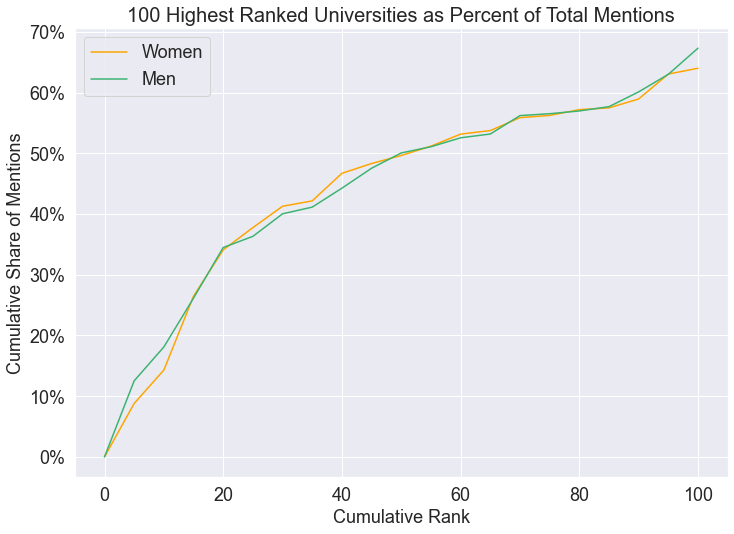

In [253]:
cumulative_pct = pd.DataFrame()
for n in np.arange(0,105,5):
    cumulative_pct = cumulative_pct.append([[n,women_cit[:n].citations_norm.sum(),men_cit[:n].citations_norm.sum(),women_cit[:n].citations.sum(), men_cit[:n].citations.sum()]])
cumulative_pct.index = np.arange(cumulative_pct.shape[0])
cumulative_pct.columns = ['n','pct_w','pct_m','sum_w','sum_m']
#cumulative_pct = cumulative_pct[1:]

plt.plot(cumulative_pct.n,cumulative_pct.pct_w, color='orange', label = 'Women')
plt.plot(cumulative_pct.n,cumulative_pct.pct_m, color='mediumseagreen', label = 'Men')
plt.legend(fontsize=18)
plt.xlabel("Cumulative Rank",fontsize=18)
plt.ylabel("Cumulative Share of Mentions",fontsize=18)
plt.yticks(np.arange(0.0,.75,0.1),[str(k)+"%" for k in np.arange(0,75,10)],fontsize=18)
plt.xticks(fontsize=18)
plt.title("100 Highest Ranked Universities as Percent of Total Mentions",fontsize=20)

In [254]:
cumulative_pct

,n,pct_w,pct_m,sum_w,sum_m
0,0,0.000000,0.000000,0,0
1,5,0.087977,0.125212,120,442
2,10,0.142962,0.181020,195,639
3,15,0.264663,0.261473,361,923
4,20,0.340909,0.344759,465,1217
5,25,0.377566,0.363173,515,1282
6,30,0.412757,0.400283,563,1413
7,35,0.421554,0.411331,575,1452
8,40,0.467009,0.442493,637,1562
9,45,0.483138,0.475354,659,1678


[None, None, None, None]

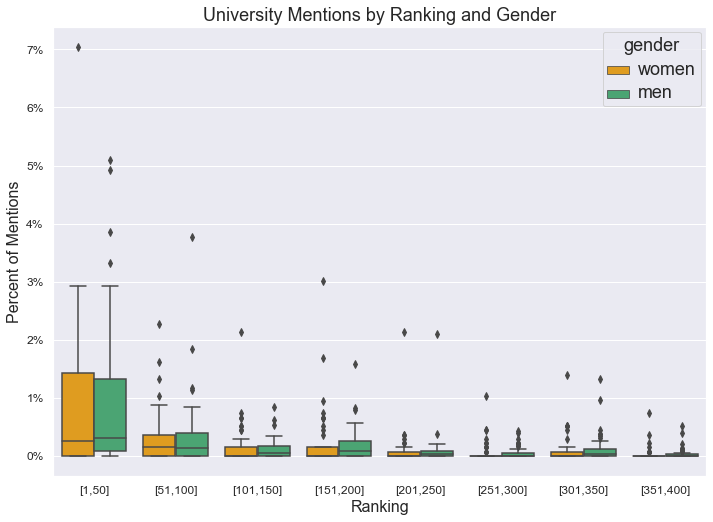

In [1047]:
women_cit2 = women_cit.copy()
women_cit2.columns = ['rank_', 'citations', 'norm']
women_cit2["gender"] = 'women'
men_cit2 = men_cit.copy()
men_cit2.columns = ['rank_', 'citations', 'norm']
men_cit2["gender"] = 'men'
gender_cit2 = pd.concat([women_cit2,men_cit2])
colors = ['orange','mediumseagreen','violet']
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_palette(sns.color_palette(colors))

gender_cit2["bin"] = 0
for i in np.arange(0,8):
    if i == 0:
        gender_cit2.loc[np.arange(i*50,50+i*50),"bin"] = i
    else:
        gender_cit2.loc[np.arange(1+i*50,50+i*50),"bin"] = i


bins_names = ["[1,50]","[51,100]","[101,150]","[151,200]","[201,250]","[251,300]","[301,350]","[351,400]"]
p = sns.boxplot(y='norm',x='bin',data=gender_cit2,hue='gender')
p.set_xlabel("Ranking",fontsize=16)
p.set_ylabel("Percent of Mentions",fontsize=16)
plt.xticks(np.arange(8),bins_names,fontsize=12)
plt.yticks(np.arange(0,0.07,0.01),["0%","1%","2%","3%","4%","5%","6%","7%"],fontsize=12)
plt.title("University Mentions by Ranking and Gender", fontsize=18)
plt.setp(p.get_legend().get_title(), fontsize=18)
plt.setp(p.get_legend().get_texts(), fontsize=18)


In [1509]:
times15[times15.university_name.str.contains("Washington")]

,world_rank,university_name,country,teaching,international,research,citations,income,total_score,num_students,...,c_cnn_f,c_nyt_f,c_huff_f,c_total_m,c_breit_m,c_nyp_m,c_fox_m,c_cnn_m,c_nyt_m,c_huff_m
25,26,University of Washington,United States of America,64.5,47.9,68.9,95.0,44.7,73.2,"44,020",...,7,22,7,117,7,4,14,34,41,17
41,42,Washington University in St Louis,United States of America,57.6,46.5,55.2,97.1,-,67.8,"12,528",...,0,0,0,0,0,0,0,0,0,0
200,201,George Washington University,United States of America,44.6,39.9,25.1,70.0,29.3,45.6,"20,541",...,11,13,9,45,1,0,4,17,16,7
397,398,Washington State University,United States of America,28.5,36.0,27.5,44.2,54.5,-,"24,550",...,1,1,1,1,1,0,0,0,0,0


[None, None, None, None]

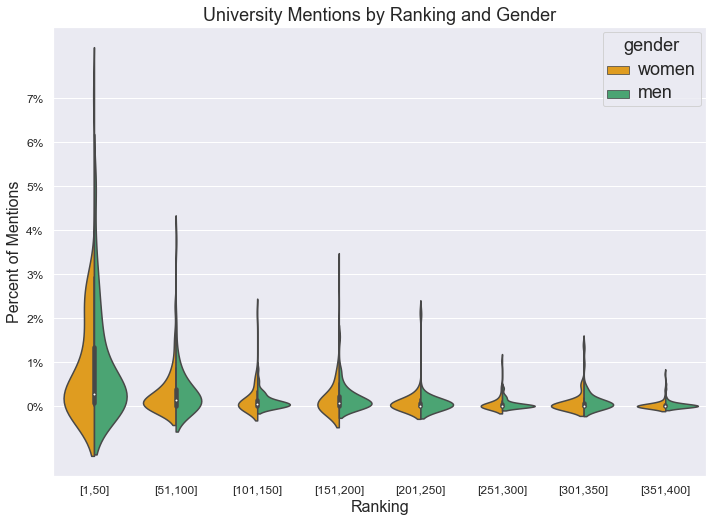

In [1055]:

bins_names = ["[1,50]","[51,100]","[101,150]","[151,200]","[201,250]","[251,300]","[301,350]","[351,400]"]
p = sns.violinplot(y='norm',x='bin',data=gender_cit2,hue='gender',split=True)
p.set_xlabel("Ranking",fontsize=16)
p.set_ylabel("Percent of Mentions",fontsize=16)
plt.xticks(np.arange(8),bins_names,fontsize=12)
plt.yticks(np.arange(0,0.07,0.01),["0%","1%","2%","3%","4%","5%","6%","7%"],fontsize=12)
plt.title("University Mentions by Ranking and Gender", fontsize=18)
plt.setp(p.get_legend().get_title(), fontsize=18)
plt.setp(p.get_legend().get_texts(), fontsize=18)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  if sys.path[0] == '':


array([[ 1.        , -0.36773099],
       [-0.36773099,  1.        ]])

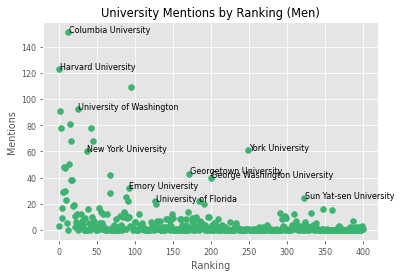

In [328]:
# Ranking of mentions of women
times15 = pd.read_csv('timesData-2015rankings.csv')
for i in np.arange(201,402):
    times15.loc[i-1,"world_rank"]= i
times15["c_total"] = 0; times15["c_breit"] = 0; times15["c_nyp"] = 0; times15["c_fox"] = 0;
times15["c_cnn"] = 0; times15["c_nyt"] = 0; times15["c_huff"] = 0# introduce column to count university mentions
for i, x in times15.iterrows():
    univ = x.university_name
    total = 0
    for l in ["BREIT","NYP","FOX","CNN","NYT","HUFF"]:
        df_slice = whole_educ_clean[whole_educ_clean.outlet == l]
        df_slice = df_slice[df_slice.educ_inst.str.contains(univ)]
        df_slice = df_slice[df_slice["male_t"] > 0]
        times15.loc[i,"c_"+l.lower()] = df_slice.shape[0]
        total += df_slice.shape[0]
    times15.loc[i,"c_total"] = total

N = 401
fig, ax = plt.subplots()
ax.scatter(times15.index,times15.c_huff + times15.c_nyt + times15.c_cnn,color='mediumseagreen')
for i, x in times15.iterrows():
    if i in [13,1,25,37,92,127,172,200,249,323]:
        plt.text(x=i+1, y=x.c_huff + x.c_nyt + x.c_cnn, s=x.university_name)
    #plt.text(x=i+1, y=x.c_huff + x.c_nyt + x.c_cnn, s=i)
plt.xlabel("Ranking")
plt.ylabel("Mentions")
plt.title("University Mentions by Ranking (Men)")
    #plt.text(x=i,y=x.c_total,s=i)
np.corrcoef(times15.index,times15.c_huff + times15.c_nyt + times15.c_cnn)

In [ ]:
def get_unique(df,col):
    past = []
    for idx, row in df.iterrows():
        if isinstance(ast.literal_eval(str(row[col])),list):
            for x in ast.literal_eval(str(row[col])):
                if x not in past:
                    past.append(x)
        else:
            if str(row[col]) not in past:
                past.append(row[col])
    print("Number of unique values for ",col, len(past))

def venn_stats(df,cols):
    print("Total instances: ",df.shape[0])
    for col in cols:
        get_unique(df,col)

print("Stats for yiwen_extr")
yiwen_extr = pd.read_csv("yiwen_extr_consolidated.csv").drop(columns=['Unnamed: 0'])
yiwen_extr.columns = ['people','orgs','source','date','title','quote']
#yiwen_extr.loc[~yiwen_extr['people'].str.contains("\["),"people"] = "['" + yiwen_extr.loc[~yiwen_extr['people'].str.contains("\[")]['people'] + "']"
yiwen_extr.loc[:,"quote"] = yiwen_extr.loc[:,"quote"].str.replace('[','').str.replace(']','')
venn_stats(yiwen_extr,['people','orgs'])

print("Stats for yiwen_educ2")
yiwen_educ2 = pd.read_csv("yiwen_educ2_consolidated.csv").drop(columns=['Unnamed: 0'])
yiwen_educ2 = yiwen_educ2.drop_duplicates(subset=['quote','people'])
yiwen_educ2.loc[:,"quote"] = yiwen_educ2.loc[:,"quote"].str.replace('[','').str.replace(']','')
#yiwen_educ2['educ_inst'] = "'" + yiwen_educ2['educ_inst'].map(str) + "'"
venn_stats(yiwen_educ2,['educ_inst','people'])

print("Stats for yiwen union nyt_qse1")
nyt_union = union_df(nyt_qse_m1,yiwen_extr,['quote'])
venn_stats(nyt_union,['people','orgs'])

print("Stats for yiwen union nyt_educ1")
nyt_educ_m1 = pd.read_csv("nyt_educ_m1.csv")
nyt_educ_m1['educ_inst'] = "'" + nyt_educ_m1['educ_inst'].map(str) + "'"
nyt_union = union_df(nyt_educ_m1,yiwen_educ2,['quote','people','educ_inst'])
venn_stats(nyt_union,['people','educ_inst'])

print("Stats for yiwen intersect nyt_qse1")
nyt_intersect = intersect_df(nyt_qse_m1,yiwen_extr,['quote','people','orgs'])
venn_stats(nyt_intersect,['people','orgs'])

print("Stats for yiwen intersect nyt_educ1")
nyt_intersect = intersect_df(nyt_educ_m1,yiwen_educ2,['quote','people','educ_inst'])
venn_stats(nyt_intersect,['people','educ_inst'])

#nyt_educ_union = union_Df(nyt_educ_m1,)

In [ ]:
nyt_qse = pd.read_csv("nyt_qse.csv")
fox_qse = pd.read_csv("fox_qse_m1.csv")
news_orgs = ['New York Times', 'CNN', 'Fox News', 'Breitbart', 'New York Post', 'Huffington Post']
news_dfs = [nyt_df, cnn_df, fox_df, breit_df, nyp_df, huff_df]
qse_dfs = [nyt_qse, cnn_qse, fox_qse, breit_qse, nyp_qse, huff_qse]
original_instances = [df.shape[0] for df in news_dfs]
qse_instances = [df_qse.shape[0] for df_qse in qse_dfs]

df = pd.DataFrame([original_instances, qse_instances])
df.columns = news_orgs
df.index = ['Original','Processed']
df = df.T
df['News_Org'] = news_orgs
df

x = np.arange(6)
width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, original_instances, width, label='Original Dataset')
rects2 = ax.bar(x + width/2, qse_instances, width, label='Processed Dataset')
ax.legend()
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2,padding=3)
ax.set_xticks(x)
ax.set_xticklabels(news_orgs, rotation = 75)
ax.set_title("Dataframe Sizes")
fig.tight_layout()

In [ ]:
news_dfs = [nyt_df, cnn_df, fox_df, breit_df, nyp_df, huff_df]
becca_dfs = [b_nyt_qse, b_cnn_qse, b_fox_qse, b_breit_qse, b_nyp_qse, b_huff_qse]
yiwen_dfs = [y_nyt_qse, y_cnn_qse, y_fox_qse, y_breit_qse, y_nyp_qse, y_huff_qse]
becca_dfs_educ = [b_nyt_educ, b_cnn_educ, b_fox_educ, b_breit_educ, b_nyp_educ, b_huff_educ]
yiwen_dfs_educ = [y_nyt_educ, y_cnn_educ, y_fox_educ, y_breit_educ, y_nyp_educ, y_huff_educ]
comparing_numbers = [[df.shape[0] for df in news_dfs],[df.shape[0] for df in becca_dfs],[df.shape[0] for df in yiwen_dfs],
                    [df.shape[0] for df in becca_dfs_educ], [df.shape[0] for df in yiwen_dfs_educ]]
plotting_numbers = pd.DataFrame(comparing_numbers).T
plotting_numbers.columns = ['articles','dep_extractions','ner_extractions','dep_educ','ner_educ']
plotting_numbers.index = ['NYT','CNN','FOX','BREIT','NYP','HUFF']

n = 3
ind = np.arange(6)
width = 0.2

fig = plt.figure()
ax = fig.add_subplot(111)

rects1 = ax.bar(ind-width,plotting_numbers.articles,width,color='r')
rects2a = ax.bar(ind,plotting_numbers.dep_extractions,width,color='g')
rects2b = ax.bar(ind,plotting_numbers.ner_extractions,width,bottom=plotting_numbers.dep_extractions,color='y')
rects3 = ax.bar(ind+width,plotting_numbers.dep_educ+plotting_numbers.ner_educ,width,color='b')

ax.set_ylabel("Instances")
ax.set_xticklabels(['NYT','NYT','CNN','FOX','BREIT','NYP','HUFF'])
ax.legend((rects1[0],rects2a[0],rects2b[0],rects3[0]),('original articles','total extractions (dep)','total extractions (ner)','educ-affiliated extractions'))
def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.01*h, '%d'%int(h),
                ha='center', va='bottom')
autolabel(rects1)
autolabel(rects2a)
#autolabel(rects2b)
for rect, total in zip(rects2b,plotting_numbers.dep_extractions):
    h = rect.get_height() + total
    ax.text(rect.get_x()+rect.get_width()/2., 1.01*h, '%d'%int(h),
        ha='center', va='bottom')
autolabel(rects3)
ax.set_title("Numbers of Extractions")

plotting_numbers

In [ ]:
news_dfs = [nyt_df, cnn_df, fox_df, breit_df, nyp_df, huff_df]
becca_dfs = [b_nyt_qse, b_cnn_qse, b_fox_qse, b_breit_qse, b_nyp_qse, b_huff_qse]
yiwen_dfs = [y_nyt_qse, y_cnn_qse, y_fox_qse, y_breit_qse, y_nyp_qse, y_huff_qse]
becca_dfs_educ = [b_nyt_educ, b_cnn_educ, b_fox_educ, b_breit_educ, b_nyp_educ, b_huff_educ]
yiwen_dfs_educ = [y_nyt_educ, y_cnn_educ, y_fox_educ, y_breit_educ, y_nyp_educ, y_huff_educ]
comparing_numbers = [[df.shape[0] for df in news_dfs],[df.shape[0] for df in becca_dfs],[df.shape[0] for df in yiwen_dfs],
                    [df.shape[0] for df in becca_dfs_educ], [df.shape[0] for df in yiwen_dfs_educ]]
plotting_numbers = pd.DataFrame(comparing_numbers).T
plotting_numbers.columns = ['articles','dep_extractions','ner_extractions','dep_educ','ner_educ']
plotting_numbers.index = ['NYT','CNN','FOX','BREIT','NYP','HUFF']

n = 4
ind = np.arange(6)
width = 0.2

fig = plt.figure()
ax = fig.add_subplot(111)

rects1 = ax.bar(ind-width/2,(plotting_numbers.dep_extractions + plotting_numbers.ner_extractions)/plotting_numbers.articles,width,color='lightpink')
rects2 = ax.bar(ind-width/4,total_univ_y/(plotting_numbers.dep_extractions + plotting_numbers.ner_extractions),width,color='orchid')
rects3 = ax.bar(ind+width/4,total_univ_b/(plotting_numbers.dep_extractions + plotting_numbers.ner_extractions),width,color='gold')
rects4 = ax.bar(ind+width/2,(plotting_numbers.dep_educ + plotting_numbers.ner_educ)/(plotting_numbers.dep_extractions + plotting_numbers.ner_extractions),width,color='skyblue')

ax.set_ylabel("Instances")
ax.set_xticklabels(['NYT','NYT','CNN','FOX','BREIT','NYP','HUFF'])
ax.legend((rects1[0],rects2[0],rects3[0],rects4[0]),('total_extractions/articles','% mentioning university (dep)','% mentioning university (ner)','educ_extractions/total_extractions'))
def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        print(h)
        ax.text(rect.get_x()+rect.get_width()/2., 1.01*h, str(h)[:4] + '%',
                ha='center', va='bottom')
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)
ax.set_title("Numbers of Extractions")

plotting_numbers

In [ ]:
#plotting_numbers.dep_extractions, plotting_numbers.ner_extractions
fig, axes = plt.subplots(2,3)
pd.DataFrame([plotting_numbers.dep_extractions[0],plotting_numbers.ner_extractions[0]]).plot(kind='pie',figsize=(5,5),labels=['DEP','NER'],autopct='%1.1f%%',subplots=True,ax = axes[0,0])
axes[0,0].get_legend().remove()
axes[0,0].title.set_text('NYT')
pd.DataFrame([plotting_numbers.dep_extractions[1],plotting_numbers.ner_extractions[1]]).plot(kind='pie',figsize=(5,5),labels=['DEP','NER'],autopct='%1.1f%%',subplots=True,ax = axes[0,1])
axes[0,1].get_legend().remove()
axes[0,1].title.set_text('CNN')
pd.DataFrame([plotting_numbers.dep_extractions[2],plotting_numbers.ner_extractions[2]]).plot(kind='pie',figsize=(5,5),labels=['DEP','NER'],autopct='%1.1f%%',subplots=True,ax = axes[0,2])
axes[0,2].get_legend().remove()
axes[0,2].title.set_text('FOX')
pd.DataFrame([plotting_numbers.dep_extractions[3],plotting_numbers.ner_extractions[3]]).plot(kind='pie',figsize=(5,5),labels=['DEP','NER'],autopct='%1.1f%%',subplots=True,ax = axes[1,0])
axes[1,0].get_legend().remove()
axes[1,0].title.set_text('BREIT')
pd.DataFrame([plotting_numbers.dep_extractions[4],plotting_numbers.ner_extractions[4]]).plot(kind='pie',figsize=(5,5),labels=['DEP','NER'],autopct='%1.1f%%',subplots=True,ax = axes[1,1])
axes[1,1].get_legend().remove()
axes[1,1].title.set_text('NYP')
pd.DataFrame([plotting_numbers.dep_extractions[5],plotting_numbers.ner_extractions[5]]).plot(kind='pie',figsize=(5,5),labels=['DEP','NER'],autopct='%1.1f%%',subplots=True,ax = axes[1,2])
axes[1,2].get_legend().remove()
axes[1,2].title.set_text('HUFF')
fig.suptitle("Distribution of Total Extractions")

In [ ]:
n = 3
ind = np.arange(6)
width = 0.2

fig = plt.figure()
ax = fig.add_subplot(111)

rects1 = ax.bar(ind-width/2,total_univ_y/(plotting_numbers.dep_extractions + plotting_numbers.ner_extractions),width,color='orchid')
rects2 = ax.bar(ind,total_univ_b/(plotting_numbers.dep_extractions + plotting_numbers.ner_extractions),width,color='gold')
rects3 = ax.bar(ind+width/2,(plotting_numbers.dep_educ + plotting_numbers.ner_educ)/(plotting_numbers.dep_extractions + plotting_numbers.ner_extractions),width,color='skyblue')
ax.set_ylabel("Fraction of Extractions")
ax.set_xticklabels(['NYT','NYT','CNN','FOX','BREIT','NYP','HUFF'])
ax.legend((rects1[0],rects2[0],rects3[0],rects4[0]),('extractions mentioning university (yiwen)','extractions mentioning university (becca)','extractions matching to a university'))
def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        print(h)
        ax.text(rect.get_x()+rect.get_width()/2., 1.01*h, str(h)[:4] ,
                ha='center', va='bottom')
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)


In [ ]:
total_univ_b = []
total_univ_y = []
for dfb,dfy in zip([b_nyt_qse,b_cnn_qse,b_fox_qse,b_breit_qse,b_nyp_qse,b_huff_qse],[y_nyt_qse,y_cnn_qse,y_fox_qse,y_breit_qse,y_nyp_qse,y_huff_qse]):
    total_univ_b.append(dfb[dfb["quote"].str.contains('University|College|university|college')].shape[0])
    total_univ_y.append(dfy[dfy["quote"].str.contains('University|College|university|college')].shape[0])
print(sum(total_univ_b),sum(total_univ_y))

In [ ]:
# GENDER ANALYSIS
nyt_qse_all = pd.concat([b_nyt_qse,y_nyt_qse])
nyt_qse_all = get_genders(nyt_qse_all)
a, b = plot_total_bygender(nyt_qse_all) # what is a, b?

In [ ]:
# GENDER ANALYSIS
nyt_educ_all = pd.concat([b_nyt_educ,y_nyt_educ])
nyt_educ_all = get_genders(nyt_educ_all)
print("got genders")
a, b = plot_total_bygender(nyt_educ_all) # what is a, b?

In [ ]:
# GENDER ANALYSIS
breit_qse_all = pd.concat([b_breit_qse,y_breit_qse])
breit_qse_all = get_genders(breit_qse_all)
print("got genders")
a, b = plot_total_bygender(breit_qse_all,"Breitbart (Total)") # what is a, b?

breit_educ_all = pd.concat([b_breit_educ,y_breit_educ])
breit_educ_all = get_genders(breit_educ_all)
print("got genders")
a, b = plot_total_bygender(breit_educ_all,"Breitbart Educ (Total)") # what is a, b?

In [ ]:
# GENDER ANALYSIS

cnn_qse_all = pd.concat([b_cnn_qse,y_cnn_qse])
cnn_qse_all["people"] = cnn_qse_all["people"].replace('\'','', regex=True).str.replace('[','[\'',regex=True).str.replace(']','\']').replace(',','\', \'').str.replace('\\','')
cnn_qse_all.loc[1620,'people'] = "['Robert Mueller','Donald Trump']"
cnn_qse_all = get_genders(cnn_qse_all)
print("got genders")
a, b = plot_total_bygender(cnn_qse_all,"CNN (Total)") # what is a, b?

cnn_educ_all = pd.concat([b_cnn_educ,y_cnn_educ])
cnn_educ_all["people"] = cnn_educ_all["people"].replace('\'','', regex=True).str.replace('[','[\'',regex=True).str.replace(']','\']').replace(',','\', \'')
cnn_educ_all = get_genders(cnn_educ_all)
print("got genders")
a, b = plot_total_bygender(cnn_educ_all,"CNN Educ (Total)") # what is a, b?

In [ ]:
# GENDER ANALYSIS

fox_qse_all = pd.concat([b_fox_qse,y_fox_qse])
fox_qse_all["people"] = fox_qse_all["people"].replace('\'','', regex=True).str.replace('[','[\'',regex=True).str.replace(']','\']').replace(',','\', \'').str.replace('\\','')
fox_qse_all = get_genders(fox_qse_all)
print("got genders")
a, b = plot_total_bygender(fox_qse_all,"Fox (Total)") # what is a, b?

fox_educ_all = pd.concat([b_fox_educ,y_fox_educ])
fox_educ_all["people"] = fox_educ_all["people"].replace('\'','', regex=True).str.replace('[','[\'',regex=True).str.replace(']','\']').replace(',','\', \'')
fox_educ_all = get_genders(fox_educ_all)
print("got genders")
a, b = plot_total_bygender(fox_educ_all,"Fox Educ (Total)") # what is a, b?

In [ ]:
d = gender.Detector()
g = d.get_gender('Arturo')
g
nyp_qse_all[nyp_qse_all['unknown'] > 0][10:]
"Margaret Huang".split(" ")[0]

In [ ]:
# GENDER ANALYSIS

nyp_qse_all = pd.concat([b_nyp_qse,y_nyp_qse])
nyp_qse_all["people"] = nyp_qse_all["people"].replace('\'','', regex=True).str.replace('[','[\'',regex=True).str.replace(']','\']').replace(',','\', \'').str.replace('\\','')
nyp_qse_all.loc[7,'people'] = "[\'Thomas Modly\']"
nyp_qse_all = get_genders(nyp_qse_all)
print("got genders")
a, b = plot_total_bygender(nyp_qse_all,"NYP (Total)") # what is a, b?

nyp_educ_all = pd.concat([b_nyp_educ,y_nyp_educ])
nyp_educ_all["people"] = nyp_educ_all["people"].replace('\'','', regex=True).str.replace('[','[\'',regex=True).str.replace(']','\']').replace(',','\', \'')
nyp_educ_all = get_genders(nyp_educ_all)
print("got genders")
a, b = plot_total_bygender(nyp_educ_all,"NYP Educ (Total)") # what is a, b?

In [ ]:
# GENDER ANALYSIS

huff_qse_all = pd.concat([b_huff_qse,y_huff_qse])
huff_qse_all["people"] = huff_qse_all["people"].replace('\'','', regex=True).str.replace('[','[\'',regex=True).str.replace(']','\']').replace(',','\', \'').str.replace('\\','')
huff_qse_all.loc[7,'people'] = "[\'Thomas Modly\']"
huff_qse_all = get_genders(huff_qse_all)
print("got genders")
a, b = plot_total_bygender(huff_qse_all,"Huff (Total)") # what is a, b?

huff_educ_all = pd.concat([b_huff_educ,y_huff_educ])
huff_educ_all["people"] = huff_educ_all["people"].replace('\'','', regex=True).str.replace('[','[\'',regex=True).str.replace(']','\']').replace(',','\', \'')
huff_educ_all = get_genders(huff_educ_all)
print("got genders")
a, b = plot_total_bygender(huff_educ_all,"Huff Educ (Total)") # what is a, b?

In [ ]:
huff_qse_all = pd.concat([b_huff_qse,y_huff_qse])
huff_qse_all["people"] = huff_qse_all["people"].replace('\'','', regex=True).str.replace('[','[\'',regex=True).str.replace(']','\']').replace(',','\', \'').str.replace('\\','')
nyp_qse_all = pd.concat([b_nyp_qse,y_nyp_qse])
nyp_qse_all["people"] = nyp_qse_all["people"].replace('\'','', regex=True).str.replace('[','[\'',regex=True).str.replace(']','\']').replace(',','\', \'').str.replace('\\','')
nyp_qse_all.loc[7,'people'] = "[\'Thomas Modly\']"
fox_qse_all = pd.concat([b_fox_qse,y_fox_qse])
fox_qse_all["people"] = fox_qse_all["people"].replace('\'','', regex=True).str.replace('[','[\'',regex=True).str.replace(']','\']').replace(',','\', \'').str.replace('\\','')
fox_qse_all.loc[3755,'people'] = "['Joe Biden', 'Jeet Heer']"
fox_qse_all.loc[6044,'people'] = "['Bolton', 'Ayatollahs', 'Khamenei', 'Baier']"
cnn_qse_all = pd.concat([b_cnn_qse,y_cnn_qse])
cnn_qse_all["people"] = cnn_qse_all["people"].replace('\'','', regex=True).str.replace('[','[\'',regex=True).str.replace(']','\']').replace(',','\', \'').str.replace('\\','')
cnn_qse_all.loc[1620,'people'] = "['Robert Mueller','Donald Trump']"
breit_qse_all = pd.concat([b_breit_qse,y_breit_qse])
nyt_qse_all = pd.concat([b_nyt_qse,y_nyt_qse])

for df in [nyt_qse_all,cnn_qse_all,huff_qse_all,fox_qse_all,nyp_qse_all,breit_qse_all]:
    df.index = np.arange(df.shape[0])
    df = get_genders(df)

In [ ]:
for df, label in zip([nyt_qse_all,cnn_qse_all,huff_qse_all,fox_qse_all,nyp_qse_all,breit_qse_all],["NYT","CNN","HUFF","FOX","NYP","BREIT"]):
    plot_unique_bygender(df,label,"./genders/unique_qse_"+label+".png") # note that this is actually total

In [ ]:
for df, label in zip([nyt_gov_all, huff_gov_all, cnn_gov_all, fox_gov_all,nyp_gov_all,breit_gov_all],["NYT","HUFF","CNN","FOX","NYP","BREIT"]):
    plot_unique_bygender(df,label,"./genders/unique_gov_"+label+".png")

In [ ]:
breit_qse_all[breit_qse_all.gender.str.contains("unknown")]["people"].value_counts()

In [ ]:
# Government agencies get_genders

huff_gov_all = pd.concat([b_huff_gov, y_huff_gov])
huff_gov_all['people'] = '[\'' + huff_gov_all['people'].str.replace('\[\'','',regex=True).str.replace('\']','',regex=True).str.replace(',','\', \'') + '\']'
huff_gov_all.loc[21,'people'] = "['Anthony Fauci','Mike Pence','Deborah Birx']"
huff_gov_all.loc[24,'people'] = "['Scott Lamb']"
huff_gov_all.loc[203,'people'] = "['Chuck Schumer']"
huff_gov_all.loc[50,'people'] = "['Chuck Schumer']"
huff_gov_all.loc[151,'people'] = "['Michael Flynn']"
huff_gov_all.loc[232,'people'] = "['Ira Forman']"
huff_gov_all.loc[353,'people'] = "['Mitsch Bush']"
huff_gov_all.loc[354,'people'] = "['Mitsch Bush']"
nyp_gov_all = pd.concat([b_nyp_gov,y_nyp_gov])
nyp_gov_all.loc[~nyp_gov_all['people'].str.contains("\["),"people"] = "['" + nyp_gov_all.loc[~nyp_gov_all['people'].str.contains("\["),'people'] + "']"
#nyp_gov_all['people'] = '[\'' + nyp_gov_all['people'].str.replace('\[\'','',regex=True).str.replace('\']','',regex=True).str.replace(',','\', \'').str.replace('\[\"','').str.replace('\"]','').str.replace("\\\\n\'","") + '\']'
nyp_gov_all.loc[22,'people'] = "['Mike Andrews']"
nyp_gov_all.loc[31,'people'] = "['Fox News']"
nyp_gov_all.loc[464,'people'] = "['Gualberto Ruiz']"
nyp_gov_all.loc[75,'people'] = "['Miranda Barbot']"
nyp_gov_all.loc[106,'people'] = "['Corey Johnson']"
nyp_gov_all.loc[170,'people'] = "['Rachel Semmel']"
nyp_gov_all.loc[171,'people'] = "['Julie Gerberding']"
nyp_gov_all.loc[174,'people'] = "['Chen Shih-Chung']"
nyp_gov_all.loc[226,'people'] = "['Michael Strahan']"
nyt_gov_all = pd.concat([b_nyt_gov,y_nyt_gov])
nyt_gov_all['people'] = '[\'' + nyt_gov_all['people'].str.replace('\[\'','',regex=True).str.replace('\']','',regex=True).str.replace(',','\', \'') + '\']'
cnn_gov_all = pd.concat([b_cnn_gov,y_cnn_gov])
cnn_gov_all.loc[~cnn_gov_all['people'].str.contains("\["),"people"] = "['" + cnn_gov_all.loc[~cnn_gov_all['people'].str.contains("\[")]['people'] + "']"
cnn_gov_all['people'] = cnn_gov_all['people'].str.replace("''","'").str.replace("'s","")
cnn_gov_all.loc[648,'people'] = "['Sanders']"
cnn_gov_all.loc[131,'people'] = "['Tonny Fratto','George W. Bush']"
cnn_gov_all.loc[771,'people'] = "['George Bush']"
cnn_gov_all.loc[1380,'people'] = "['Williams']"
cnn_gov_all.loc[1205,'people'] = "['Evers']"
cnn_gov_all.loc[2046,'people'] = "['Evers']"
cnn_gov_all.loc[2066,'people'] = "[\"O'Brien\"]"
cnn_gov_all.loc[2128,'people'] = "['Peter Navarro']"
fox_gov_all = pd.concat([b_fox_gov,y_fox_gov])
fox_gov_all.loc[~fox_gov_all['people'].str.contains("\["),"people"] = "['" + fox_gov_all.loc[~fox_gov_all['people'].str.contains("\[")]['people'] + "']"
fox_gov_all['people'] = fox_gov_all['people'].str.replace("''","'").str.replace("'s","")
fox_gov_all.loc[2002,'people'] = "[\"Daniel O'Day\"]"
breit_gov_all = pd.concat([b_breit_gov,y_breit_gov])
breit_gov_all.loc[~breit_gov_all['people'].str.contains("\["),"people"] = "['" + breit_gov_all.loc[~breit_gov_all['people'].str.contains("\[")]['people'] + "']"

for df in [huff_gov_all,nyp_gov_all,nyt_gov_all,cnn_gov_all,fox_gov_all,breit_gov_all]:
    df.index = np.arange(df.shape[0])
    df = get_genders(df)

for df, label in zip([nyt_gov_all, huff_gov_all, cnn_gov_all, fox_gov_all,nyp_gov_all,breit_gov_all],["NYT","HUFF","CNN","FOX","NYP","BREIT"]):
    plot_unique_bygender(df,label,"./genders/unique_gov_"+label+".png")

In [ ]:
# Government agencies get_genders

huff_thinkt_all = pd.concat([b_huff_thinkt, y_huff_thinkt])
huff_thinkt_all.loc[~huff_thinkt_all['people'].str.contains("\["),"people"] = "['" + huff_thinkt_all.loc[~huff_thinkt_all['people'].str.contains("\[")]['people'] + "']"
nyp_thinkt_all = pd.concat([b_nyp_thinkt,y_nyp_thinkt])
nyp_thinkt_all.loc[~nyp_thinkt_all['people'].str.contains("\["),"people"] = "['" + nyp_thinkt_all.loc[~nyp_thinkt_all['people'].str.contains("\["),'people'] + "']"
#nyp_thinkt_all['people'] = '[\'' + nyp_thinkt_all['people'].str.replace('\[\'','',regex=True).str.replace('\']','',regex=True).str.replace(',','\', \'').str.replace('\[\"','').str.replace('\"]','').str.replace("\\\\n\'","") + '\']'
nyt_thinkt_all = pd.concat([b_nyt_thinkt,y_nyt_thinkt])
nyt_thinkt_all['people'] = '[\'' + nyt_thinkt_all['people'].str.replace('\[\'','',regex=True).str.replace('\']','',regex=True).str.replace(',','\', \'') + '\']'
cnn_thinkt_all = pd.concat([b_cnn_thinkt,y_cnn_thinkt])
cnn_thinkt_all.loc[~cnn_thinkt_all['people'].str.contains("\["),"people"] = "['" + cnn_thinkt_all.loc[~cnn_thinkt_all['people'].str.contains("\[")]['people'] + "']"
cnn_thinkt_all['people'] = cnn_thinkt_all['people'].str.replace("''","'").str.replace("'s","")
fox_thinkt_all = pd.concat([b_fox_thinkt,y_fox_thinkt])
fox_thinkt_all.loc[~fox_thinkt_all['people'].str.contains("\["),"people"] = "['" + fox_thinkt_all.loc[~fox_thinkt_all['people'].str.contains("\[")]['people'] + "']"
fox_thinkt_all['people'] = fox_thinkt_all['people'].str.replace("''","'").str.replace("'s","")
breit_thinkt_all = pd.concat([b_breit_thinkt,y_breit_thinkt])
breit_thinkt_all.loc[~breit_thinkt_all['people'].str.contains("\["),"people"] = "['" + breit_thinkt_all.loc[~breit_thinkt_all['people'].str.contains("\[")]['people'] + "']"

for df in [huff_thinkt_all,nyp_thinkt_all,nyt_thinkt_all,cnn_thinkt_all,fox_thinkt_all,breit_thinkt_all]:
    df.index = np.arange(df.shape[0])
    df = get_genders(df)

for df, label in zip([nyt_thinkt_all, huff_thinkt_all, cnn_thinkt_all, fox_thinkt_all,nyp_thinkt_all,breit_thinkt_all],["NYT","HUFF","CNN","FOX","NYP","BREIT"]):#
    plot_unique_bygender(df,label,"./genders/unique_thinkt_"+label+".png")

In [ ]:
for df, label in zip([nyt_thinkt_all, huff_thinkt_all, cnn_thinkt_all, fox_thinkt_all,nyp_thinkt_all,breit_thinkt_all],["NYT","HUFF","CNN","FOX","NYP","BREIT"]):#
    plot_unique_bygender(df,label,"./genders/unique_thinkt_"+label+".png")

In [ ]:
huff_educ_all = pd.concat([b_huff_educ,y_huff_educ])
huff_educ_all["people"] = huff_educ_all["people"].replace('\'','', regex=True).str.replace('[','[\'',regex=True).str.replace(']','\']').replace(',','\', \'')
nyp_educ_all = pd.concat([b_nyp_educ,y_nyp_educ])
nyp_educ_all["people"] = nyp_educ_all["people"].replace('\'','', regex=True).str.replace('[','[\'',regex=True).str.replace(']','\']').replace(',','\', \'')
fox_educ_all = pd.concat([b_fox_educ,y_fox_educ])
fox_educ_all["people"] = fox_educ_all["people"].replace('\'','', regex=True).str.replace('[','[\'',regex=True).str.replace(']','\']').replace(',','\', \'')
cnn_educ_all = pd.concat([b_cnn_educ,y_cnn_educ])
cnn_educ_all["people"] = cnn_educ_all["people"].replace('\'','', regex=True).str.replace('[','[\'',regex=True).str.replace(']','\']').replace(',','\', \'')
breit_educ_all = pd.concat([b_breit_educ,y_breit_educ])
nyt_educ_all = pd.concat([b_nyt_educ,y_nyt_educ])

for df, label in zip([nyt_educ_all,cnn_educ_all,huff_educ_all,fox_educ_all,nyp_educ_all,breit_educ_all],["NYT","CNN","HUFF","FOX","NYP","BREIT"]):
    df = get_genders(df)
    plot_unique_bygender(df,label,"./genders/unique_educ_"+label+".png")

In [ ]:
top_names = pd.DataFrame()
for df in [breit_educ_all,cnn_educ_all,huff_educ_all,fox_educ_all,nyp_educ_all,nyt_educ_all]:
    top_names = top_names.append(df[df.gender.str.contains("unknown")]["people"].value_counts()[:10])
top_names = top_names.T
top_names.columns = ["BREIT","CNN","HUFF","FOX","NYP","NYT"]
top_names  = top_names.replace(np.nan,0)
top_names["sum"] = top_names.apply(np.sum,axis=1)
top_names.sort_values("sum", ascending=False)

In [ ]:
top_names = pd.DataFrame()
for df in [breit_qse_all,cnn_qse_all,huff_qse_all,fox_qse_all,nyp_qse_all,nyt_qse_all]:
    top_names = top_names.append(df[df.gender.str.contains("andy")]["people"].value_counts()[:10])
top_names = top_names.T
top_names.columns = ["BREIT","CNN","HUFF","FOX","NYP","NYT"]
top_names  = top_names.replace(np.nan,0)
top_names["sum"] = top_names.apply(np.sum,axis=1)
top_names.sort_values("sum", ascending=False)

In [ ]:
pd.set_option('max_colwidth', None)
for df in [breit_qse_all,cnn_qse_all,huff_qse_all,fox_qse_all,nyp_qse_all,nyt_qse_all]:
    print(df[df["quote"].str.contains("Hizzoner")].outlet)

In [ ]:
for df, label in zip([fox_educ_all,nyp_educ_all,breit_educ_all],["FOX","NYP","BREIT"]):
    plot_unique_bygender(df,label,"./genders/unique_educ_"+label+".png")

In [ ]:
nyp_gov_all.loc[31,'people'] = "['Fox News']"
nyp_gov_all.loc[226,'people'] = "['Michael Strahan']"
nyp_gov_all[nyp_gov_all['people'].str.contains("Strahan")]
#['Joe'] Biden, Jeet Heer']

In [ ]:

univ_mentions = pd.DataFrame()
univ_nomentions = pd.DataFrame()
for qse,educ in zip([y_nyt_qse,y_cnn_qse,y_fox_qse,y_breit_qse,y_nyp_qse,y_huff_qse],[y_nyt_educ,y_cnn_educ,y_fox_educ,y_breit_educ,y_nyp_educ,y_huff_educ]):
    this_ = qse[qse["quote"].str.contains('University|College|university|college')]#.sample(n=25)
    univ_mentions = univ_mentions.append(this_[this_["idx"].isin(educ.idx)])
    univ_nomentions = univ_nomentions.append(this_[~this_["idx"].isin(educ.idx)])
#univ_mentions

In [ ]:
cnn_qse_all[cnn_qse_all['people'].str.contains('Mueller')]
cnn_qse_all.loc[1620,'people'] = "['Robert Mueller','Donald Trump']"
cnn_qse_all[cnn_qse_all['people'].str.contains('Mueller')]

In [ ]:

univ_mentions = pd.DataFrame()
univ_nomentions = pd.DataFrame()
for qse,educ in zip([b_nyt_qse,b_cnn_qse,b_fox_qse,b_breit_qse,b_nyp_qse,b_huff_qse],[b_nyt_educ,b_cnn_educ,b_fox_educ,b_breit_educ,b_nyp_educ,b_huff_educ]):
    this_ = qse[qse["quote"].str.contains('University|College|university|college')]#.sample(n=25)
    univ_mentions = univ_mentions.append(this_[this_["idx"].isin(educ.idx)])
    univ_nomentions = univ_nomentions.append(this_[~this_["idx"].isin(educ.idx)])
print(univ_mentions.shape, univ_nomentions.shape)

In [ ]:
pd.set_option('max_colwidth', None)
univ_nomentions["orgs"].unique()[20:]
print(univ_mentions.shape, univ_nomentions.shape)

In [ ]:
educs = ['nyt','cnn','fox','breit','nyp']
educs = ['fox','breit','nyp']
nyt_qse = pd.read_csv("nyt_qse.csv")
nyt_qse = nyt_qse.drop(columns = ['Unnamed: 0'])
nyt_qse.columns = ['idx','quote','people','orgs']
cnn_qse = pd.read_csv("cnn_qse.csv")
cnn_qse = cnn_qse.drop(columns = ['Unnamed: 0'])
cnn_qse.columns = ['idx','quote','people','orgs','outlet']
fox_qse = pd.read_csv("fox_qse_m1.csv")
fox_qse.columns = ['index','idx','quote','people','orgs','outlet']
nyp_qse = pd.read_csv("nyp_qse.csv")
nyp_qse = nyp_qse.drop(columns=['Unnamed: 0'])
nyp_qse.columns = ['idx','quote','people','orgs','outlet']
breit_qse = pd.read_csv("breit_qse.csv")
breit_qse = breit_qse.drop(columns=['Unnamed: 0'])
breit_qse.columns = ['idx','quote','people','orgs','outlet']

for df, school in zip([huff_qse],['huff']):
    schools, rest = match_org_test(df,times15.university_name.unique(),90)
    schools.to_csv(str(school)+"_educ.csv")
    gov, rest = match_org_test(rest,gov_ag['0'].unique(),90)
    gov.to_csv(str(school)+"_gov.csv")
    thinkt, rest = match_org_test(rest,thinktanks['tt_name_en'].unique(),90)
    thinkt.to_csv(str(school)+"_thinkt.csv")
    rest.to_csv(str(school)+"_rest.csv")

In [ ]:
for df, school in zip([y_breit_qse],['y_breit']):
    schools, rest = match_org_test(df,times15.university_name.unique(),90)
    schools.to_csv(str(school)+"_educ.csv")
    gov, rest = match_org_test(rest,gov_ag['0'].unique(),90)
    gov.to_csv(str(school)+"_gov.csv")
    thinkt, rest = match_org_test(rest,thinktanks['tt_name_en'].unique(),90)
    thinkt.to_csv(str(school)+"_thinkt.csv")
    rest.to_csv(str(school)+"_rest.csv")

In [ ]:
educs = ['nyt','cnn','fox','breit','nyp']
nyt_qse = pd.read_csv("nyt_qse.csv")
nyt_qse = nyt_qse.drop(columns = ['Unnamed: 0'])
nyt_qse.columns = ['idx','quote','people','orgs']
cnn_qse = pd.read_csv("cnn_qse.csv")
cnn_qse = cnn_qse.drop(columns = ['Unnamed: 0'])
cnn_qse.columns = ['idx','quote','people','orgs','outlet']
fox_qse = pd.read_csv("fox_qse_m1.csv")
nyp_qse = pd.read_csv("nyp_qse.csv")
nyp_qse = nyp_qse.drop(columns=['Unnamed: 0'])
nyp_qse.columns = ['idx','quote','people','orgs','outlet']
breit_qse = pd.read_csv("breit_qse.csv")
breit_qse = breit_qse.drop(columns=['Unnamed: 0'])
breit_qse.columns = ['idx','quote','people','orgs','outlet']

In [ ]:

#fox_qse_m1.columns = ['index', 'quote', 'people', 'orgs', 'source'] # missed_fox
fox_qse_m1.index = fox_qse_m1['index']
fox_educ_m1# = match_org(fox_qse_m1,times15.university_name.unique(),90)

print("Stats for fox qse m1")
fox_qse_m1 = pd.read_csv("fox_qse_m1.csv")
fox_qse_m1 = fox_qse_m1.drop_duplicates(subset=['quote','people','orgs'])
venn_stats(fox_qse_m1,['people','orgs'])

print("Stats for fox educ m1")
fox_educ_m1 = pd.read_csv("fox_educ_m1.csv")
fox_educ_m1['people'] = fox_educ_m1['people'].astype(str)
fox_educ_m1['educ_inst'] = fox_educ_m1['educ_inst'].astype(str)
fox_educ_m1 = fox_educ_m1.drop_duplicates(subset=['quote','people','educ_inst'])
venn_stats(fox_educ_m1,['educ_inst','people'])

In [ ]:
# GET QUOTES IF WE MISSED THEM
def full_from_partial(og_df,df):
    for i, row in df.iterrows():
        og_loc = og_df.loc[row["idx"]]
        sentences = [sent.text for sent in nlp(og_loc["text"]).sents]
        df.loc[i,'quote'] = str([x for x in sentences if row["quote"][1:-1] in x])[1:-1]


In [ ]:
# Takes in a dataframe of "Names", "Count", "Category"
# as well as a dictionary to map categories to category names
def top_experts_bycat(df, cat_name, cat_dict, n):
    for cat in cat_dict.keys():
        df_cat = df[df[cat_name] == cat]
        print(n,"most cited ",cat_dict[cat])
        print(df_cat.nlargest(n,"Count"))

In [ ]:
import seaborn as sns 
def org_chart(df, df_educ, df_gov, df_thinkt, df_rest, label):
    data = [x / df.shape[0] for x in [df_educ.shape[0], df_gov.shape[0], df_thinkt.shape[0], df_rest.shape[0]]]
    labels = ['University','Government','Think Tank','Other']
    colors = sns.color_palette('pastel')
    plt.pie(data,labels=labels,colors=colors,autopct='%.0f%%')
    plt.title(label)
    plt.savefig('./orgs/'+label+'.png')
    plt.show()

huff_educ = pd.read_csv("huff_educ.csv")
huff_gov = pd.read_csv("huff_gov.csv")
huff_thinkt = pd.read_csv("huff_thinkt.csv")
huff_rest = pd.read_csv("huff_rest.csv")
org_chart(huff_qse,huff_educ,huff_gov,huff_thinkt,huff_rest,"HuffingtonPost")
nyt_gov = pd.read_csv("nyt_gov.csv")
nyt_thinkt = pd.read_csv("nyt_thinkt.csv")
nyt_rest = pd.read_csv("nyt_rest.csv")
org_chart(nyt_qse,nyt_educ,nyt_gov,nyt_thinkt,nyt_rest, "NewYorkTimes")
fox_educ = pd.read_csv("fox_educ.csv")
fox_gov = pd.read_csv("fox_gov.csv")
fox_thinkt = pd.read_csv("fox_thinkt.csv")
fox_rest = pd.read_csv("fox_rest.csv")
org_chart(fox_qse,fox_educ,fox_gov,fox_thinkt,fox_rest, "FoxNews")
breit_educ = pd.read_csv("breit_educ.csv")
breit_gov = pd.read_csv("breit_gov.csv")
breit_thinkt = pd.read_csv("breit_thinkt.csv")
breit_rest = pd.read_csv("breit_rest.csv")
org_chart(breit_qse,breit_educ,breit_gov,breit_thinkt,breit_rest, "Breitbart")
cnn_educ = pd.read_csv("cnn_educ.csv")
cnn_gov = pd.read_csv("cnn_gov.csv")
cnn_thinkt = pd.read_csv("cnn_thinkt.csv")
cnn_rest = pd.read_csv("cnn_rest.csv")
org_chart(cnn_qse,cnn_educ,cnn_gov,cnn_thinkt,cnn_rest, "CNN")
nyp_educ = pd.read_csv("nyp_educ.csv")
nyp_gov = pd.read_csv("nyp_gov.csv")
nyp_thinkt = pd.read_csv("nyp_thinkt.csv")
nyp_rest = pd.read_csv("nyp_rest.csv")
org_chart(nyp_qse,nyp_educ,nyp_gov,nyp_thinkt,nyp_rest, "New York Post")

# overall org types
org_chart(whole_qse,whole_educ,whole_gov,whole_thinkt,whole_rest,"Whole")


fox_qse_m1

In [ ]:
# READ IN THE DATA

educs = ['nyt','cnn','fox','breit','nyp','huff']
nyt_qse = pd.read_csv("nyt_qse.csv")
nyt_qse = nyt_qse.drop(columns = ['Unnamed: 0'])
nyt_qse.columns = ['idx','quote','people','orgs']
nyt_qse['outlet'] = 'New York Times'
cnn_qse = pd.read_csv("cnn_qse.csv")
cnn_qse = cnn_qse.drop(columns = ['Unnamed: 0'])
cnn_qse.columns = ['idx','quote','people','orgs','outlet']
fox_qse = pd.read_csv("fox_qse_m1.csv")
fox_qse = fox_qse.drop(columns = ['index.1'])
fox_qse.columns = ['idx','quote','people','orgs','outlet']
nyp_qse = pd.read_csv("nyp_qse.csv")
nyp_qse = nyp_qse.drop(columns=['Unnamed: 0'])
nyp_qse.columns = ['idx','quote','people','orgs','outlet']
breit_qse = pd.read_csv("breit_qse.csv")
breit_qse = breit_qse.drop(columns=['Unnamed: 0'])
breit_qse.columns = ['idx','quote','people','orgs','outlet']
huff_qse = pd.read_csv("huff_qse.csv")
huff_qse = huff_qse.drop(columns = ['Unnamed: 0'])
huff_qse.columns = ['idx','quote','people','orgs','outlet']

huff_educ = pd.read_csv("huff_educ.csv")
huff_gov = pd.read_csv("huff_gov.csv")
huff_thinkt = pd.read_csv("huff_thinkt.csv")
huff_rest = pd.read_csv("huff_rest.csv")

nyt_gov = pd.read_csv("nyt_gov.csv")
nyt_thinkt = pd.read_csv("nyt_thinkt.csv")
nyt_rest = pd.read_csv("nyt_rest.csv")

fox_educ = pd.read_csv("fox_educ.csv")
fox_gov = pd.read_csv("fox_gov.csv")
fox_thinkt = pd.read_csv("fox_thinkt.csv")
fox_rest = pd.read_csv("fox_rest.csv")

breit_educ = pd.read_csv("breit_educ.csv")
breit_gov = pd.read_csv("breit_gov.csv")
breit_thinkt = pd.read_csv("breit_thinkt.csv")
breit_rest = pd.read_csv("breit_rest.csv")

cnn_educ = pd.read_csv("cnn_educ.csv")
cnn_gov = pd.read_csv("cnn_gov.csv")
cnn_thinkt = pd.read_csv("cnn_thinkt.csv")
cnn_rest = pd.read_csv("cnn_rest.csv")

nyp_educ = pd.read_csv("nyp_educ.csv")
nyp_gov = pd.read_csv("nyp_gov.csv")
nyp_thinkt = pd.read_csv("nyp_thinkt.csv")
nyp_rest = pd.read_csv("nyp_rest.csv")

In [ ]:
pd.set_option('max_colwidth', None)
cnn_df.sample(n=1)

In [ ]:
nyt_qse4.columns = ['idx','quote','people','orgs']
nyt_qse4.index = np.arange(0,nyt_qse4.shape[0])
nyt_qse4 = nyt_qse4.astype(str).drop_duplicates(subset=['quote','people','orgs'])
nyt_educ4 = match_org(nyt_qse4, times15["university_name"].unique(), 90)

In [ ]:
nyt_union = nyt_union.drop_duplicates(subset=['quote','people','educ_inst']) #'educ_inst'])
plot_total_bygender(nyt_union)
uniqdf, uniqpast = plot_unique_bygender(nyt_union)


In [ ]:
nyt_educ_m1.columns = ['idx','idx.1','quote','people','educ_inst'] #= match_org(nyt_qse_m1,times15['university_name'].unique(),87)

In [ ]:
nyt_qse_m12 = combine_df(nyt_qse_m1,nyt_qse4)
nyt_educ_m12 = combine_df(nyt_educ_m1,nyt_educ4)

nyt_qse_m12 = nyt_qse_m12.drop_duplicates(subset=['quote','people','orgs'])
nyt_educ_m12 = nyt_educ_m12.drop_duplicates(subset=['quote','educ_inst','people'])

In [ ]:
yiwen_extr#.columns = ['people','orgs','source','date','title','quote']
nyt_qse4
union_nyt_all = combine_df(nyt_qse4, yiwen_extr).drop_duplicates(subset=['quote'])
union_nyt_educ = match_org(union_nyt_all,times15['university_name'].unique(),87)

In [ ]:
gender_dict = {0:"male", 1:"female", 2:"andy", 3:"unknown"}
uniqpast["Count"] = pd.to_numeric(uniqpast["Count"])
top_experts_bycat(uniqpast, "Gender", gender_dict, 10)

In [ ]:
# Bar plot: x axis is academic bins, y axis is counts
for x in np.arange(1,9):
    print("BIN ",x)
    total = uniondf_nyt[uniondf_nyt.bin_rank == x].shape[0]
    print(total)
    for g in ["male", "female", "andy", "unknown"]:
        print(uniondf_nyt[uniondf_nyt.bin_rank == x][g].sum(), uniondf_nyt[uniondf_nyt.bin_rank == x][g].sum()/total)


In [ ]:
yiwen_extr

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.suptitle('Top 15 Most Cited Universities (NYT)')
fig.set_figwidth(10)

uniondf_nyt.educ_inst.value_counts().nlargest(20).plot.bar(x='educ_inst',y='count')
#.nlargest(15,['count']).plot.bar(x='educ_inst',y='count',rot=90,ax=ax1)
#ax.set_xlabel('Academic Institution')
#ax.set_ylabel('Quoted Experts Affiliated')

In [ ]:
# Get bin rankings for the quotes and experts
rankings = [times15[times15.university_name == x].bin_rank for x in uniondf_nyt.educ_inst]
uniondf_nyt["bin_rank"]= [x.values[0] for x in rankings]
uniondf_nyt

In [ ]:
# Form Data Source for Alternative University Names
# https://en.wikipedia.org/wiki/List_of_colloquial_names_for_universities_and_colleges_in_the_United_States
times15 = pd.read_csv('timesData-2015rankings.csv')
becca_educ2 = pd.DataFrame()#columns=['m1_idx','nyt_idx','quote','people','educ_inst'])

none_idx = []
none_org = []
for idx, match in becca_qse.iterrows():
    score = 0
    for t_org in ast.literal_eval(match['orgs']):
        thisorg, thisscore = process.extract(t_org,times15['university_name'].unique(),limit=1)[0]
        if thisscore > score:
            org = thisorg
            score = thisscore
    if score >= 90:
        toappend = [idx, match['idx'], match['quote'], match['people'], org]
        becca_educ2 = becca_educ2.append([toappend])
    else:
        none_idx.append(match['idx'])
        none_org.append(t_org)
becca_educ2.columns = ['m1_idx','nyt_idx','quote','people','educ_inst']
becca_educ2

In [ ]:
# Form Data Source for Alternative University Names
# https://en.wikipedia.org/wiki/List_of_colloquial_names_for_universities_and_colleges_in_the_United_States
times15 = pd.read_csv('timesData-2015rankings.csv')
yiwen_educ2 = pd.DataFrame()#columns=['m1_idx','nyt_idx','quote','people','educ_inst'])

for idx, match in yiwen_extr.iterrows():
    nyt_idx = nyt_data[nyt_data['title'] == match['Title']].index.values
    score = 0
    for t_org in ast.literal_eval(match['Org']):
        thisorg, thisscore = process.extract(t_org,times15['university_name'].unique(),limit=1)[0]
        if thisscore > score:
            org = thisorg
            score = thisscore
    if score >= 90:
        toappend = [idx, nyt_idx, match['Sentence'], match['Name'], org]
        yiwen_educ2 = yiwen_educ2.append([toappend])
yiwen_educ2.columns = ['m1_idx','nyt_idx','quote','people','educ_inst']
yiwen_educ2

In [ ]:
yiwen_educ

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Top 15 Most Cited Universities')
fig.set_figwidth(10)

yiwen_educ.nlargest(15,['count']).plot.bar(x='trad',y='count',rot=90,ax=ax1)
ax1.set_xlabel('Academic Institution')
ax1.set_ylabel('Quoted Experts Affiliated')
ax1.set_title("Method A: NER")

becca_educ.nlargest(15,['count']).plot.bar(x="trad",y="count",rot=90,ax=ax2)
ax2.set_xlabel('Academic Institution')
ax2.set_ylabel('Quoted Experts Affiliated')
ax2.set_title("Method B: Dependency")

In [ ]:
union_nyt_m1all = union_nyt_m1all.drop_duplicates(subset=['quote','orgs','people'])
#union_nyt_m1all = combine_df(nyt_qse_m1, yiwen_extr).drop_duplicates(subset=['quote'])
union_nyt_m1educ = match_org(union_nyt_m1all,times15['university_name'].unique(),87)

#union_nyt_m1all[union_nyt_m1all.duplicated(subset=['quote','people','orgs'])]

and_nyt